# Проектный практикум 3. VK. Задача 2.


# Развед анализ таблицы History

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm import early_stopping
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from lightgbm import callback
from tensorflow.keras.layers import GRU, LSTM, Dropout, Dense
import optuna

In [ ]:
# загрузим файл read me
!gdown 1W2uvhw-u3A5doMvoRazbsPIRxd6gMdMn

Downloading...
From: https://drive.google.com/uc?id=1W2uvhw-u3A5doMvoRazbsPIRxd6gMdMn
To: /content/README.md
100% 7.35k/7.35k [00:00<00:00, 17.1MB/s]


Загрузим таблицу Hisoty

 датасет показов рекламы пользователям за два(!) последовательных месяца
 `history.tsv`:
 - `hour` – в какой час пользователь видел объявление
 - `cpm` - цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка.
 - `publisher` - площадка, на который пользователь видел рекламу
 - `user_id` - уникальный идентификатор пользователя

In [ ]:
!gdown 1GUWsldqvTl1FtvqbbEZFpZItMtp3OxtE

Downloading...
From: https://drive.google.com/uc?id=1GUWsldqvTl1FtvqbbEZFpZItMtp3OxtE
To: /content/history.tsv
100% 20.4M/20.4M [00:00<00:00, 161MB/s]


In [ ]:
history=pd.read_csv('history.tsv',sep='\t')

In [ ]:
history

hour     cpm  publisher  user_id
0          10   30.00          1    15661
1           8   41.26          1     8444
2           7  360.00          1    15821
3          18  370.00          1    21530
4           8  195.00          2    22148
...       ...     ...        ...      ...
1147852   382   45.00          1     7871
1147853   360   33.35          1     7992
1147854   381  205.00          1    21516
1147855   383   37.50          1     8224
1147856   383  200.85          1    23967

[1147857 rows x 4 columns]

Загрузим таблицу users

users.tsv:

* user_id – уникальный идентификатор пользователя
* sex – указанный пользователем пол в анкете
* age – указанный пользователем в анкете возраст пользователя. 0 – не указан.
* city_id - указанный пользователем в анкете город проживания. 0 – не указан.

In [ ]:
!gdown 14OnRmtfgkxj4U7-ucJN7tJmnH12iyHei

Downloading...
From: https://drive.google.com/uc?id=14OnRmtfgkxj4U7-ucJN7tJmnH12iyHei
To: /content/users.tsv
100% 376k/376k [00:00<00:00, 96.3MB/s]


In [ ]:
users = pd.read_csv('users.tsv',sep='\t')

In [ ]:
users

user_id  sex  age  city_id
0            0    2   19        0
1            1    1    0        1
2            2    2   24        2
3            3    1   20        3
4            4    2   29        4
...        ...  ...  ...      ...
27764    27764    1   38      295
27765    27765    2   30       79
27766    27766    2   21     1953
27767    27767    2   17        0
27768    27768    1   30        0

[27769 rows x 4 columns]

In [ ]:
history

hour     cpm  publisher  user_id
0          10   30.00          1    15661
1           8   41.26          1     8444
2           7  360.00          1    15821
3          18  370.00          1    21530
4           8  195.00          2    22148
...       ...     ...        ...      ...
1147852   382   45.00          1     7871
1147853   360   33.35          1     7992
1147854   381  205.00          1    21516
1147855   383   37.50          1     8224
1147856   383  200.85          1    23967

[1147857 rows x 4 columns]

## Объеденим таблицы users and history

In [ ]:
history = pd.merge(history, users, on='user_id')

In [ ]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147857 entries, 0 to 1147856
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1147857 non-null  int64  
 1   cpm        1147857 non-null  float64
 2   publisher  1147857 non-null  int64  
 3   user_id    1147857 non-null  int64  
 4   sex        1147857 non-null  int64  
 5   age        1147857 non-null  int64  
 6   city_id    1147857 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 61.3 MB


In [ ]:
# посмотрим на описательные статистики
history.describe()

hour           cpm     publisher       user_id           sex  \
count  1.147857e+06  1.147857e+06  1.147857e+06  1.147857e+06  1.147857e+06   
mean   7.603016e+02  1.864043e+02  2.004760e+00  1.384739e+04  1.465437e+00   
std    4.306159e+02  4.557257e+02  2.061949e+00  8.028620e+03  4.989037e-01   
min    3.000000e+00  3.000000e+01  1.000000e+00  0.000000e+00  0.000000e+00   
25%    3.920000e+02  5.500000e+01  1.000000e+00  6.817000e+03  1.000000e+00   
50%    7.620000e+02  1.100000e+02  1.000000e+00  1.394100e+04  1.000000e+00   
75%    1.138000e+03  2.100000e+02  2.000000e+00  2.075900e+04  2.000000e+00   
max    1.490000e+03  2.090540e+05  2.100000e+01  2.776800e+04  2.000000e+00   

                age       city_id  
count  1.147857e+06  1.147857e+06  
mean   2.889676e+01  2.325585e+02  
std    1.786780e+01  4.433912e+02  
min    0.000000e+00  0.000000e+00  
25%    1.900000e+01  3.000000e+00  
50%    2.700000e+01  3.000000e+01  
75%    3.400000e+01  2.510000e+02  
max    1.180000e+02  2.456000e+03

Видно, что максимальная ставка cpm=2.090540e+05. При среднем значении cpm=186, максимальная ставка является выборосом.

In [ ]:
history['user_id'][history['city_id'] ==77]

180455    163
272897    163
408200    163
423512    163
477081    163
663042    163
724250    163
932463    163
Name: user_id, dtype: int64

По статистикам hour видно что:
* дипазон "времени" это от 3 до 1490
* это дипазон равен длине двух месяцев в часах

In [ ]:
# количество уникальных id
history.user_id.nunique()

25536

In [ ]:
# количество дубликатов в history
history.duplicated().sum()

22190

In [ ]:
# Так как дубликаты в таблице hisoty не несут дополнительной информации - удалим их
new_history = history.drop_duplicates().reset_index()

## Проанализируем признак 'CPM'

Посмотрим на графическое представление данных

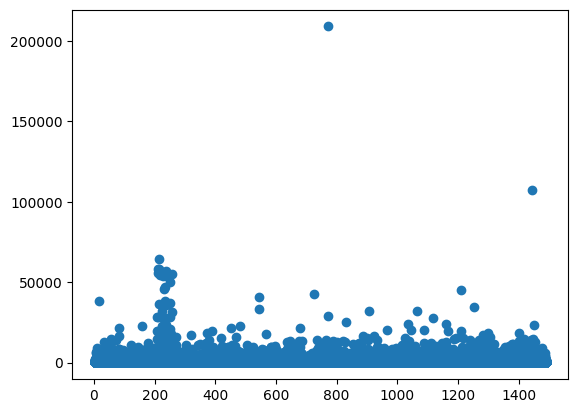

In [ ]:
plt.scatter(new_history.hour, new_history.cpm)
plt.show()

Видно, что есть значения CPM которые вибиваются из общего распределения. Это точки:

In [ ]:
new_history[new_history['cpm'] >= 80000]

index  hour        cpm  publisher  user_id  sex  age  city_id
501340  509960   773  209053.98          3    17185    2   41        7
951066  967589  1445  107054.34          3    17185    2   41        7

Удалим эти точки

In [ ]:
new_history = new_history[new_history['cpm'] <= 80000]

Посмотрим на распределение ставок CPM

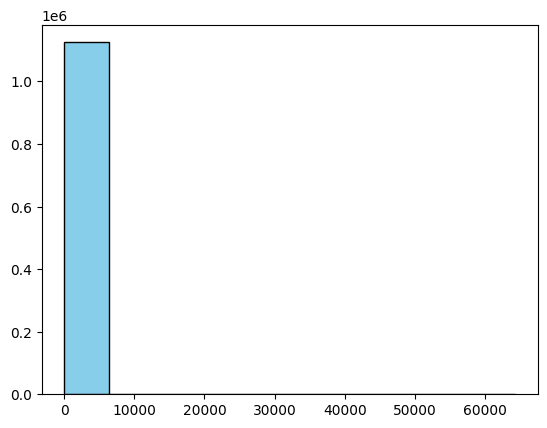

In [ ]:
plt.hist(new_history['cpm'], bins=10, color='skyblue', edgecolor='black')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

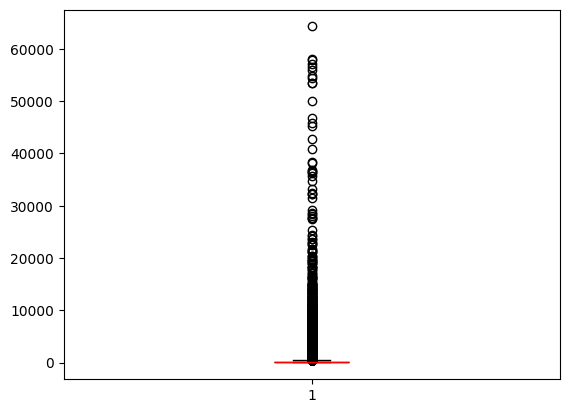

In [ ]:
plt.boxplot(new_history['cpm'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='skyblue'),
            medianprops=dict(color='red'))
plt.show

По boxplot и гистограмме распределния видно, что ставки cpm очень сильно не равномерны. Медианное значение находися на уровне 111 а срднее 188

In [ ]:
print(f'Медиана ставок CPM {new_history.cpm.median()}')
print(f'Среднее  CPM {new_history.cpm.mean()}')

Медиана ставок CPM 111.0
Среднее  CPM 188.80145226155201


Для избавления от аутлаеров используем метод 3-сигма

In [ ]:
def three_sigma(ser):
    bool_id = ((ser.mean() - 3 * ser.std()) <= ser)  &   (ser <= (ser.mean() + 3 * ser.std()))
    return ser.index[bool_id]

In [ ]:
index_name_list = three_sigma(new_history.cpm)
new_history = new_history.loc[index_name_list,:]

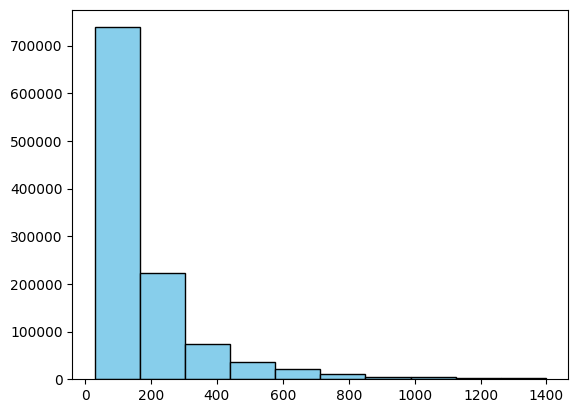

In [ ]:
plt.hist(new_history['cpm'], bins=10, color='skyblue', edgecolor='black')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

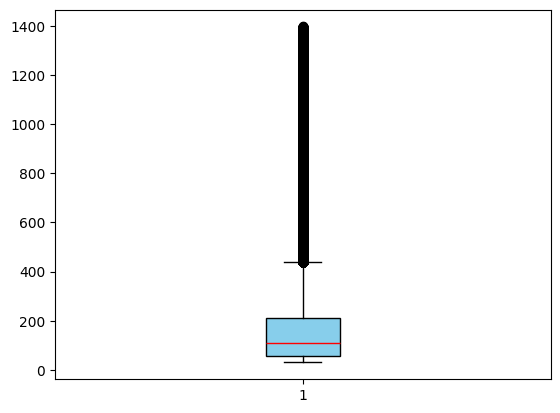

In [ ]:
plt.boxplot(new_history['cpm'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='skyblue'),
            medianprops=dict(color='red'))
plt.show

## Проанализируем признак age

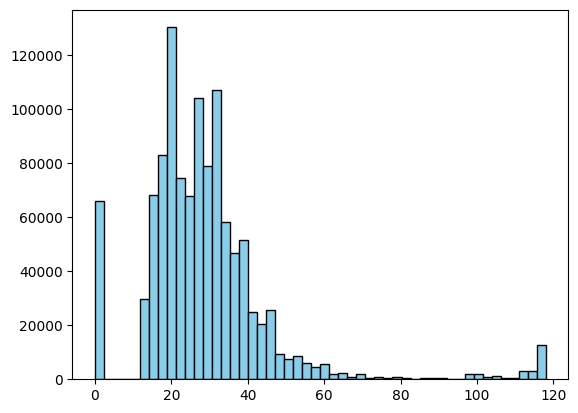

In [ ]:
plt.hist(new_history.age, bins=50, color='skyblue', edgecolor='black')
plt.show()

Избавимся от юзеров с возростом 0

In [ ]:
new_history = new_history[new_history['age']>0]

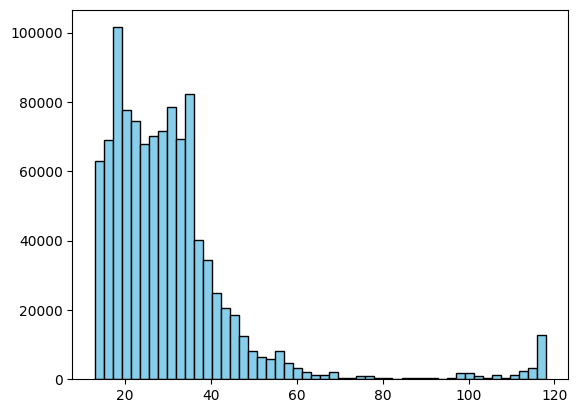

In [ ]:
plt.hist(new_history.age, bins=50, color='skyblue', edgecolor='black')
plt.show()

In [ ]:
index_name_list = three_sigma(new_history.age)
new_history = new_history.loc[index_name_list,:]

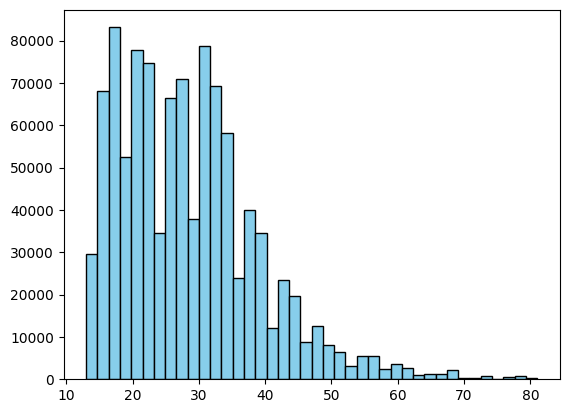

In [ ]:
plt.hist(new_history.age, bins=40, color='skyblue', edgecolor='black')
plt.show()

## Проанализируем признак city_id

In [ ]:
# Сколько городов
new_history['city_id'].value_counts()

city_id
0       244063
3        76440
7        58422
11       15096
25       14358
         ...  
390          1
1695         1
1259         1
2051         1
629          1
Name: count, Length: 2230, dtype: int64

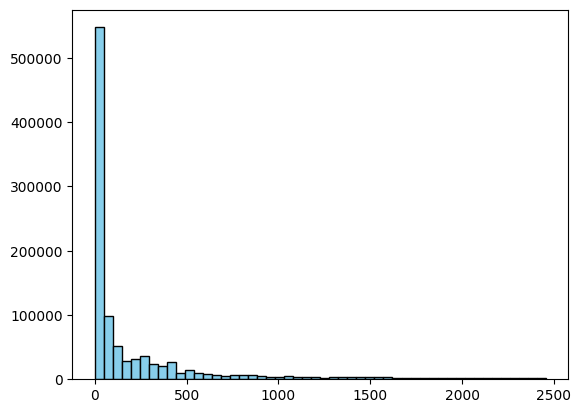

In [ ]:
plt.hist(new_history.city_id, bins=50, color='skyblue', edgecolor='black')
plt.show()

Удалим юзеров с кодом города = 0, то есть юзеров без городов

In [ ]:
new_history = new_history[new_history['city_id']>0]

Новое распределение city_id

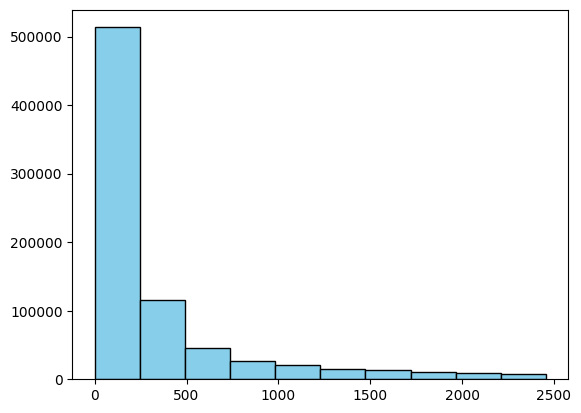

In [ ]:
plt.hist(new_history['city_id'], bins=10, color='skyblue', edgecolor='black')
plt.show()

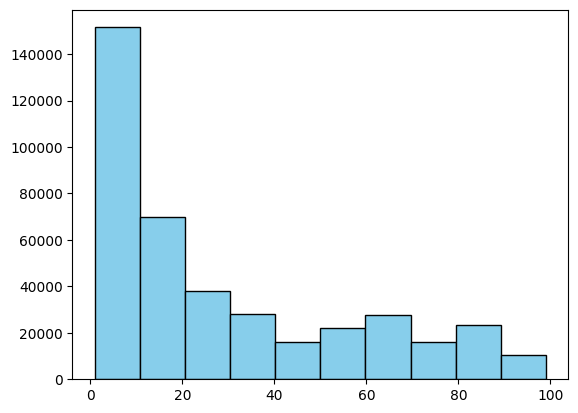

In [ ]:
plt.hist(new_history['city_id'][new_history['city_id']<100], bins=10, color='skyblue', edgecolor='black')
plt.show()

In [ ]:
new_history['city_id'][new_history['city_id']>100].count()

375866

In [ ]:
new_history = new_history[new_history['city_id']<=100]

In [ ]:
new_history

index  hour     cpm  publisher  user_id  sex  age  city_id
0              0    10   30.00          1    15661    2   28       68
3              3    18  370.00          1    21530    2   17       13
4              4     8  195.00          2    22148    1   23        7
5              5     5   70.00          2    16334    1   23       59
6              6    10   73.22          1    25931    1   19        7
...          ...   ...     ...        ...      ...  ...  ...      ...
1125657  1147847   378  180.20          1       45    1   33       18
1125658  1147848   374  150.70          1    23497    2   35        7
1125661  1147851   381  318.94          1    13017    1   50       56
1125663  1147853   360   33.35          1     7992    1   35        7
1125664  1147854   381  205.00          1    21516    1   27       13

[403724 rows x 8 columns]

## Проанализируем признак 'sex'

In [ ]:
new_history['sex'].value_counts()


sex
1    206868
2    196856
Name: count, dtype: int64

Сделаем трансформация OneHotencoder для признаков:
* city_id
* sex

In [ ]:
oh_columns = ['city_id', 'sex']
encoder = OneHotEncoder(sparse_output=False)
encoded_col = encoder.fit_transform(new_history[oh_columns])
df_encoded_col = pd.DataFrame(encoded_col, columns=encoder.get_feature_names_out())
new_history_processed = pd.concat([new_history.drop(columns=oh_columns).reset_index(drop=True), df_encoded_col], axis=1)

In [ ]:
new_history_processed

index  hour     cpm  publisher  user_id  age  city_id_1  city_id_3  \
0             0    10   30.00          1    15661   28        0.0        0.0   
1             3    18  370.00          1    21530   17        0.0        0.0   
2             4     8  195.00          2    22148   23        0.0        0.0   
3             5     5   70.00          2    16334   23        0.0        0.0   
4             6    10   73.22          1    25931   19        0.0        0.0   
...         ...   ...     ...        ...      ...  ...        ...        ...   
403719  1147847   378  180.20          1       45   33        0.0        0.0   
403720  1147848   374  150.70          1    23497   35        0.0        0.0   
403721  1147851   381  318.94          1    13017   50        0.0        0.0   
403722  1147853   360   33.35          1     7992   35        0.0        0.0   
403723  1147854   381  205.00          1    21516   27        0.0        0.0   

        city_id_4  city_id_5  ...  city_id_93  city_id_94  city_id_95  \
0             0.0        0.0  ...         0.0         0.0         0.0   
1             0.0        0.0  ...         0.0         0.0         0.0   
2             0.0        0.0  ...         0.0         0.0         0.0   
3             0.0        0.0  ...         0.0         0.0         0.0   
4             0.0        0.0  ...         0.0         0.0         0.0   
...           ...        ...  ...         ...         ...         ...   
403719        0.0        0.0  ...         0.0         0.0         0.0   
403720        0.0        0.0  ...         0.0         0.0         0.0   
403721        0.0        0.0  ...         0.0         0.0         0.0   
403722        0.0        0.0  ...         0.0         0.0         0.0   
403723        0.0        0.0  ...         0.0         0.0         0.0   

        city_id_96  city_id_97  city_id_98  city_id_99  city_id_100  sex_1  \
0              0.0         0.0         0.0         0.0          0.0    0.0   
1              0.0         0.0         0.0         0.0          0.0    0.0   
2              0.0         0.0         0.0         0.0          0.0    1.0   
3              0.0         0.0         0.0         0.0          0.0    1.0   
4              0.0         0.0         0.0         0.0          0.0    1.0   
...            ...         ...         ...         ...          ...    ...   
403719         0.0         0.0         0.0         0.0          0.0    1.0   
403720         0.0         0.0         0.0         0.0          0.0    0.0   
403721         0.0         0.0         0.0         0.0          0.0    1.0   
403722         0.0         0.0         0.0         0.0          0.0    1.0   
403723         0.0         0.0         0.0         0.0          0.0    1.0   

        sex_2  
0         1.0  
1         1.0  
2         0.0  
3         0.0  
4         0.0  
...       ...  
403719    0.0  
403720    1.0  
403721    0.0  
403722    0.0  
403723    0.0  

[403724 rows x 107 columns]

## Агрегация таблицы по 'cpm' и 'hour'

Проведем агрегацию таблицы new_history_processed, что бы посчитать сколько пользователей посмотрели конкретное объявление

In [ ]:
# предварительные действия для составления словаря агрегации для groupby
city_columns = [col for col in new_history_processed.columns if col.startswith('city_id')]
city_columns

['city_id_1',
 'city_id_3',
 'city_id_4',
 'city_id_5',
 'city_id_6',
 'city_id_7',
 'city_id_8',
 'city_id_9',
 'city_id_10',
 'city_id_11',
 'city_id_12',
 'city_id_13',
 'city_id_14',
 'city_id_15',
 'city_id_16',
 'city_id_17',
 'city_id_18',
 'city_id_19',
 'city_id_20',
 'city_id_21',
 'city_id_22',
 'city_id_23',
 'city_id_24',
 'city_id_25',
 'city_id_26',
 'city_id_27',
 'city_id_28',
 'city_id_29',
 'city_id_30',
 'city_id_31',
 'city_id_32',
 'city_id_33',
 'city_id_34',
 'city_id_35',
 'city_id_36',
 'city_id_37',
 'city_id_38',
 'city_id_39',
 'city_id_40',
 'city_id_41',
 'city_id_42',
 'city_id_43',
 'city_id_44',
 'city_id_45',
 'city_id_46',
 'city_id_47',
 'city_id_48',
 'city_id_49',
 'city_id_50',
 'city_id_51',
 'city_id_52',
 'city_id_53',
 'city_id_54',
 'city_id_55',
 'city_id_56',
 'city_id_57',
 'city_id_58',
 'city_id_59',
 'city_id_60',
 'city_id_61',
 'city_id_62',
 'city_id_63',
 'city_id_64',
 'city_id_65',
 'city_id_66',
 'city_id_67',
 'city_id_68',
 'c

In [ ]:
# предварительные действия для составления словаря агрегации для groupby
city_list = [(city_column, 'sum') for city_column in city_columns]
city_dict = dict([(key, value) for key, value in city_list])
city_dict

{'city_id_1': 'sum',
 'city_id_3': 'sum',
 'city_id_4': 'sum',
 'city_id_5': 'sum',
 'city_id_6': 'sum',
 'city_id_7': 'sum',
 'city_id_8': 'sum',
 'city_id_9': 'sum',
 'city_id_10': 'sum',
 'city_id_11': 'sum',
 'city_id_12': 'sum',
 'city_id_13': 'sum',
 'city_id_14': 'sum',
 'city_id_15': 'sum',
 'city_id_16': 'sum',
 'city_id_17': 'sum',
 'city_id_18': 'sum',
 'city_id_19': 'sum',
 'city_id_20': 'sum',
 'city_id_21': 'sum',
 'city_id_22': 'sum',
 'city_id_23': 'sum',
 'city_id_24': 'sum',
 'city_id_25': 'sum',
 'city_id_26': 'sum',
 'city_id_27': 'sum',
 'city_id_28': 'sum',
 'city_id_29': 'sum',
 'city_id_30': 'sum',
 'city_id_31': 'sum',
 'city_id_32': 'sum',
 'city_id_33': 'sum',
 'city_id_34': 'sum',
 'city_id_35': 'sum',
 'city_id_36': 'sum',
 'city_id_37': 'sum',
 'city_id_38': 'sum',
 'city_id_39': 'sum',
 'city_id_40': 'sum',
 'city_id_41': 'sum',
 'city_id_42': 'sum',
 'city_id_43': 'sum',
 'city_id_44': 'sum',
 'city_id_45': 'sum',
 'city_id_46': 'sum',
 'city_id_47': 'su

In [ ]:
# предварительные действия для составления словаря агрегации для groupby
other_column_dict = {
    'user_id': 'count',
    'age': 'mean',
    'sex_1': 'sum',
    'sex_2': 'sum'
}

In [ ]:
# предварительные действия для составления словаря агрегации для groupby
city_dict.update(other_column_dict)

In [ ]:
multi_agg = city_dict.copy()
multi_agg

{'city_id_1': 'sum',
 'city_id_3': 'sum',
 'city_id_4': 'sum',
 'city_id_5': 'sum',
 'city_id_6': 'sum',
 'city_id_7': 'sum',
 'city_id_8': 'sum',
 'city_id_9': 'sum',
 'city_id_10': 'sum',
 'city_id_11': 'sum',
 'city_id_12': 'sum',
 'city_id_13': 'sum',
 'city_id_14': 'sum',
 'city_id_15': 'sum',
 'city_id_16': 'sum',
 'city_id_17': 'sum',
 'city_id_18': 'sum',
 'city_id_19': 'sum',
 'city_id_20': 'sum',
 'city_id_21': 'sum',
 'city_id_22': 'sum',
 'city_id_23': 'sum',
 'city_id_24': 'sum',
 'city_id_25': 'sum',
 'city_id_26': 'sum',
 'city_id_27': 'sum',
 'city_id_28': 'sum',
 'city_id_29': 'sum',
 'city_id_30': 'sum',
 'city_id_31': 'sum',
 'city_id_32': 'sum',
 'city_id_33': 'sum',
 'city_id_34': 'sum',
 'city_id_35': 'sum',
 'city_id_36': 'sum',
 'city_id_37': 'sum',
 'city_id_38': 'sum',
 'city_id_39': 'sum',
 'city_id_40': 'sum',
 'city_id_41': 'sum',
 'city_id_42': 'sum',
 'city_id_43': 'sum',
 'city_id_44': 'sum',
 'city_id_45': 'sum',
 'city_id_46': 'sum',
 'city_id_47': 'su

In [ ]:
# итоговый словарь агрегации
multi_agg_list = list(multi_agg.keys())
multi_agg_list

['city_id_1',
 'city_id_3',
 'city_id_4',
 'city_id_5',
 'city_id_6',
 'city_id_7',
 'city_id_8',
 'city_id_9',
 'city_id_10',
 'city_id_11',
 'city_id_12',
 'city_id_13',
 'city_id_14',
 'city_id_15',
 'city_id_16',
 'city_id_17',
 'city_id_18',
 'city_id_19',
 'city_id_20',
 'city_id_21',
 'city_id_22',
 'city_id_23',
 'city_id_24',
 'city_id_25',
 'city_id_26',
 'city_id_27',
 'city_id_28',
 'city_id_29',
 'city_id_30',
 'city_id_31',
 'city_id_32',
 'city_id_33',
 'city_id_34',
 'city_id_35',
 'city_id_36',
 'city_id_37',
 'city_id_38',
 'city_id_39',
 'city_id_40',
 'city_id_41',
 'city_id_42',
 'city_id_43',
 'city_id_44',
 'city_id_45',
 'city_id_46',
 'city_id_47',
 'city_id_48',
 'city_id_49',
 'city_id_50',
 'city_id_51',
 'city_id_52',
 'city_id_53',
 'city_id_54',
 'city_id_55',
 'city_id_56',
 'city_id_57',
 'city_id_58',
 'city_id_59',
 'city_id_60',
 'city_id_61',
 'city_id_62',
 'city_id_63',
 'city_id_64',
 'city_id_65',
 'city_id_66',
 'city_id_67',
 'city_id_68',
 'c

In [ ]:
# Группировка и агрегация данных
new_history_grouped = new_history_processed.groupby(by = ['hour', 'cpm'])[multi_agg_list].aggregate(multi_agg)
new_history_grouped = new_history_grouped.reset_index()
new_history_grouped

hour      cpm  city_id_1  city_id_3  city_id_4  city_id_5  city_id_6  \
0          3    30.00        0.0        0.0        0.0        0.0        0.0   
1          3    31.41        0.0        0.0        0.0        0.0        0.0   
2          3    48.54        0.0        0.0        1.0        0.0        0.0   
3          3    50.00        0.0        0.0        0.0        0.0        0.0   
4          3    52.50        0.0        0.0        0.0        0.0        0.0   
...      ...      ...        ...        ...        ...        ...        ...   
272695  1490   660.00        0.0        0.0        0.0        0.0        0.0   
272696  1490   678.15        0.0        0.0        0.0        0.0        0.0   
272697  1490  1010.30        0.0        1.0        0.0        0.0        0.0   
272698  1490  1044.70        0.0        1.0        0.0        0.0        0.0   
272699  1490  1377.22        0.0        1.0        0.0        0.0        0.0   

        city_id_7  city_id_8  city_id_9  ...  city_id_95  city_id_96  \
0             0.0        0.0        0.0  ...         0.0         0.0   
1             0.0        0.0        0.0  ...         0.0         0.0   
2             0.0        0.0        0.0  ...         0.0         0.0   
3             0.0        0.0        0.0  ...         1.0         0.0   
4             0.0        0.0        0.0  ...         0.0         0.0   
...           ...        ...        ...  ...         ...         ...   
272695        0.0        0.0        0.0  ...         0.0         0.0   
272696        0.0        0.0        0.0  ...         0.0         0.0   
272697        0.0        0.0        0.0  ...         0.0         0.0   
272698        0.0        0.0        0.0  ...         0.0         0.0   
272699        0.0        0.0        0.0  ...         0.0         0.0   

        city_id_97  city_id_98  city_id_99  city_id_100  user_id   age  sex_1  \
0              0.0         0.0         0.0          0.0        2  43.0    1.0   
1              0.0         0.0         0.0          0.0        1  36.0    0.0   
2              0.0         0.0         0.0          0.0        1  40.0    0.0   
3              0.0         0.0         0.0          0.0        1  31.0    1.0   
4              0.0         0.0         0.0          0.0        1  18.0    0.0   
...            ...         ...         ...          ...      ...   ...    ...   
272695         0.0         0.0         0.0          0.0        1  19.0    0.0   
272696         0.0         0.0         0.0          0.0        1  21.0    0.0   
272697         0.0         0.0         0.0          0.0        1  28.0    0.0   
272698         0.0         0.0         0.0          0.0        1  18.0    1.0   
272699         0.0         0.0         0.0          0.0        1  28.0    0.0   

        sex_2  
0         1.0  
1         1.0  
2         1.0  
3         0.0  
4         1.0  
...       ...  
272695    1.0  
272696    1.0  
272697    1.0  
272698    0.0  
272699    1.0  

[272700 rows x 105 columns]

Переименуем и перенесем в коенц датасэта целевую переменную  user_id.

In [ ]:
new_history_grouped.rename(columns={'user_id':'seen_ids'}, inplace=True)
new_history_grouped

hour      cpm  city_id_1  city_id_3  city_id_4  city_id_5  city_id_6  \
0          3    30.00        0.0        0.0        0.0        0.0        0.0   
1          3    31.41        0.0        0.0        0.0        0.0        0.0   
2          3    48.54        0.0        0.0        1.0        0.0        0.0   
3          3    50.00        0.0        0.0        0.0        0.0        0.0   
4          3    52.50        0.0        0.0        0.0        0.0        0.0   
...      ...      ...        ...        ...        ...        ...        ...   
272695  1490   660.00        0.0        0.0        0.0        0.0        0.0   
272696  1490   678.15        0.0        0.0        0.0        0.0        0.0   
272697  1490  1010.30        0.0        1.0        0.0        0.0        0.0   
272698  1490  1044.70        0.0        1.0        0.0        0.0        0.0   
272699  1490  1377.22        0.0        1.0        0.0        0.0        0.0   

        city_id_7  city_id_8  city_id_9  ...  city_id_95  city_id_96  \
0             0.0        0.0        0.0  ...         0.0         0.0   
1             0.0        0.0        0.0  ...         0.0         0.0   
2             0.0        0.0        0.0  ...         0.0         0.0   
3             0.0        0.0        0.0  ...         1.0         0.0   
4             0.0        0.0        0.0  ...         0.0         0.0   
...           ...        ...        ...  ...         ...         ...   
272695        0.0        0.0        0.0  ...         0.0         0.0   
272696        0.0        0.0        0.0  ...         0.0         0.0   
272697        0.0        0.0        0.0  ...         0.0         0.0   
272698        0.0        0.0        0.0  ...         0.0         0.0   
272699        0.0        0.0        0.0  ...         0.0         0.0   

        city_id_97  city_id_98  city_id_99  city_id_100  seen_ids   age  \
0              0.0         0.0         0.0          0.0         2  43.0   
1              0.0         0.0         0.0          0.0         1  36.0   
2              0.0         0.0         0.0          0.0         1  40.0   
3              0.0         0.0         0.0          0.0         1  31.0   
4              0.0         0.0         0.0          0.0         1  18.0   
...            ...         ...         ...          ...       ...   ...   
272695         0.0         0.0         0.0          0.0         1  19.0   
272696         0.0         0.0         0.0          0.0         1  21.0   
272697         0.0         0.0         0.0          0.0         1  28.0   
272698         0.0         0.0         0.0          0.0         1  18.0   
272699         0.0         0.0         0.0          0.0         1  28.0   

        sex_1  sex_2  
0         1.0    1.0  
1         0.0    1.0  
2         0.0    1.0  
3         1.0    0.0  
4         0.0    1.0  
...       ...    ...  
272695    0.0    1.0  
272696    0.0    1.0  
272697    0.0    1.0  
272698    1.0    0.0  
272699    0.0    1.0  

[272700 rows x 105 columns]

In [ ]:
column_to_move = new_history_grouped.pop('seen_ids')
new_history_grouped.insert(len(new_history_grouped.columns), 'seen_ids', column_to_move)

In [ ]:
new_history_grouped.sort_values(by='seen_ids', ascending=False)

hour      cpm  city_id_1  city_id_3  city_id_4  city_id_5  city_id_6  \
124899   693    30.00        0.0       18.0        3.0        0.0        0.0   
72791    404    30.00        0.0        0.0        0.0        0.0        0.0   
16768     92    30.00        0.0        6.0        2.0        0.0        0.0   
73038    405    30.00        1.0        3.0        0.0        0.0        0.0   
155259   859    30.00        0.0        2.0        1.0        0.0        0.0   
...      ...      ...        ...        ...        ...        ...        ...   
98687    548   755.31        0.0        0.0        0.0        0.0        0.0   
98688    548   763.41        0.0        0.0        0.0        0.0        0.0   
98689    548  1119.68        0.0        0.0        0.0        0.0        0.0   
98690    548  1159.27        0.0        0.0        0.0        0.0        0.0   
272699  1490  1377.22        0.0        1.0        0.0        0.0        0.0   

        city_id_7  city_id_8  city_id_9  ...  city_id_95  city_id_96  \
124899        4.0        0.0        0.0  ...         0.0         0.0   
72791         1.0        2.0        0.0  ...         0.0         0.0   
16768         0.0        1.0        0.0  ...         0.0         0.0   
73038         5.0        0.0        0.0  ...         0.0         0.0   
155259        5.0        3.0        0.0  ...         0.0         0.0   
...           ...        ...        ...  ...         ...         ...   
98687         0.0        0.0        0.0  ...         0.0         0.0   
98688         1.0        0.0        0.0  ...         0.0         0.0   
98689         1.0        0.0        0.0  ...         0.0         0.0   
98690         0.0        0.0        0.0  ...         0.0         0.0   
272699        0.0        0.0        0.0  ...         0.0         0.0   

        city_id_97  city_id_98  city_id_99  city_id_100        age  sex_1  \
124899         0.0         0.0         0.0          0.0  25.740741   23.0   
72791          2.0         0.0         0.0          0.0  25.500000   14.0   
16768          0.0         0.0         0.0          0.0  25.088889   21.0   
73038          1.0         0.0         0.0          0.0  28.860465   22.0   
155259         0.0         0.0         0.0          0.0  25.302326   22.0   
...            ...         ...         ...          ...        ...    ...   
98687          0.0         0.0         0.0          0.0  31.000000    1.0   
98688          0.0         0.0         0.0          0.0  45.000000    1.0   
98689          0.0         0.0         0.0          0.0  24.000000    1.0   
98690          0.0         0.0         0.0          0.0  23.000000    0.0   
272699         0.0         0.0         0.0          0.0  28.000000    0.0   

        sex_2  seen_ids  
124899   31.0        54  
72791    34.0        48  
16768    24.0        45  
73038    21.0        43  
155259   21.0        43  
...       ...       ...  
98687     0.0         1  
98688     0.0         1  
98689     0.0         1  
98690     1.0         1  
272699    1.0         1  

[272700 rows x 105 columns]

Посторим распределение целевой переменной 'seen_ids'

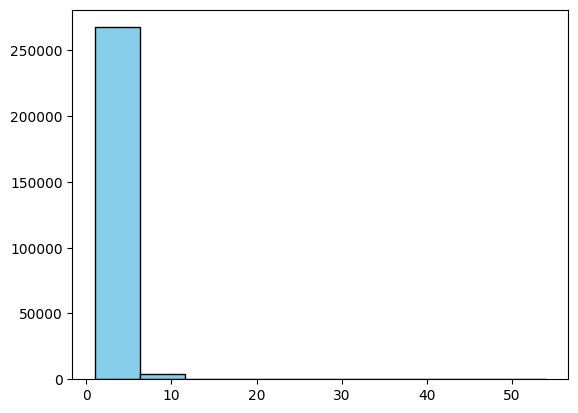

In [ ]:
plt.hist(new_history_grouped['seen_ids'], bins=10, color='skyblue', edgecolor='black')
plt.show()

Будем считать, что аудитория 1 челоека не информативна для построения модели предсказания. Поэтоу удалим все объявлния у которых аудитория меньше 2 человек

In [ ]:
new_history_grouped = new_history_grouped[new_history_grouped['seen_ids']>=2]
new_history_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43284 entries, 0 to 272692
Columns: 105 entries, hour to seen_ids
dtypes: float64(103), int64(2)
memory usage: 35.0 MB


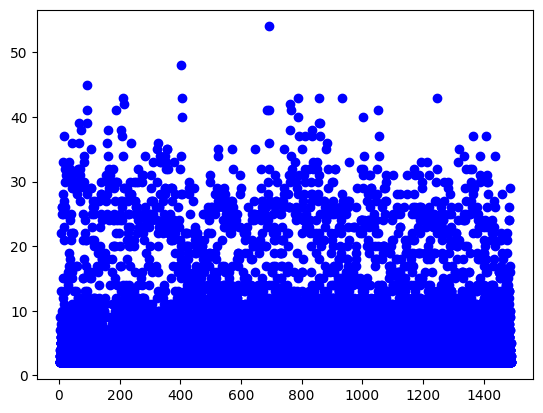

In [ ]:
plt.scatter(new_history_grouped.hour, new_history_grouped.seen_ids, c ="blue")
plt.show()

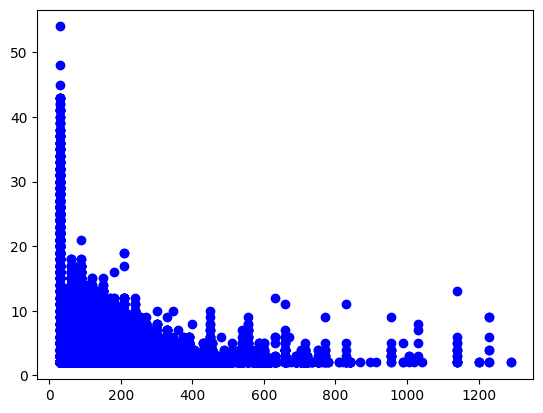

In [ ]:
plt.scatter(new_history_grouped.cpm, new_history_grouped.seen_ids, c ="blue")
plt.show()

Финальная таблица

In [ ]:
final_dataset = new_history_grouped.sort_values(by='seen_ids', ascending=False).copy()
final_dataset.to_csv('final_dataset.csv')

In [ ]:
final_dataset.drop(columns=['city_id_77'], inplace=True)

# Разработка моделей

## XGBoost

In [ ]:
# Разделение на признаки (X) и целевую переменную (y)
X = final_dataset.drop('seen_ids', axis=1)
y = final_dataset['seen_ids']

# Обработка пропущенных значений (если есть) - важно!
# Заполните пропущенные значения, например, средними значениями:
for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].mean())


# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели XGBoost
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
best_params = study.best_params
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)


# Получение feature importance
feature_importances = model.feature_importances_

# Создание DataFrame для удобства отображения
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

[I 2024-12-19 19:50:26,163] A new study created in memory with name: no-name-3584542f-c73a-4b8a-b730-d95c6aadd353
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree

[0]	validation_0-rmse:3.91293
[1]	validation_0-rmse:3.86788
[2]	validation_0-rmse:3.82917
[3]	validation_0-rmse:3.78506
[4]	validation_0-rmse:3.74134
[5]	validation_0-rmse:3.70415
[6]	validation_0-rmse:3.66143
[7]	validation_0-rmse:3.62522
[8]	validation_0-rmse:3.58915
[9]	validation_0-rmse:3.55320
[10]	validation_0-rmse:3.51240
[11]	validation_0-rmse:3.47851
[12]	validation_0-rmse:3.43853
[13]	validation_0-rmse:3.39915
[14]	validation_0-rmse:3.36545
[15]	validation_0-rmse:3.33195
[16]	validation_0-rmse:3.29933
[17]	validation_0-rmse:3.27397
[18]	validation_0-rmse:3.24167
[19]	validation_0-rmse:3.20443
[20]	validation_0-rmse:3.17334
[21]	validation_0-rmse:3.14174
[22]	validation_0-rmse:3.11116
[23]	validation_0-rmse:3.07564
[24]	validation_0-rmse:3.04026
[25]	validation_0-rmse:3.01025
[26]	validation_0-rmse:2.98062
[27]	validation_0-rmse:2.94667
[28]	validation_0-rmse:2.91783
[29]	validation_0-rmse:2.88446
[30]	validation_0-rmse:2.85154
[31]	validation_0-rmse:2.81915
[32]	validation_0-

[I 2024-12-19 19:50:51,755] Trial 0 finished with value: 0.09001783281564713 and parameters: {'n_estimators': 508, 'max_depth': 8, 'learning_rate': 0.011571205705521802, 'subsample': 0.8563617241382921, 'colsample_bytree': 0.6441551201208708, 'alpha': 0.0003545294506234732, 'lambda': 7.745384433510906e-07}. Best is trial 0 with value: 0.09001783281564713.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.88135
[1]	validation_0-rmse:3.80529
[2]	validation_0-rmse:3.73834
[3]	validation_0-rmse:3.66513
[4]	validation_0-rmse:3.59357
[5]	validation_0-rmse:3.52340
[6]	validation_0-rmse:3.45532
[7]	validation_0-rmse:3.39533
[8]	validation_0-rmse:3.33676
[9]	validation_0-rmse:3.27962
[10]	validation_0-rmse:3.21663
[11]	validation_0-rmse:3.16213
[12]	validation_0-rmse:3.10096
[13]	validation_0-rmse:3.04163
[14]	validation_0-rmse:2.99070
[15]	validation_0-rmse:2.93811
[16]	validation_0-rmse:2.88898
[17]	validation_0-rmse:2.85704
[18]	validation_0-rmse:2.80760
[19]	validation_0-rmse:2.75434
[20]	validation_0-rmse:2.70700
[21]	validation_0-rmse:2.66044
[22]	validation_0-rmse:2.61604
[23]	validation_0-rmse:2.56652
[24]	validation_0-rmse:2.51843
[25]	validation_0-rmse:2.47136
[26]	validation_0-rmse:2.42531
[27]	validation_0-rmse:2.38030
[28]	validation_0-rmse:2.34131
[29]	validation_0-rmse:2.29765
[30]	validation_0-rmse:2.25553
[31]	validation_0-rmse:2.21400
[32]	validation_0-

[I 2024-12-19 19:51:05,737] Trial 1 finished with value: 0.02513202652335167 and parameters: {'n_estimators': 416, 'max_depth': 4, 'learning_rate': 0.02088287045273251, 'subsample': 0.9924244902393641, 'colsample_bytree': 0.7708251052361612, 'alpha': 5.419788396759028e-07, 'lambda': 0.13568668971137915}. Best is trial 1 with value: 0.02513202652335167.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureW

[0]	validation_0-rmse:3.70121
[1]	validation_0-rmse:3.46007
[2]	validation_0-rmse:3.26384
[3]	validation_0-rmse:3.05174
[4]	validation_0-rmse:2.85450
[5]	validation_0-rmse:2.66958
[6]	validation_0-rmse:2.49655
[7]	validation_0-rmse:2.35389
[8]	validation_0-rmse:2.22218
[9]	validation_0-rmse:2.10079
[10]	validation_0-rmse:1.96870
[11]	validation_0-rmse:1.86425
[12]	validation_0-rmse:1.74504
[13]	validation_0-rmse:1.63540
[14]	validation_0-rmse:1.55028
[15]	validation_0-rmse:1.46747
[16]	validation_0-rmse:1.39549
[17]	validation_0-rmse:1.34190
[18]	validation_0-rmse:1.27129
[19]	validation_0-rmse:1.19445
[20]	validation_0-rmse:1.13235
[21]	validation_0-rmse:1.07604
[22]	validation_0-rmse:1.02626
[23]	validation_0-rmse:0.96605
[24]	validation_0-rmse:0.91037
[25]	validation_0-rmse:0.85972
[26]	validation_0-rmse:0.81128
[27]	validation_0-rmse:0.76539
[28]	validation_0-rmse:0.73349
[29]	validation_0-rmse:0.69429
[30]	validation_0-rmse:0.65814
[31]	validation_0-rmse:0.62474
[32]	validation_0-

[I 2024-12-19 19:51:09,098] Trial 2 finished with value: 0.06908299773931503 and parameters: {'n_estimators': 64, 'max_depth': 10, 'learning_rate': 0.06661561050657747, 'subsample': 0.6467541000929065, 'colsample_bytree': 0.7886947293446828, 'alpha': 0.040879462015220386, 'lambda': 0.45658332027256837}. Best is trial 1 with value: 0.02513202652335167.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureWa

[0]	validation_0-rmse:3.75068
[1]	validation_0-rmse:3.55265
[2]	validation_0-rmse:3.39099
[3]	validation_0-rmse:3.21484
[4]	validation_0-rmse:3.04699
[5]	validation_0-rmse:2.88829
[6]	validation_0-rmse:2.73684
[7]	validation_0-rmse:2.61340
[8]	validation_0-rmse:2.49658
[9]	validation_0-rmse:2.38580
[10]	validation_0-rmse:2.26409
[11]	validation_0-rmse:2.16663
[12]	validation_0-rmse:2.05459
[13]	validation_0-rmse:1.94869
[14]	validation_0-rmse:1.86735
[15]	validation_0-rmse:1.78430
[16]	validation_0-rmse:1.69371
[17]	validation_0-rmse:1.64097
[18]	validation_0-rmse:1.56851
[19]	validation_0-rmse:1.48898
[20]	validation_0-rmse:1.42480
[21]	validation_0-rmse:1.36569
[22]	validation_0-rmse:1.30979
[23]	validation_0-rmse:1.24450
[24]	validation_0-rmse:1.18360
[25]	validation_0-rmse:1.12603
[26]	validation_0-rmse:1.07126
[27]	validation_0-rmse:1.01866
[28]	validation_0-rmse:0.97951
[29]	validation_0-rmse:0.93276
[30]	validation_0-rmse:0.88963
[31]	validation_0-rmse:0.84885
[32]	validation_0-

[I 2024-12-19 19:51:18,228] Trial 3 finished with value: 0.032964061945676804 and parameters: {'n_estimators': 210, 'max_depth': 7, 'learning_rate': 0.05370124423457754, 'subsample': 0.7784155188769737, 'colsample_bytree': 0.8042582188611693, 'alpha': 0.47539611615487243, 'lambda': 0.6181165959735524}. Best is trial 1 with value: 0.02513202652335167.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureWar

[0]	validation_0-rmse:3.93430
[1]	validation_0-rmse:3.91018
[2]	validation_0-rmse:3.88947
[3]	validation_0-rmse:3.86584
[4]	validation_0-rmse:3.84204
[5]	validation_0-rmse:3.81862
[6]	validation_0-rmse:3.79522
[7]	validation_0-rmse:3.77518
[8]	validation_0-rmse:3.75526
[9]	validation_0-rmse:3.73519
[10]	validation_0-rmse:3.71231
[11]	validation_0-rmse:3.69268
[12]	validation_0-rmse:3.67007
[13]	validation_0-rmse:3.64776
[14]	validation_0-rmse:3.62814
[15]	validation_0-rmse:3.60917
[16]	validation_0-rmse:3.59002
[17]	validation_0-rmse:3.57600
[18]	validation_0-rmse:3.55733
[19]	validation_0-rmse:3.53569
[20]	validation_0-rmse:3.51695
[21]	validation_0-rmse:3.49843
[22]	validation_0-rmse:3.48017
[23]	validation_0-rmse:3.45893
[24]	validation_0-rmse:3.43771
[25]	validation_0-rmse:3.41681
[26]	validation_0-rmse:3.39904
[27]	validation_0-rmse:3.37830
[28]	validation_0-rmse:3.36050
[29]	validation_0-rmse:3.33995
[30]	validation_0-rmse:3.31953
[31]	validation_0-rmse:3.29924
[32]	validation_0-

[I 2024-12-19 19:51:23,608] Trial 4 finished with value: 3.4417500495910645 and parameters: {'n_estimators': 137, 'max_depth': 7, 'learning_rate': 0.006162860416048308, 'subsample': 0.727974015605506, 'colsample_bytree': 0.7545847974587334, 'alpha': 1.5271225477597172e-07, 'lambda': 3.886125497116765e-07}. Best is trial 1 with value: 0.02513202652335167.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.92677
[1]	validation_0-rmse:3.89514
[2]	validation_0-rmse:3.86384
[3]	validation_0-rmse:3.83291
[4]	validation_0-rmse:3.80225
[5]	validation_0-rmse:3.77173
[6]	validation_0-rmse:3.74112
[7]	validation_0-rmse:3.71111
[8]	validation_0-rmse:3.68486
[9]	validation_0-rmse:3.65539
[10]	validation_0-rmse:3.62606
[11]	validation_0-rmse:3.59676
[12]	validation_0-rmse:3.56775
[13]	validation_0-rmse:3.53923
[14]	validation_0-rmse:3.51066
[15]	validation_0-rmse:3.48249
[16]	validation_0-rmse:3.45466
[17]	validation_0-rmse:3.43126
[18]	validation_0-rmse:3.40386
[19]	validation_0-rmse:3.37663
[20]	validation_0-rmse:3.34956
[21]	validation_0-rmse:3.32277
[22]	validation_0-rmse:3.29930
[23]	validation_0-rmse:3.27275
[24]	validation_0-rmse:3.24667
[25]	validation_0-rmse:3.22061
[26]	validation_0-rmse:3.19478
[27]	validation_0-rmse:3.16907
[28]	validation_0-rmse:3.14705
[29]	validation_0-rmse:3.12193
[30]	validation_0-rmse:3.09698
[31]	validation_0-rmse:3.07231
[32]	validation_0-

[I 2024-12-19 19:52:24,163] Trial 5 finished with value: 0.05738592892885208 and parameters: {'n_estimators': 504, 'max_depth': 14, 'learning_rate': 0.008065437848060072, 'subsample': 0.9015073784496446, 'colsample_bytree': 0.9461932292550019, 'alpha': 0.0013866146049355548, 'lambda': 5.199162902517812e-05}. Best is trial 1 with value: 0.02513202652335167.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.92834
[1]	validation_0-rmse:3.90225
[2]	validation_0-rmse:3.87580
[3]	validation_0-rmse:3.84614
[4]	validation_0-rmse:3.81689
[5]	validation_0-rmse:3.79175
[6]	validation_0-rmse:3.76294
[7]	validation_0-rmse:3.73905
[8]	validation_0-rmse:3.71399
[9]	validation_0-rmse:3.68942
[10]	validation_0-rmse:3.66130
[11]	validation_0-rmse:3.63798
[12]	validation_0-rmse:3.61415
[13]	validation_0-rmse:3.58672
[14]	validation_0-rmse:3.56314
[15]	validation_0-rmse:3.54362
[16]	validation_0-rmse:3.52070
[17]	validation_0-rmse:3.50230
[18]	validation_0-rmse:3.47931
[19]	validation_0-rmse:3.45303
[20]	validation_0-rmse:3.43072
[21]	validation_0-rmse:3.41009
[22]	validation_0-rmse:3.38788
[23]	validation_0-rmse:3.36232
[24]	validation_0-rmse:3.33697
[25]	validation_0-rmse:3.31699
[26]	validation_0-rmse:3.29574
[27]	validation_0-rmse:3.27098
[28]	validation_0-rmse:3.25000
[29]	validation_0-rmse:3.22549
[30]	validation_0-rmse:3.20116
[31]	validation_0-rmse:3.18100
[32]	validation_0-

[I 2024-12-19 19:52:37,201] Trial 6 finished with value: 1.7202051877975464 and parameters: {'n_estimators': 177, 'max_depth': 12, 'learning_rate': 0.007741315643995168, 'subsample': 0.9937189148573595, 'colsample_bytree': 0.596963212994226, 'alpha': 4.864554894369106e-06, 'lambda': 0.1373165807993611}. Best is trial 1 with value: 0.02513202652335167.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureWa

[0]	validation_0-rmse:3.87897
[1]	validation_0-rmse:3.80085
[2]	validation_0-rmse:3.73474
[3]	validation_0-rmse:3.66007
[4]	validation_0-rmse:3.58649
[5]	validation_0-rmse:3.51463
[6]	validation_0-rmse:3.44392
[7]	validation_0-rmse:3.38380
[8]	validation_0-rmse:3.32528
[9]	validation_0-rmse:3.25871
[10]	validation_0-rmse:3.19301
[11]	validation_0-rmse:3.13734
[12]	validation_0-rmse:3.07475
[13]	validation_0-rmse:3.01332
[14]	validation_0-rmse:2.96093
[15]	validation_0-rmse:2.91058
[16]	validation_0-rmse:2.85265
[17]	validation_0-rmse:2.81412
[18]	validation_0-rmse:2.75793
[19]	validation_0-rmse:2.70321
[20]	validation_0-rmse:2.65700
[21]	validation_0-rmse:2.61221
[22]	validation_0-rmse:2.56811
[23]	validation_0-rmse:2.51678
[24]	validation_0-rmse:2.46657
[25]	validation_0-rmse:2.41784
[26]	validation_0-rmse:2.37049
[27]	validation_0-rmse:2.32359
[28]	validation_0-rmse:2.28459
[29]	validation_0-rmse:2.23950
[30]	validation_0-rmse:2.19502
[31]	validation_0-rmse:2.15198
[32]	validation_0-

[I 2024-12-19 19:52:51,144] Trial 7 finished with value: 0.05014851316809654 and parameters: {'n_estimators': 297, 'max_depth': 8, 'learning_rate': 0.020221188828789885, 'subsample': 0.7064073425293645, 'colsample_bytree': 0.835408393703555, 'alpha': 0.04764423232310162, 'lambda': 5.457902390918806e-06}. Best is trial 1 with value: 0.02513202652335167.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureW

[0]	validation_0-rmse:3.93650
[1]	validation_0-rmse:3.91452
[2]	validation_0-rmse:3.89520
[3]	validation_0-rmse:3.87348
[4]	validation_0-rmse:3.85167
[5]	validation_0-rmse:3.83029
[6]	validation_0-rmse:3.80888
[7]	validation_0-rmse:3.79031
[8]	validation_0-rmse:3.77170
[9]	validation_0-rmse:3.75329
[10]	validation_0-rmse:3.73229
[11]	validation_0-rmse:3.71408
[12]	validation_0-rmse:3.69343
[13]	validation_0-rmse:3.67304
[14]	validation_0-rmse:3.65489
[15]	validation_0-rmse:3.63686
[16]	validation_0-rmse:3.61911
[17]	validation_0-rmse:3.60691
[18]	validation_0-rmse:3.58929
[19]	validation_0-rmse:3.56935
[20]	validation_0-rmse:3.55180
[21]	validation_0-rmse:3.53448
[22]	validation_0-rmse:3.51737
[23]	validation_0-rmse:3.49775
[24]	validation_0-rmse:3.47810
[25]	validation_0-rmse:3.45863
[26]	validation_0-rmse:3.43949
[27]	validation_0-rmse:3.42046
[28]	validation_0-rmse:3.40379
[29]	validation_0-rmse:3.38493
[30]	validation_0-rmse:3.36601
[31]	validation_0-rmse:3.34756
[32]	validation_0-

[I 2024-12-19 19:52:56,493] Trial 8 finished with value: 3.8254270553588867 and parameters: {'n_estimators': 137, 'max_depth': 5, 'learning_rate': 0.00578589638204625, 'subsample': 0.7075947448692894, 'colsample_bytree': 0.7774382093727616, 'alpha': 2.958035907569816e-07, 'lambda': 0.00022357176464330903}. Best is trial 1 with value: 0.02513202652335167.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.93061
[1]	validation_0-rmse:3.90306
[2]	validation_0-rmse:3.87563
[3]	validation_0-rmse:3.84838
[4]	validation_0-rmse:3.82125
[5]	validation_0-rmse:3.79435
[6]	validation_0-rmse:3.76765
[7]	validation_0-rmse:3.74113
[8]	validation_0-rmse:3.71788
[9]	validation_0-rmse:3.69172
[10]	validation_0-rmse:3.66562
[11]	validation_0-rmse:3.64303
[12]	validation_0-rmse:3.61740
[13]	validation_0-rmse:3.59196
[14]	validation_0-rmse:3.56662
[15]	validation_0-rmse:3.54159
[16]	validation_0-rmse:3.51670
[17]	validation_0-rmse:3.49527
[18]	validation_0-rmse:3.47073
[19]	validation_0-rmse:3.44622
[20]	validation_0-rmse:3.42210
[21]	validation_0-rmse:3.39815
[22]	validation_0-rmse:3.37702
[23]	validation_0-rmse:3.35325
[24]	validation_0-rmse:3.32971
[25]	validation_0-rmse:3.30627
[26]	validation_0-rmse:3.28312
[27]	validation_0-rmse:3.26012
[28]	validation_0-rmse:3.23993
[29]	validation_0-rmse:3.21727
[30]	validation_0-rmse:3.19482
[31]	validation_0-rmse:3.17248
[32]	validation_0-

[I 2024-12-19 19:55:03,007] Trial 9 finished with value: 0.0588846355676651 and parameters: {'n_estimators': 871, 'max_depth': 14, 'learning_rate': 0.007064748896834847, 'subsample': 0.9602109803771492, 'colsample_bytree': 0.9210679245326985, 'alpha': 8.30309239231124e-08, 'lambda': 1.4417305013695756e-06}. Best is trial 1 with value: 0.02513202652335167.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.84382
[1]	validation_0-rmse:3.73178
[2]	validation_0-rmse:3.63189
[3]	validation_0-rmse:3.52802
[4]	validation_0-rmse:3.42626
[5]	validation_0-rmse:3.33655
[6]	validation_0-rmse:3.24185
[7]	validation_0-rmse:3.15628
[8]	validation_0-rmse:3.07340
[9]	validation_0-rmse:2.99297
[10]	validation_0-rmse:2.91054
[11]	validation_0-rmse:2.83724
[12]	validation_0-rmse:2.75838
[13]	validation_0-rmse:2.68292
[14]	validation_0-rmse:2.61490
[15]	validation_0-rmse:2.54676
[16]	validation_0-rmse:2.48383
[17]	validation_0-rmse:2.44580
[18]	validation_0-rmse:2.38278
[19]	validation_0-rmse:2.31923
[20]	validation_0-rmse:2.26088
[21]	validation_0-rmse:2.20450
[22]	validation_0-rmse:2.15038
[23]	validation_0-rmse:2.09278
[24]	validation_0-rmse:2.03812
[25]	validation_0-rmse:1.98833
[26]	validation_0-rmse:1.94080
[27]	validation_0-rmse:1.88998
[28]	validation_0-rmse:1.84587
[29]	validation_0-rmse:1.79899
[30]	validation_0-rmse:1.75189
[31]	validation_0-rmse:1.70831
[32]	validation_0-

[I 2024-12-19 19:55:32,388] Trial 10 finished with value: 0.019055329263210297 and parameters: {'n_estimators': 779, 'max_depth': 3, 'learning_rate': 0.03281591488103936, 'subsample': 0.5726607396517163, 'colsample_bytree': 0.6659223201172483, 'alpha': 5.659138039114684e-06, 'lambda': 0.005902016157964839}. Best is trial 10 with value: 0.019055329263210297.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.84780
[1]	validation_0-rmse:3.74184
[2]	validation_0-rmse:3.64594
[3]	validation_0-rmse:3.54555
[4]	validation_0-rmse:3.44844
[5]	validation_0-rmse:3.36092
[6]	validation_0-rmse:3.26842
[7]	validation_0-rmse:3.18567
[8]	validation_0-rmse:3.10490
[9]	validation_0-rmse:3.02625
[10]	validation_0-rmse:2.94304
[11]	validation_0-rmse:2.87103
[12]	validation_0-rmse:2.79411
[13]	validation_0-rmse:2.72081
[14]	validation_0-rmse:2.65420
[15]	validation_0-rmse:2.58748
[16]	validation_0-rmse:2.52545
[17]	validation_0-rmse:2.48944
[18]	validation_0-rmse:2.42737
[19]	validation_0-rmse:2.36470
[20]	validation_0-rmse:2.30728
[21]	validation_0-rmse:2.25144
[22]	validation_0-rmse:2.19787
[23]	validation_0-rmse:2.14036
[24]	validation_0-rmse:2.08627
[25]	validation_0-rmse:2.03719
[26]	validation_0-rmse:1.99040
[27]	validation_0-rmse:1.94037
[28]	validation_0-rmse:1.89583
[29]	validation_0-rmse:1.84904
[30]	validation_0-rmse:1.80354
[31]	validation_0-rmse:1.75974
[32]	validation_0-

[I 2024-12-19 19:56:03,495] Trial 11 finished with value: 0.019551828503608704 and parameters: {'n_estimators': 827, 'max_depth': 3, 'learning_rate': 0.03161072815129912, 'subsample': 0.5085035468015118, 'colsample_bytree': 0.6477709074503165, 'alpha': 9.351153160828022e-06, 'lambda': 0.007264193511828225}. Best is trial 10 with value: 0.019055329263210297.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.81790
[1]	validation_0-rmse:3.75395
[2]	validation_0-rmse:3.63168
[3]	validation_0-rmse:3.50460
[4]	validation_0-rmse:3.38270
[5]	validation_0-rmse:3.27419
[6]	validation_0-rmse:3.17194
[7]	validation_0-rmse:3.07116
[8]	validation_0-rmse:2.97186
[9]	validation_0-rmse:2.87633
[10]	validation_0-rmse:2.77676
[11]	validation_0-rmse:2.73584
[12]	validation_0-rmse:2.67177
[13]	validation_0-rmse:2.58349
[14]	validation_0-rmse:2.50438
[15]	validation_0-rmse:2.46956
[16]	validation_0-rmse:2.39499
[17]	validation_0-rmse:2.35737
[18]	validation_0-rmse:2.28432
[19]	validation_0-rmse:2.21470
[20]	validation_0-rmse:2.14951
[21]	validation_0-rmse:2.11489
[22]	validation_0-rmse:2.05215
[23]	validation_0-rmse:2.02988
[24]	validation_0-rmse:1.96473
[25]	validation_0-rmse:1.92606
[26]	validation_0-rmse:1.87158
[27]	validation_0-rmse:1.81922
[28]	validation_0-rmse:1.77020
[29]	validation_0-rmse:1.71633
[30]	validation_0-rmse:1.66348
[31]	validation_0-rmse:1.62069
[32]	validation_0-

[I 2024-12-19 19:56:32,557] Trial 12 finished with value: 0.03293805941939354 and parameters: {'n_estimators': 791, 'max_depth': 3, 'learning_rate': 0.040141174606423594, 'subsample': 0.5114795907905691, 'colsample_bytree': 0.5038670325403403, 'alpha': 1.791380425950261e-05, 'lambda': 0.00383683809822802}. Best is trial 10 with value: 0.019055329263210297.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.84408
[1]	validation_0-rmse:3.73477
[2]	validation_0-rmse:3.63572
[3]	validation_0-rmse:3.53227
[4]	validation_0-rmse:3.43230
[5]	validation_0-rmse:3.34238
[6]	validation_0-rmse:3.24736
[7]	validation_0-rmse:3.16232
[8]	validation_0-rmse:3.07945
[9]	validation_0-rmse:2.99885
[10]	validation_0-rmse:2.91357
[11]	validation_0-rmse:2.84001
[12]	validation_0-rmse:2.76134
[13]	validation_0-rmse:2.68655
[14]	validation_0-rmse:2.61878
[15]	validation_0-rmse:2.55080
[16]	validation_0-rmse:2.48789
[17]	validation_0-rmse:2.45141
[18]	validation_0-rmse:2.38835
[19]	validation_0-rmse:2.32487
[20]	validation_0-rmse:2.26670
[21]	validation_0-rmse:2.21023
[22]	validation_0-rmse:2.15603
[23]	validation_0-rmse:2.09802
[24]	validation_0-rmse:2.04354
[25]	validation_0-rmse:1.99410
[26]	validation_0-rmse:1.94697
[27]	validation_0-rmse:1.89539
[28]	validation_0-rmse:1.85066
[29]	validation_0-rmse:1.80397
[30]	validation_0-rmse:1.75843
[31]	validation_0-rmse:1.71546
[32]	validation_0-

[I 2024-12-19 19:56:59,228] Trial 13 finished with value: 0.020138809457421303 and parameters: {'n_estimators': 719, 'max_depth': 3, 'learning_rate': 0.03268692549088598, 'subsample': 0.5046462404127382, 'colsample_bytree': 0.658427645922058, 'alpha': 1.1063019042866927e-08, 'lambda': 0.006663104647435406}. Best is trial 10 with value: 0.019055329263210297.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.61311
[1]	validation_0-rmse:3.30052
[2]	validation_0-rmse:3.04933
[3]	validation_0-rmse:2.78424
[4]	validation_0-rmse:2.54246
[5]	validation_0-rmse:2.35978
[6]	validation_0-rmse:2.15895
[7]	validation_0-rmse:1.99428
[8]	validation_0-rmse:1.84752
[9]	validation_0-rmse:1.71549
[10]	validation_0-rmse:1.57169
[11]	validation_0-rmse:1.46705
[12]	validation_0-rmse:1.34347
[13]	validation_0-rmse:1.23117
[14]	validation_0-rmse:1.15269
[15]	validation_0-rmse:1.07060
[16]	validation_0-rmse:1.00695
[17]	validation_0-rmse:0.96458
[18]	validation_0-rmse:0.90059
[19]	validation_0-rmse:0.83063
[20]	validation_0-rmse:0.77886
[21]	validation_0-rmse:0.73310
[22]	validation_0-rmse:0.69304
[23]	validation_0-rmse:0.64234
[24]	validation_0-rmse:0.59670
[25]	validation_0-rmse:0.56489
[26]	validation_0-rmse:0.53792
[27]	validation_0-rmse:0.50231
[28]	validation_0-rmse:0.48140
[29]	validation_0-rmse:0.45120
[30]	validation_0-rmse:0.42353
[31]	validation_0-rmse:0.39957
[32]	validation_0-

[I 2024-12-19 19:57:35,437] Trial 14 finished with value: 0.029650744050741196 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.09054408557812112, 'subsample': 0.5783303984105106, 'colsample_bytree': 0.6812556103912363, 'alpha': 3.904491373085155e-05, 'lambda': 0.0029771462418845007}. Best is trial 10 with value: 0.019055329263210297.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.84803
[1]	validation_0-rmse:3.75537
[2]	validation_0-rmse:3.66435
[3]	validation_0-rmse:3.56272
[4]	validation_0-rmse:3.46347
[5]	validation_0-rmse:3.38032
[6]	validation_0-rmse:3.28521
[7]	validation_0-rmse:3.20816
[8]	validation_0-rmse:3.12978
[9]	validation_0-rmse:3.05417
[10]	validation_0-rmse:2.97019
[11]	validation_0-rmse:2.92851
[12]	validation_0-rmse:2.85835
[13]	validation_0-rmse:2.78014
[14]	validation_0-rmse:2.71385
[15]	validation_0-rmse:2.66881
[16]	validation_0-rmse:2.60686
[17]	validation_0-rmse:2.56302
[18]	validation_0-rmse:2.50177
[19]	validation_0-rmse:2.43327
[20]	validation_0-rmse:2.37591
[21]	validation_0-rmse:2.34216
[22]	validation_0-rmse:2.28861
[23]	validation_0-rmse:2.26384
[24]	validation_0-rmse:2.20251
[25]	validation_0-rmse:2.16301
[26]	validation_0-rmse:2.11496
[27]	validation_0-rmse:2.05787
[28]	validation_0-rmse:2.01288
[29]	validation_0-rmse:1.95842
[30]	validation_0-rmse:1.90594
[31]	validation_0-rmse:1.86614
[32]	validation_0-

[I 2024-12-19 19:58:00,690] Trial 15 finished with value: 0.04955342039465904 and parameters: {'n_estimators': 649, 'max_depth': 5, 'learning_rate': 0.028941138540605097, 'subsample': 0.5953277671759982, 'colsample_bytree': 0.5513932064307623, 'alpha': 5.232023370685717e-06, 'lambda': 1.0252637544076146e-08}. Best is trial 10 with value: 0.019055329263210297.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: 

[0]	validation_0-rmse:3.88993
[1]	validation_0-rmse:3.82281
[2]	validation_0-rmse:3.76449
[3]	validation_0-rmse:3.69985
[4]	validation_0-rmse:3.63563
[5]	validation_0-rmse:3.58148
[6]	validation_0-rmse:3.51968
[7]	validation_0-rmse:3.46670
[8]	validation_0-rmse:3.41466
[9]	validation_0-rmse:3.36403
[10]	validation_0-rmse:3.30630
[11]	validation_0-rmse:3.25825
[12]	validation_0-rmse:3.20228
[13]	validation_0-rmse:3.14709
[14]	validation_0-rmse:3.09985
[15]	validation_0-rmse:3.05281
[16]	validation_0-rmse:3.00858
[17]	validation_0-rmse:2.97311
[18]	validation_0-rmse:2.92996
[19]	validation_0-rmse:2.88011
[20]	validation_0-rmse:2.83784
[21]	validation_0-rmse:2.79627
[22]	validation_0-rmse:2.75615
[23]	validation_0-rmse:2.70902
[24]	validation_0-rmse:2.66313
[25]	validation_0-rmse:2.62505
[26]	validation_0-rmse:2.58648
[27]	validation_0-rmse:2.54264
[28]	validation_0-rmse:2.50658
[29]	validation_0-rmse:2.46381
[30]	validation_0-rmse:2.42169
[31]	validation_0-rmse:2.38094
[32]	validation_0-

[I 2024-12-19 19:58:48,752] Trial 16 finished with value: 0.06918744742870331 and parameters: {'n_estimators': 910, 'max_depth': 10, 'learning_rate': 0.01742649615800667, 'subsample': 0.5751821250694034, 'colsample_bytree': 0.7008990824439983, 'alpha': 0.0006276455909252799, 'lambda': 0.018152022283799224}. Best is trial 10 with value: 0.019055329263210297.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.91053
[1]	validation_0-rmse:3.86907
[2]	validation_0-rmse:3.82865
[3]	validation_0-rmse:3.78238
[4]	validation_0-rmse:3.73653
[5]	validation_0-rmse:3.69791
[6]	validation_0-rmse:3.65289
[7]	validation_0-rmse:3.61605
[8]	validation_0-rmse:3.57833
[9]	validation_0-rmse:3.54075
[10]	validation_0-rmse:3.49799
[11]	validation_0-rmse:3.46188
[12]	validation_0-rmse:3.42560
[13]	validation_0-rmse:3.38439
[14]	validation_0-rmse:3.34879
[15]	validation_0-rmse:3.32347
[16]	validation_0-rmse:3.28925
[17]	validation_0-rmse:3.26461
[18]	validation_0-rmse:3.23070
[19]	validation_0-rmse:3.19196
[20]	validation_0-rmse:3.15906
[21]	validation_0-rmse:3.13086
[22]	validation_0-rmse:3.09874
[23]	validation_0-rmse:3.06128
[24]	validation_0-rmse:3.02447
[25]	validation_0-rmse:2.99898
[26]	validation_0-rmse:2.96841
[27]	validation_0-rmse:2.93264
[28]	validation_0-rmse:2.90328
[29]	validation_0-rmse:2.86820
[30]	validation_0-rmse:2.83360
[31]	validation_0-rmse:2.80665
[32]	validation_0-

[I 2024-12-19 19:59:19,701] Trial 17 finished with value: 0.061393704265356064 and parameters: {'n_estimators': 651, 'max_depth': 6, 'learning_rate': 0.012341043700777668, 'subsample': 0.6430490176613266, 'colsample_bytree': 0.6025484359342472, 'alpha': 2.716315921148987e-06, 'lambda': 0.0003447927410983492}. Best is trial 10 with value: 0.019055329263210297.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: 

[0]	validation_0-rmse:3.81802
[1]	validation_0-rmse:3.68489
[2]	validation_0-rmse:3.55597
[3]	validation_0-rmse:3.43305
[4]	validation_0-rmse:3.31471
[5]	validation_0-rmse:3.20038
[6]	validation_0-rmse:3.09198
[7]	validation_0-rmse:2.99422
[8]	validation_0-rmse:2.90027
[9]	validation_0-rmse:2.80155
[10]	validation_0-rmse:2.70565
[11]	validation_0-rmse:2.62168
[12]	validation_0-rmse:2.53453
[13]	validation_0-rmse:2.44883
[14]	validation_0-rmse:2.36911
[15]	validation_0-rmse:2.29414
[16]	validation_0-rmse:2.21976
[17]	validation_0-rmse:2.18043
[18]	validation_0-rmse:2.11117
[19]	validation_0-rmse:2.04212
[20]	validation_0-rmse:1.98068
[21]	validation_0-rmse:1.92296
[22]	validation_0-rmse:1.86642
[23]	validation_0-rmse:1.80769
[24]	validation_0-rmse:1.75207
[25]	validation_0-rmse:1.69789
[26]	validation_0-rmse:1.64704
[27]	validation_0-rmse:1.59736
[28]	validation_0-rmse:1.55403
[29]	validation_0-rmse:1.50822
[30]	validation_0-rmse:1.46267
[31]	validation_0-rmse:1.42183
[32]	validation_0-

[I 2024-12-19 19:59:50,259] Trial 18 finished with value: 0.01644146256148815 and parameters: {'n_estimators': 799, 'max_depth': 3, 'learning_rate': 0.040124924937365386, 'subsample': 0.5410066238674908, 'colsample_bytree': 0.8703306789324857, 'alpha': 0.00011158301458440991, 'lambda': 0.03534586333600619}. Best is trial 18 with value: 0.01644146256148815.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.77588
[1]	validation_0-rmse:3.60047
[2]	validation_0-rmse:3.43430
[3]	validation_0-rmse:3.27755
[4]	validation_0-rmse:3.12608
[5]	validation_0-rmse:2.98181
[6]	validation_0-rmse:2.84397
[7]	validation_0-rmse:2.73134
[8]	validation_0-rmse:2.62292
[9]	validation_0-rmse:2.50292
[10]	validation_0-rmse:2.38862
[11]	validation_0-rmse:2.29414
[12]	validation_0-rmse:2.19055
[13]	validation_0-rmse:2.09137
[14]	validation_0-rmse:1.99705
[15]	validation_0-rmse:1.91702
[16]	validation_0-rmse:1.83130
[17]	validation_0-rmse:1.77186
[18]	validation_0-rmse:1.69300
[19]	validation_0-rmse:1.61789
[20]	validation_0-rmse:1.55528
[21]	validation_0-rmse:1.49573
[22]	validation_0-rmse:1.44068
[23]	validation_0-rmse:1.37688
[24]	validation_0-rmse:1.31659
[25]	validation_0-rmse:1.26000
[26]	validation_0-rmse:1.20629
[27]	validation_0-rmse:1.15489
[28]	validation_0-rmse:1.11368
[29]	validation_0-rmse:1.06665
[30]	validation_0-rmse:1.02207
[31]	validation_0-rmse:0.97952
[32]	validation_0-

[I 2024-12-19 20:00:58,514] Trial 19 finished with value: 0.053847555071115494 and parameters: {'n_estimators': 987, 'max_depth': 12, 'learning_rate': 0.04648097045470994, 'subsample': 0.7821575218694048, 'colsample_bytree': 0.8723361353053678, 'alpha': 0.003970588832988394, 'lambda': 0.0007043592310539277}. Best is trial 18 with value: 0.01644146256148815.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.71932
[1]	validation_0-rmse:3.49883
[2]	validation_0-rmse:3.29033
[3]	validation_0-rmse:3.09574
[4]	validation_0-rmse:2.91461
[5]	validation_0-rmse:2.74376
[6]	validation_0-rmse:2.58449
[7]	validation_0-rmse:2.45102
[8]	validation_0-rmse:2.32705
[9]	validation_0-rmse:2.19299
[10]	validation_0-rmse:2.07052
[11]	validation_0-rmse:1.96951
[12]	validation_0-rmse:1.85912
[13]	validation_0-rmse:1.75504
[14]	validation_0-rmse:1.66010
[15]	validation_0-rmse:1.57160
[16]	validation_0-rmse:1.48628
[17]	validation_0-rmse:1.41941
[18]	validation_0-rmse:1.34459
[19]	validation_0-rmse:1.27331
[20]	validation_0-rmse:1.20213
[21]	validation_0-rmse:1.14542
[22]	validation_0-rmse:1.09622
[23]	validation_0-rmse:1.03501
[24]	validation_0-rmse:0.97851
[25]	validation_0-rmse:0.92743
[26]	validation_0-rmse:0.87813
[27]	validation_0-rmse:0.83359
[28]	validation_0-rmse:0.80073
[29]	validation_0-rmse:0.75895
[30]	validation_0-rmse:0.71857
[31]	validation_0-rmse:0.68242
[32]	validation_0-

[I 2024-12-19 20:01:26,490] Trial 20 finished with value: 0.017456721514463425 and parameters: {'n_estimators': 716, 'max_depth': 4, 'learning_rate': 0.06435331957153977, 'subsample': 0.6483916861174177, 'colsample_bytree': 0.8839820234324386, 'alpha': 0.00011997245404412877, 'lambda': 0.044451293159449415}. Best is trial 18 with value: 0.01644146256148815.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.59241
[1]	validation_0-rmse:3.26955
[2]	validation_0-rmse:2.97275
[3]	validation_0-rmse:2.70693
[4]	validation_0-rmse:2.46662
[5]	validation_0-rmse:2.25147
[6]	validation_0-rmse:2.05492
[7]	validation_0-rmse:1.87675
[8]	validation_0-rmse:1.73275
[9]	validation_0-rmse:1.58472
[10]	validation_0-rmse:1.44848
[11]	validation_0-rmse:1.33071
[12]	validation_0-rmse:1.22012
[13]	validation_0-rmse:1.12365
[14]	validation_0-rmse:1.03042
[15]	validation_0-rmse:0.94136
[16]	validation_0-rmse:0.86517
[17]	validation_0-rmse:0.81151
[18]	validation_0-rmse:0.74497
[19]	validation_0-rmse:0.68409
[20]	validation_0-rmse:0.63283
[21]	validation_0-rmse:0.58435
[22]	validation_0-rmse:0.55228
[23]	validation_0-rmse:0.51050
[24]	validation_0-rmse:0.47282
[25]	validation_0-rmse:0.43839
[26]	validation_0-rmse:0.41023
[27]	validation_0-rmse:0.38256
[28]	validation_0-rmse:0.36535
[29]	validation_0-rmse:0.34238
[30]	validation_0-rmse:0.32303
[31]	validation_0-rmse:0.30699
[32]	validation_0-

[I 2024-12-19 20:01:54,109] Trial 21 finished with value: 0.015276760794222355 and parameters: {'n_estimators': 733, 'max_depth': 4, 'learning_rate': 0.0986450501944319, 'subsample': 0.6443843768165883, 'colsample_bytree': 0.9702613619564339, 'alpha': 8.251744515647665e-05, 'lambda': 0.04421337060289799}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.61216
[1]	validation_0-rmse:3.30302
[2]	validation_0-rmse:3.01831
[3]	validation_0-rmse:2.76345
[4]	validation_0-rmse:2.53105
[5]	validation_0-rmse:2.32059
[6]	validation_0-rmse:2.13084
[7]	validation_0-rmse:1.95601
[8]	validation_0-rmse:1.80023
[9]	validation_0-rmse:1.65369
[10]	validation_0-rmse:1.52057
[11]	validation_0-rmse:1.40388
[12]	validation_0-rmse:1.28893
[13]	validation_0-rmse:1.18468
[14]	validation_0-rmse:1.09801
[15]	validation_0-rmse:1.01507
[16]	validation_0-rmse:0.93507
[17]	validation_0-rmse:0.86652
[18]	validation_0-rmse:0.80601
[19]	validation_0-rmse:0.74292
[20]	validation_0-rmse:0.68944
[21]	validation_0-rmse:0.63936
[22]	validation_0-rmse:0.60314
[23]	validation_0-rmse:0.55878
[24]	validation_0-rmse:0.51888
[25]	validation_0-rmse:0.48258
[26]	validation_0-rmse:0.44786
[27]	validation_0-rmse:0.41813
[28]	validation_0-rmse:0.38997
[29]	validation_0-rmse:0.36696
[30]	validation_0-rmse:0.34654
[31]	validation_0-rmse:0.32754
[32]	validation_0-

[I 2024-12-19 20:02:19,512] Trial 22 finished with value: 0.016746532171964645 and parameters: {'n_estimators': 638, 'max_depth': 4, 'learning_rate': 0.09326969597795237, 'subsample': 0.6492273989060975, 'colsample_bytree': 0.9888006190852696, 'alpha': 8.840112678088467e-05, 'lambda': 0.05000722084204215}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.58400
[1]	validation_0-rmse:3.24766
[2]	validation_0-rmse:2.94103
[3]	validation_0-rmse:2.66553
[4]	validation_0-rmse:2.41375
[5]	validation_0-rmse:2.18719
[6]	validation_0-rmse:1.97930
[7]	validation_0-rmse:1.79350
[8]	validation_0-rmse:1.64957
[9]	validation_0-rmse:1.49690
[10]	validation_0-rmse:1.35729
[11]	validation_0-rmse:1.23068
[12]	validation_0-rmse:1.11792
[13]	validation_0-rmse:1.01846
[14]	validation_0-rmse:0.92546
[15]	validation_0-rmse:0.84231
[16]	validation_0-rmse:0.76744
[17]	validation_0-rmse:0.71257
[18]	validation_0-rmse:0.64992
[19]	validation_0-rmse:0.59463
[20]	validation_0-rmse:0.54485
[21]	validation_0-rmse:0.50088
[22]	validation_0-rmse:0.46872
[23]	validation_0-rmse:0.43170
[24]	validation_0-rmse:0.39874
[25]	validation_0-rmse:0.37014
[26]	validation_0-rmse:0.34473
[27]	validation_0-rmse:0.32126
[28]	validation_0-rmse:0.30615
[29]	validation_0-rmse:0.28830
[30]	validation_0-rmse:0.27269
[31]	validation_0-rmse:0.25886
[32]	validation_0-

[I 2024-12-19 20:02:47,213] Trial 23 finished with value: 0.026492100208997726 and parameters: {'n_estimators': 621, 'max_depth': 6, 'learning_rate': 0.09654447855064661, 'subsample': 0.6244632735122032, 'colsample_bytree': 0.9768035855293228, 'alpha': 5.8276912086622594e-05, 'lambda': 0.05747667338172503}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.68339
[1]	validation_0-rmse:3.43214
[2]	validation_0-rmse:3.20028
[3]	validation_0-rmse:2.98788
[4]	validation_0-rmse:2.78905
[5]	validation_0-rmse:2.60778
[6]	validation_0-rmse:2.43763
[7]	validation_0-rmse:2.28024
[8]	validation_0-rmse:2.14890
[9]	validation_0-rmse:2.00950
[10]	validation_0-rmse:1.88406
[11]	validation_0-rmse:1.76610
[12]	validation_0-rmse:1.65449
[13]	validation_0-rmse:1.55265
[14]	validation_0-rmse:1.46045
[15]	validation_0-rmse:1.37428
[16]	validation_0-rmse:1.28946
[17]	validation_0-rmse:1.22373
[18]	validation_0-rmse:1.14754
[19]	validation_0-rmse:1.07660
[20]	validation_0-rmse:1.01747
[21]	validation_0-rmse:0.95621
[22]	validation_0-rmse:0.91241
[23]	validation_0-rmse:0.85725
[24]	validation_0-rmse:0.80741
[25]	validation_0-rmse:0.75917
[26]	validation_0-rmse:0.71779
[27]	validation_0-rmse:0.67577
[28]	validation_0-rmse:0.64850
[29]	validation_0-rmse:0.61161
[30]	validation_0-rmse:0.57862
[31]	validation_0-rmse:0.54843
[32]	validation_0-

[I 2024-12-19 20:03:09,801] Trial 24 finished with value: 0.018327340483665466 and parameters: {'n_estimators': 578, 'max_depth': 4, 'learning_rate': 0.07416107721328288, 'subsample': 0.5465497765964771, 'colsample_bytree': 0.9770778445404471, 'alpha': 0.00928340331591377, 'lambda': 0.8900572794973286}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Future

[0]	validation_0-rmse:3.64355
[1]	validation_0-rmse:3.35334
[2]	validation_0-rmse:3.08304
[3]	validation_0-rmse:2.83857
[4]	validation_0-rmse:2.61054
[5]	validation_0-rmse:2.40503
[6]	validation_0-rmse:2.21401
[7]	validation_0-rmse:2.03792
[8]	validation_0-rmse:1.87666
[9]	validation_0-rmse:1.72921
[10]	validation_0-rmse:1.59145
[11]	validation_0-rmse:1.46622
[12]	validation_0-rmse:1.35187
[13]	validation_0-rmse:1.24633
[14]	validation_0-rmse:1.14968
[15]	validation_0-rmse:1.06175
[16]	validation_0-rmse:0.98028
[17]	validation_0-rmse:0.90572
[18]	validation_0-rmse:0.83713
[19]	validation_0-rmse:0.77408
[20]	validation_0-rmse:0.71663
[21]	validation_0-rmse:0.66412
[22]	validation_0-rmse:0.61683
[23]	validation_0-rmse:0.57176
[24]	validation_0-rmse:0.53130
[25]	validation_0-rmse:0.49460
[26]	validation_0-rmse:0.46189
[27]	validation_0-rmse:0.43138
[28]	validation_0-rmse:0.40317
[29]	validation_0-rmse:0.37835
[30]	validation_0-rmse:0.35565
[31]	validation_0-rmse:0.33560
[32]	validation_0-

[I 2024-12-19 20:03:28,031] Trial 25 finished with value: 0.027128836140036583 and parameters: {'n_estimators': 435, 'max_depth': 6, 'learning_rate': 0.08126003600401177, 'subsample': 0.6834316321899683, 'colsample_bytree': 0.9926221930607252, 'alpha': 0.00034581991473869926, 'lambda': 0.0011787171566309367}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: 

[0]	validation_0-rmse:3.74517
[1]	validation_0-rmse:3.54770
[2]	validation_0-rmse:3.36136
[3]	validation_0-rmse:3.18344
[4]	validation_0-rmse:3.01587
[5]	validation_0-rmse:2.86136
[6]	validation_0-rmse:2.71125
[7]	validation_0-rmse:2.57151
[8]	validation_0-rmse:2.45392
[9]	validation_0-rmse:2.32739
[10]	validation_0-rmse:2.21179
[11]	validation_0-rmse:2.11328
[12]	validation_0-rmse:2.00680
[13]	validation_0-rmse:1.90478
[14]	validation_0-rmse:1.81099
[15]	validation_0-rmse:1.72416
[16]	validation_0-rmse:1.63841
[17]	validation_0-rmse:1.56960
[18]	validation_0-rmse:1.49559
[19]	validation_0-rmse:1.42158
[20]	validation_0-rmse:1.35610
[21]	validation_0-rmse:1.28981
[22]	validation_0-rmse:1.23783
[23]	validation_0-rmse:1.17982
[24]	validation_0-rmse:1.12280
[25]	validation_0-rmse:1.06742
[26]	validation_0-rmse:1.01618
[27]	validation_0-rmse:0.96545
[28]	validation_0-rmse:0.93015
[29]	validation_0-rmse:0.88387
[30]	validation_0-rmse:0.84210
[31]	validation_0-rmse:0.80294
[32]	validation_0-

[I 2024-12-19 20:03:58,388] Trial 26 finished with value: 0.01681577041745186 and parameters: {'n_estimators': 732, 'max_depth': 4, 'learning_rate': 0.05739207323358386, 'subsample': 0.6123770422687786, 'colsample_bytree': 0.9172638112855039, 'alpha': 0.00011674624981375505, 'lambda': 2.030394584378782e-05}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.79189
[1]	validation_0-rmse:3.63175
[2]	validation_0-rmse:3.49694
[3]	validation_0-rmse:3.34940
[4]	validation_0-rmse:3.20779
[5]	validation_0-rmse:3.07281
[6]	validation_0-rmse:2.94370
[7]	validation_0-rmse:2.83517
[8]	validation_0-rmse:2.73176
[9]	validation_0-rmse:2.61686
[10]	validation_0-rmse:2.50804
[11]	validation_0-rmse:2.41846
[12]	validation_0-rmse:2.31692
[13]	validation_0-rmse:2.22260
[14]	validation_0-rmse:2.13027
[15]	validation_0-rmse:2.05324
[16]	validation_0-rmse:1.96875
[17]	validation_0-rmse:1.92055
[18]	validation_0-rmse:1.84200
[19]	validation_0-rmse:1.76651
[20]	validation_0-rmse:1.70520
[21]	validation_0-rmse:1.64656
[22]	validation_0-rmse:1.58867
[23]	validation_0-rmse:1.52363
[24]	validation_0-rmse:1.46205
[25]	validation_0-rmse:1.40321
[26]	validation_0-rmse:1.34701
[27]	validation_0-rmse:1.29397
[28]	validation_0-rmse:1.25074
[29]	validation_0-rmse:1.20078
[30]	validation_0-rmse:1.15277
[31]	validation_0-rmse:1.10734
[32]	validation_0-

[I 2024-12-19 20:04:36,211] Trial 27 finished with value: 0.022640174254775047 and parameters: {'n_estimators': 884, 'max_depth': 5, 'learning_rate': 0.04386073813333199, 'subsample': 0.6715888586675428, 'colsample_bytree': 0.8590122118937344, 'alpha': 0.007186325706031172, 'lambda': 0.025412047668705057}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.65461
[1]	validation_0-rmse:3.37119
[2]	validation_0-rmse:3.11007
[3]	validation_0-rmse:2.87404
[4]	validation_0-rmse:2.65104
[5]	validation_0-rmse:2.44778
[6]	validation_0-rmse:2.25943
[7]	validation_0-rmse:2.08677
[8]	validation_0-rmse:1.94804
[9]	validation_0-rmse:1.79829
[10]	validation_0-rmse:1.66342
[11]	validation_0-rmse:1.53610
[12]	validation_0-rmse:1.42099
[13]	validation_0-rmse:1.31363
[14]	validation_0-rmse:1.21441
[15]	validation_0-rmse:1.12404
[16]	validation_0-rmse:1.04040
[17]	validation_0-rmse:0.97815
[18]	validation_0-rmse:0.90673
[19]	validation_0-rmse:0.84140
[20]	validation_0-rmse:0.78132
[21]	validation_0-rmse:0.72628
[22]	validation_0-rmse:0.68356
[23]	validation_0-rmse:0.63569
[24]	validation_0-rmse:0.59192
[25]	validation_0-rmse:0.55173
[26]	validation_0-rmse:0.51576
[27]	validation_0-rmse:0.48211
[28]	validation_0-rmse:0.45718
[29]	validation_0-rmse:0.42865
[30]	validation_0-rmse:0.40288
[31]	validation_0-rmse:0.37933
[32]	validation_0-

[I 2024-12-19 20:05:04,930] Trial 28 finished with value: 0.026541534811258316 and parameters: {'n_estimators': 570, 'max_depth': 7, 'learning_rate': 0.07822352724693625, 'subsample': 0.7613187475714998, 'colsample_bytree': 0.9373052082352851, 'alpha': 0.002190918610376688, 'lambda': 0.18007197398613892}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.57120
[1]	validation_0-rmse:3.21832
[2]	validation_0-rmse:2.90158
[3]	validation_0-rmse:2.61964
[4]	validation_0-rmse:2.36360
[5]	validation_0-rmse:2.13166
[6]	validation_0-rmse:1.92309
[7]	validation_0-rmse:1.76243
[8]	validation_0-rmse:1.62039
[9]	validation_0-rmse:1.46555
[10]	validation_0-rmse:1.32723
[11]	validation_0-rmse:1.22373
[12]	validation_0-rmse:1.10885
[13]	validation_0-rmse:1.00582
[14]	validation_0-rmse:0.91440
[15]	validation_0-rmse:0.83129
[16]	validation_0-rmse:0.75704
[17]	validation_0-rmse:0.70643
[18]	validation_0-rmse:0.64574
[19]	validation_0-rmse:0.59147
[20]	validation_0-rmse:0.54310
[21]	validation_0-rmse:0.50098
[22]	validation_0-rmse:0.47139
[23]	validation_0-rmse:0.43655
[24]	validation_0-rmse:0.40580
[25]	validation_0-rmse:0.37893
[26]	validation_0-rmse:0.35545
[27]	validation_0-rmse:0.33468
[28]	validation_0-rmse:0.32219
[29]	validation_0-rmse:0.30569
[30]	validation_0-rmse:0.29120
[31]	validation_0-rmse:0.27861
[32]	validation_0-

[I 2024-12-19 20:05:33,542] Trial 29 finished with value: 0.03878525272011757 and parameters: {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.09913231906147793, 'subsample': 0.8093660429975037, 'colsample_bytree': 0.8974776137932059, 'alpha': 0.0001796667513625145, 'lambda': 0.02232944230566439}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.89888
[1]	validation_0-rmse:3.83977
[2]	validation_0-rmse:3.78166
[3]	validation_0-rmse:3.72475
[4]	validation_0-rmse:3.66828
[5]	validation_0-rmse:3.61325
[6]	validation_0-rmse:3.55850
[7]	validation_0-rmse:3.50512
[8]	validation_0-rmse:3.45817
[9]	validation_0-rmse:3.40583
[10]	validation_0-rmse:3.35433
[11]	validation_0-rmse:3.30385
[12]	validation_0-rmse:3.25387
[13]	validation_0-rmse:3.20434
[14]	validation_0-rmse:3.15621
[15]	validation_0-rmse:3.10853
[16]	validation_0-rmse:3.06150
[17]	validation_0-rmse:3.02253
[18]	validation_0-rmse:2.97720
[19]	validation_0-rmse:2.93268
[20]	validation_0-rmse:2.88855
[21]	validation_0-rmse:2.84519
[22]	validation_0-rmse:2.80853
[23]	validation_0-rmse:2.76608
[24]	validation_0-rmse:2.72439
[25]	validation_0-rmse:2.68344
[26]	validation_0-rmse:2.64314
[27]	validation_0-rmse:2.60337
[28]	validation_0-rmse:2.57036
[29]	validation_0-rmse:2.53169
[30]	validation_0-rmse:2.49372
[31]	validation_0-rmse:2.45645
[32]	validation_0-

[I 2024-12-19 20:06:16,017] Trial 30 finished with value: 0.030984070152044296 and parameters: {'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.015215592274266936, 'subsample': 0.5399016798238313, 'colsample_bytree': 0.9568066704649602, 'alpha': 1.6926849825362793e-06, 'lambda': 0.0017522061787349867}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23:

[0]	validation_0-rmse:3.75343
[1]	validation_0-rmse:3.55864
[2]	validation_0-rmse:3.37862
[3]	validation_0-rmse:3.20658
[4]	validation_0-rmse:3.04345
[5]	validation_0-rmse:2.89209
[6]	validation_0-rmse:2.74648
[7]	validation_0-rmse:2.61024
[8]	validation_0-rmse:2.49469
[9]	validation_0-rmse:2.36983
[10]	validation_0-rmse:2.25626
[11]	validation_0-rmse:2.15953
[12]	validation_0-rmse:2.05341
[13]	validation_0-rmse:1.95415
[14]	validation_0-rmse:1.86111
[15]	validation_0-rmse:1.77395
[16]	validation_0-rmse:1.68827
[17]	validation_0-rmse:1.61971
[18]	validation_0-rmse:1.54474
[19]	validation_0-rmse:1.47326
[20]	validation_0-rmse:1.40706
[21]	validation_0-rmse:1.34434
[22]	validation_0-rmse:1.29209
[23]	validation_0-rmse:1.23467
[24]	validation_0-rmse:1.18144
[25]	validation_0-rmse:1.12532
[26]	validation_0-rmse:1.07286
[27]	validation_0-rmse:1.02252
[28]	validation_0-rmse:0.98576
[29]	validation_0-rmse:0.93902
[30]	validation_0-rmse:0.89510
[31]	validation_0-rmse:0.85534
[32]	validation_0-

[I 2024-12-19 20:06:47,247] Trial 31 finished with value: 0.018120726570487022 and parameters: {'n_estimators': 762, 'max_depth': 4, 'learning_rate': 0.05516351468201567, 'subsample': 0.6086054335410346, 'colsample_bytree': 0.914209792288702, 'alpha': 2.8775609217968175e-05, 'lambda': 3.480303952828635e-05}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.75226
[1]	validation_0-rmse:3.55960
[2]	validation_0-rmse:3.39540
[3]	validation_0-rmse:3.22175
[4]	validation_0-rmse:3.05834
[5]	validation_0-rmse:2.90303
[6]	validation_0-rmse:2.75668
[7]	validation_0-rmse:2.63227
[8]	validation_0-rmse:2.51649
[9]	validation_0-rmse:2.38955
[10]	validation_0-rmse:2.27219
[11]	validation_0-rmse:2.17418
[12]	validation_0-rmse:2.06808
[13]	validation_0-rmse:1.96818
[14]	validation_0-rmse:1.88653
[15]	validation_0-rmse:1.80165
[16]	validation_0-rmse:1.71376
[17]	validation_0-rmse:1.66648
[18]	validation_0-rmse:1.58918
[19]	validation_0-rmse:1.51402
[20]	validation_0-rmse:1.44891
[21]	validation_0-rmse:1.38964
[22]	validation_0-rmse:1.33418
[23]	validation_0-rmse:1.27408
[24]	validation_0-rmse:1.21696
[25]	validation_0-rmse:1.15980
[26]	validation_0-rmse:1.10455
[27]	validation_0-rmse:1.05262
[28]	validation_0-rmse:1.01494
[29]	validation_0-rmse:0.96757
[30]	validation_0-rmse:0.92259
[31]	validation_0-rmse:0.88089
[32]	validation_0-

[I 2024-12-19 20:07:23,294] Trial 32 finished with value: 0.017243623733520508 and parameters: {'n_estimators': 834, 'max_depth': 4, 'learning_rate': 0.055308364320373, 'subsample': 0.5453474929309843, 'colsample_bytree': 0.8338339676376854, 'alpha': 0.0005964889732714995, 'lambda': 7.227018419632676e-06}. Best is trial 21 with value: 0.015276760794222355.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.71611
[1]	validation_0-rmse:3.48859
[2]	validation_0-rmse:3.27781
[3]	validation_0-rmse:3.08305
[4]	validation_0-rmse:2.90226
[5]	validation_0-rmse:2.73383
[6]	validation_0-rmse:2.57439
[7]	validation_0-rmse:2.42390
[8]	validation_0-rmse:2.28570
[9]	validation_0-rmse:2.15802
[10]	validation_0-rmse:2.03646
[11]	validation_0-rmse:1.92879
[12]	validation_0-rmse:1.82759
[13]	validation_0-rmse:1.73132
[14]	validation_0-rmse:1.64114
[15]	validation_0-rmse:1.55733
[16]	validation_0-rmse:1.48021
[17]	validation_0-rmse:1.40561
[18]	validation_0-rmse:1.33877
[19]	validation_0-rmse:1.27047
[20]	validation_0-rmse:1.21018
[21]	validation_0-rmse:1.15262
[22]	validation_0-rmse:1.09695
[23]	validation_0-rmse:1.03738
[24]	validation_0-rmse:0.98039
[25]	validation_0-rmse:0.92939
[26]	validation_0-rmse:0.88200
[27]	validation_0-rmse:0.83723
[28]	validation_0-rmse:0.79270
[29]	validation_0-rmse:0.75255
[30]	validation_0-rmse:0.71681
[31]	validation_0-rmse:0.68262
[32]	validation_0-

[I 2024-12-19 20:07:50,198] Trial 33 finished with value: 0.014453069306910038 and parameters: {'n_estimators': 668, 'max_depth': 3, 'learning_rate': 0.0695628861973883, 'subsample': 0.6612661049077929, 'colsample_bytree': 0.9915322131239203, 'alpha': 0.00017476605236705454, 'lambda': 0.21099936551015455}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.72587
[1]	validation_0-rmse:3.50971
[2]	validation_0-rmse:3.30484
[3]	validation_0-rmse:3.11735
[4]	validation_0-rmse:2.94138
[5]	validation_0-rmse:2.78107
[6]	validation_0-rmse:2.62344
[7]	validation_0-rmse:2.47634
[8]	validation_0-rmse:2.34184
[9]	validation_0-rmse:2.21585
[10]	validation_0-rmse:2.10018
[11]	validation_0-rmse:1.98910
[12]	validation_0-rmse:1.88662
[13]	validation_0-rmse:1.79068
[14]	validation_0-rmse:1.69907
[15]	validation_0-rmse:1.61365
[16]	validation_0-rmse:1.53345
[17]	validation_0-rmse:1.46016
[18]	validation_0-rmse:1.39088
[19]	validation_0-rmse:1.32353
[20]	validation_0-rmse:1.26417
[21]	validation_0-rmse:1.20768
[22]	validation_0-rmse:1.15298
[23]	validation_0-rmse:1.09435
[24]	validation_0-rmse:1.03754
[25]	validation_0-rmse:0.98431
[26]	validation_0-rmse:0.93648
[27]	validation_0-rmse:0.89112
[28]	validation_0-rmse:0.84595
[29]	validation_0-rmse:0.80394
[30]	validation_0-rmse:0.76685
[31]	validation_0-rmse:0.73194
[32]	validation_0-

[I 2024-12-19 20:08:15,206] Trial 34 finished with value: 0.015954850241541862 and parameters: {'n_estimators': 590, 'max_depth': 3, 'learning_rate': 0.06677073104387049, 'subsample': 0.6863866323696576, 'colsample_bytree': 0.9993274502945259, 'alpha': 0.00026096458781171773, 'lambda': 0.2818954839189107}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.72111
[1]	validation_0-rmse:3.50203
[2]	validation_0-rmse:3.29426
[3]	validation_0-rmse:3.10288
[4]	validation_0-rmse:2.92548
[5]	validation_0-rmse:2.75934
[6]	validation_0-rmse:2.60340
[7]	validation_0-rmse:2.45514
[8]	validation_0-rmse:2.32889
[9]	validation_0-rmse:2.20026
[10]	validation_0-rmse:2.07765
[11]	validation_0-rmse:1.96936
[12]	validation_0-rmse:1.86346
[13]	validation_0-rmse:1.76654
[14]	validation_0-rmse:1.67575
[15]	validation_0-rmse:1.58957
[16]	validation_0-rmse:1.51194
[17]	validation_0-rmse:1.44380
[18]	validation_0-rmse:1.37189
[19]	validation_0-rmse:1.29851
[20]	validation_0-rmse:1.23657
[21]	validation_0-rmse:1.17900
[22]	validation_0-rmse:1.13151
[23]	validation_0-rmse:1.07053
[24]	validation_0-rmse:1.01630
[25]	validation_0-rmse:0.96935
[26]	validation_0-rmse:0.92242
[27]	validation_0-rmse:0.87563
[28]	validation_0-rmse:0.84156
[29]	validation_0-rmse:0.79895
[30]	validation_0-rmse:0.76182
[31]	validation_0-rmse:0.72655
[32]	validation_0-

[I 2024-12-19 20:08:30,023] Trial 35 finished with value: 0.01614115945994854 and parameters: {'n_estimators': 340, 'max_depth': 3, 'learning_rate': 0.06787107794129418, 'subsample': 0.7340939947130407, 'colsample_bytree': 0.9503824128601489, 'alpha': 0.03288869427842348, 'lambda': 0.2756399283382737}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureW

[0]	validation_0-rmse:3.71735
[1]	validation_0-rmse:3.49149
[2]	validation_0-rmse:3.28534
[3]	validation_0-rmse:3.09329
[4]	validation_0-rmse:2.91376
[5]	validation_0-rmse:2.74533
[6]	validation_0-rmse:2.58874
[7]	validation_0-rmse:2.44224
[8]	validation_0-rmse:2.30313
[9]	validation_0-rmse:2.17754
[10]	validation_0-rmse:2.05780
[11]	validation_0-rmse:1.94430
[12]	validation_0-rmse:1.84313
[13]	validation_0-rmse:1.74225
[14]	validation_0-rmse:1.65175
[15]	validation_0-rmse:1.56762
[16]	validation_0-rmse:1.48820
[17]	validation_0-rmse:1.41215
[18]	validation_0-rmse:1.34206
[19]	validation_0-rmse:1.27839
[20]	validation_0-rmse:1.21699
[21]	validation_0-rmse:1.15990
[22]	validation_0-rmse:1.09648
[23]	validation_0-rmse:1.03892
[24]	validation_0-rmse:0.98287
[25]	validation_0-rmse:0.93329
[26]	validation_0-rmse:0.88606
[27]	validation_0-rmse:0.84299
[28]	validation_0-rmse:0.79978
[29]	validation_0-rmse:0.76291
[30]	validation_0-rmse:0.72472
[31]	validation_0-rmse:0.69091
[32]	validation_0-

[I 2024-12-19 20:08:45,058] Trial 36 finished with value: 0.01939101703464985 and parameters: {'n_estimators': 355, 'max_depth': 3, 'learning_rate': 0.06884340289944611, 'subsample': 0.8203550229896237, 'colsample_bytree': 0.998080985152429, 'alpha': 0.04084676695353509, 'lambda': 0.32700779438093364}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureW

[0]	validation_0-rmse:3.72671
[1]	validation_0-rmse:3.50734
[2]	validation_0-rmse:3.30092
[3]	validation_0-rmse:3.10929
[4]	validation_0-rmse:2.92751
[5]	validation_0-rmse:2.75652
[6]	validation_0-rmse:2.59485
[7]	validation_0-rmse:2.44561
[8]	validation_0-rmse:2.32209
[9]	validation_0-rmse:2.18484
[10]	validation_0-rmse:2.05969
[11]	validation_0-rmse:1.94008
[12]	validation_0-rmse:1.82773
[13]	validation_0-rmse:1.72261
[14]	validation_0-rmse:1.62476
[15]	validation_0-rmse:1.53264
[16]	validation_0-rmse:1.44595
[17]	validation_0-rmse:1.37964
[18]	validation_0-rmse:1.30233
[19]	validation_0-rmse:1.22924
[20]	validation_0-rmse:1.16076
[21]	validation_0-rmse:1.09694
[22]	validation_0-rmse:1.04704
[23]	validation_0-rmse:0.98902
[24]	validation_0-rmse:0.93530
[25]	validation_0-rmse:0.88410
[26]	validation_0-rmse:0.83806
[27]	validation_0-rmse:0.79252
[28]	validation_0-rmse:0.75849
[29]	validation_0-rmse:0.71855
[30]	validation_0-rmse:0.68101
[31]	validation_0-rmse:0.64659
[32]	validation_0-

[I 2024-12-19 20:09:05,129] Trial 37 finished with value: 0.02328987419605255 and parameters: {'n_estimators': 439, 'max_depth': 5, 'learning_rate': 0.06147777757637473, 'subsample': 0.7404082244984195, 'colsample_bytree': 0.957928230569733, 'alpha': 0.3086276101415707, 'lambda': 0.2859099750416589}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureWar

[0]	validation_0-rmse:3.78757
[1]	validation_0-rmse:3.62310
[2]	validation_0-rmse:3.46725
[3]	validation_0-rmse:3.32180
[4]	validation_0-rmse:3.18262
[5]	validation_0-rmse:3.04994
[6]	validation_0-rmse:2.92348
[7]	validation_0-rmse:2.80364
[8]	validation_0-rmse:2.69639
[9]	validation_0-rmse:2.58768
[10]	validation_0-rmse:2.48257
[11]	validation_0-rmse:2.38159
[12]	validation_0-rmse:2.28854
[13]	validation_0-rmse:2.19661
[14]	validation_0-rmse:2.11309
[15]	validation_0-rmse:2.03150
[16]	validation_0-rmse:1.95421
[17]	validation_0-rmse:1.88513
[18]	validation_0-rmse:1.81298
[19]	validation_0-rmse:1.74540
[20]	validation_0-rmse:1.68201
[21]	validation_0-rmse:1.61942
[22]	validation_0-rmse:1.56603
[23]	validation_0-rmse:1.50932
[24]	validation_0-rmse:1.45417
[25]	validation_0-rmse:1.40194
[26]	validation_0-rmse:1.35196
[27]	validation_0-rmse:1.30622
[28]	validation_0-rmse:1.26625
[29]	validation_0-rmse:1.21715
[30]	validation_0-rmse:1.17386
[31]	validation_0-rmse:1.13105
[32]	validation_0-

[I 2024-12-19 20:09:19,194] Trial 38 finished with value: 0.02512437291443348 and parameters: {'n_estimators': 268, 'max_depth': 3, 'learning_rate': 0.04917359525783153, 'subsample': 0.6863516292262902, 'colsample_bytree': 0.9433645297257095, 'alpha': 0.18030974308837197, 'lambda': 0.8473022944365716}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureW

[0]	validation_0-rmse:3.64172
[1]	validation_0-rmse:3.35034
[2]	validation_0-rmse:3.08313
[3]	validation_0-rmse:2.83938
[4]	validation_0-rmse:2.60998
[5]	validation_0-rmse:2.40364
[6]	validation_0-rmse:2.21202
[7]	validation_0-rmse:2.03565
[8]	validation_0-rmse:1.89677
[9]	validation_0-rmse:1.74717
[10]	validation_0-rmse:1.60798
[11]	validation_0-rmse:1.47975
[12]	validation_0-rmse:1.36316
[13]	validation_0-rmse:1.25682
[14]	validation_0-rmse:1.16039
[15]	validation_0-rmse:1.07065
[16]	validation_0-rmse:0.98789
[17]	validation_0-rmse:0.92736
[18]	validation_0-rmse:0.85777
[19]	validation_0-rmse:0.79287
[20]	validation_0-rmse:0.73417
[21]	validation_0-rmse:0.68126
[22]	validation_0-rmse:0.64081
[23]	validation_0-rmse:0.59443
[24]	validation_0-rmse:0.55384
[25]	validation_0-rmse:0.51642
[26]	validation_0-rmse:0.48201
[27]	validation_0-rmse:0.45031
[28]	validation_0-rmse:0.42734
[29]	validation_0-rmse:0.40109
[30]	validation_0-rmse:0.37726
[31]	validation_0-rmse:0.35560
[32]	validation_0-

[I 2024-12-19 20:09:43,928] Trial 39 finished with value: 0.027122385799884796 and parameters: {'n_estimators': 544, 'max_depth': 6, 'learning_rate': 0.08192984571700603, 'subsample': 0.7118170177095806, 'colsample_bytree': 0.9651439303479121, 'alpha': 0.018819778634904336, 'lambda': 0.12492982997299555}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.69032
[1]	validation_0-rmse:3.43974
[2]	validation_0-rmse:3.23698
[3]	validation_0-rmse:3.01887
[4]	validation_0-rmse:2.81348
[5]	validation_0-rmse:2.62362
[6]	validation_0-rmse:2.44741
[7]	validation_0-rmse:2.30505
[8]	validation_0-rmse:2.17332
[9]	validation_0-rmse:2.05092
[10]	validation_0-rmse:1.91668
[11]	validation_0-rmse:1.81167
[12]	validation_0-rmse:1.69251
[13]	validation_0-rmse:1.58290
[14]	validation_0-rmse:1.49800
[15]	validation_0-rmse:1.41615
[16]	validation_0-rmse:1.34618
[17]	validation_0-rmse:1.29118
[18]	validation_0-rmse:1.22312
[19]	validation_0-rmse:1.14750
[20]	validation_0-rmse:1.08764
[21]	validation_0-rmse:1.03463
[22]	validation_0-rmse:0.98667
[23]	validation_0-rmse:0.92939
[24]	validation_0-rmse:0.87599
[25]	validation_0-rmse:0.83483
[26]	validation_0-rmse:0.79958
[27]	validation_0-rmse:0.75649
[28]	validation_0-rmse:0.72590
[29]	validation_0-rmse:0.68833
[30]	validation_0-rmse:0.65377
[31]	validation_0-rmse:0.62260
[32]	validation_0-

[I 2024-12-19 20:10:12,005] Trial 40 finished with value: 0.0729849636554718 and parameters: {'n_estimators': 388, 'max_depth': 12, 'learning_rate': 0.06879967231011334, 'subsample': 0.7257891349357698, 'colsample_bytree': 0.7356016934811068, 'alpha': 0.0010996252789694282, 'lambda': 0.14417885494289714}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.81807
[1]	validation_0-rmse:3.68201
[2]	validation_0-rmse:3.55191
[3]	validation_0-rmse:3.42806
[4]	validation_0-rmse:3.30937
[5]	validation_0-rmse:3.19530
[6]	validation_0-rmse:3.08714
[7]	validation_0-rmse:2.98248
[8]	validation_0-rmse:2.88794
[9]	validation_0-rmse:2.79088
[10]	validation_0-rmse:2.69909
[11]	validation_0-rmse:2.61449
[12]	validation_0-rmse:2.52917
[13]	validation_0-rmse:2.44564
[14]	validation_0-rmse:2.36681
[15]	validation_0-rmse:2.29163
[16]	validation_0-rmse:2.21638
[17]	validation_0-rmse:2.15114
[18]	validation_0-rmse:2.08106
[19]	validation_0-rmse:2.01391
[20]	validation_0-rmse:1.95078
[21]	validation_0-rmse:1.89030
[22]	validation_0-rmse:1.83686
[23]	validation_0-rmse:1.77952
[24]	validation_0-rmse:1.72363
[25]	validation_0-rmse:1.67084
[26]	validation_0-rmse:1.62088
[27]	validation_0-rmse:1.57118
[28]	validation_0-rmse:1.52907
[29]	validation_0-rmse:1.48277
[30]	validation_0-rmse:1.43842
[31]	validation_0-rmse:1.39753
[32]	validation_0-

[I 2024-12-19 20:10:33,336] Trial 41 finished with value: 0.01816611923277378 and parameters: {'n_estimators': 490, 'max_depth': 3, 'learning_rate': 0.040003466395898024, 'subsample': 0.7596751577714056, 'colsample_bytree': 0.9304799893077046, 'alpha': 0.0002773629409357038, 'lambda': 0.0924015173787408}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.87739
[1]	validation_0-rmse:3.79755
[2]	validation_0-rmse:3.71937
[3]	validation_0-rmse:3.64365
[4]	validation_0-rmse:3.56939
[5]	validation_0-rmse:3.49706
[6]	validation_0-rmse:3.42591
[7]	validation_0-rmse:3.35799
[8]	validation_0-rmse:3.29578
[9]	validation_0-rmse:3.23062
[10]	validation_0-rmse:3.16691
[11]	validation_0-rmse:3.10769
[12]	validation_0-rmse:3.04643
[13]	validation_0-rmse:2.98738
[14]	validation_0-rmse:2.92927
[15]	validation_0-rmse:2.87270
[16]	validation_0-rmse:2.81748
[17]	validation_0-rmse:2.76727
[18]	validation_0-rmse:2.71432
[19]	validation_0-rmse:2.66281
[20]	validation_0-rmse:2.61121
[21]	validation_0-rmse:2.56163
[22]	validation_0-rmse:2.51658
[23]	validation_0-rmse:2.46900
[24]	validation_0-rmse:2.42254
[25]	validation_0-rmse:2.37703
[26]	validation_0-rmse:2.33100
[27]	validation_0-rmse:2.28667
[28]	validation_0-rmse:2.24723
[29]	validation_0-rmse:2.20601
[30]	validation_0-rmse:2.16390
[31]	validation_0-rmse:2.12389
[32]	validation_0-

[I 2024-12-19 20:10:37,846] Trial 42 finished with value: 1.4996449947357178 and parameters: {'n_estimators': 64, 'max_depth': 3, 'learning_rate': 0.02316555817008639, 'subsample': 0.6699080607496309, 'colsample_bytree': 0.9042560737877168, 'alpha': 0.0023354870146204995, 'lambda': 0.013928437406171348}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.65432
[1]	validation_0-rmse:3.37510
[2]	validation_0-rmse:3.14665
[3]	validation_0-rmse:2.91040
[4]	validation_0-rmse:2.69489
[5]	validation_0-rmse:2.49724
[6]	validation_0-rmse:2.31589
[7]	validation_0-rmse:2.16426
[8]	validation_0-rmse:2.02761
[9]	validation_0-rmse:1.88103
[10]	validation_0-rmse:1.75061
[11]	validation_0-rmse:1.64641
[12]	validation_0-rmse:1.53324
[13]	validation_0-rmse:1.42995
[14]	validation_0-rmse:1.34962
[15]	validation_0-rmse:1.26566
[16]	validation_0-rmse:1.17627
[17]	validation_0-rmse:1.13523
[18]	validation_0-rmse:1.06929
[19]	validation_0-rmse:0.99550
[20]	validation_0-rmse:0.94129
[21]	validation_0-rmse:0.89384
[22]	validation_0-rmse:0.84677
[23]	validation_0-rmse:0.79079
[24]	validation_0-rmse:0.73804
[25]	validation_0-rmse:0.69205
[26]	validation_0-rmse:0.64728
[27]	validation_0-rmse:0.60934
[28]	validation_0-rmse:0.58249
[29]	validation_0-rmse:0.54644
[30]	validation_0-rmse:0.51261
[31]	validation_0-rmse:0.48459
[32]	validation_0-

[I 2024-12-19 20:11:04,079] Trial 43 finished with value: 0.017586849629878998 and parameters: {'n_estimators': 607, 'max_depth': 4, 'learning_rate': 0.08197970374598923, 'subsample': 0.7003294433171058, 'colsample_bytree': 0.8240407115530456, 'alpha': 0.7417436338700308, 'lambda': 0.25820568687982454}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Future

[0]	validation_0-rmse:3.81263
[1]	validation_0-rmse:3.67165
[2]	validation_0-rmse:3.55223
[3]	validation_0-rmse:3.42109
[4]	validation_0-rmse:3.29689
[5]	validation_0-rmse:3.17727
[6]	validation_0-rmse:3.06065
[7]	validation_0-rmse:2.96205
[8]	validation_0-rmse:2.86790
[9]	validation_0-rmse:2.76320
[10]	validation_0-rmse:2.66337
[11]	validation_0-rmse:2.57944
[12]	validation_0-rmse:2.48453
[13]	validation_0-rmse:2.39470
[14]	validation_0-rmse:2.30778
[15]	validation_0-rmse:2.23487
[16]	validation_0-rmse:2.15489
[17]	validation_0-rmse:2.10867
[18]	validation_0-rmse:2.03314
[19]	validation_0-rmse:1.96160
[20]	validation_0-rmse:1.90043
[21]	validation_0-rmse:1.84212
[22]	validation_0-rmse:1.78563
[23]	validation_0-rmse:1.72162
[24]	validation_0-rmse:1.66052
[25]	validation_0-rmse:1.60178
[26]	validation_0-rmse:1.54447
[27]	validation_0-rmse:1.49071
[28]	validation_0-rmse:1.44607
[29]	validation_0-rmse:1.39623
[30]	validation_0-rmse:1.34718
[31]	validation_0-rmse:1.29945
[32]	validation_0-

[I 2024-12-19 20:11:20,109] Trial 44 finished with value: 0.024464299902319908 and parameters: {'n_estimators': 324, 'max_depth': 5, 'learning_rate': 0.03844552576416918, 'subsample': 0.8816091387987126, 'colsample_bytree': 0.859207661254934, 'alpha': 1.488033130579866e-05, 'lambda': 0.4382887503118887}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.76802
[1]	validation_0-rmse:3.58712
[2]	validation_0-rmse:3.41435
[3]	validation_0-rmse:3.25274
[4]	validation_0-rmse:3.09708
[5]	validation_0-rmse:2.94905
[6]	validation_0-rmse:2.80709
[7]	validation_0-rmse:2.67395
[8]	validation_0-rmse:2.54708
[9]	validation_0-rmse:2.42542
[10]	validation_0-rmse:2.31161
[11]	validation_0-rmse:2.20236
[12]	validation_0-rmse:2.09872
[13]	validation_0-rmse:2.00005
[14]	validation_0-rmse:1.90697
[15]	validation_0-rmse:1.81816
[16]	validation_0-rmse:1.73436
[17]	validation_0-rmse:1.65283
[18]	validation_0-rmse:1.57632
[19]	validation_0-rmse:1.50294
[20]	validation_0-rmse:1.43435
[21]	validation_0-rmse:1.36928
[22]	validation_0-rmse:1.30684
[23]	validation_0-rmse:1.24558
[24]	validation_0-rmse:1.18806
[25]	validation_0-rmse:1.13470
[26]	validation_0-rmse:1.08365
[27]	validation_0-rmse:1.03466
[28]	validation_0-rmse:0.98815
[29]	validation_0-rmse:0.94370
[30]	validation_0-rmse:0.90156
[31]	validation_0-rmse:0.86150
[32]	validation_0-

[I 2024-12-19 20:12:15,671] Trial 45 finished with value: 0.0245139729231596 and parameters: {'n_estimators': 680, 'max_depth': 15, 'learning_rate': 0.04943019738485287, 'subsample': 0.6369137091698844, 'colsample_bytree': 0.9994130114554063, 'alpha': 0.0009458600497099326, 'lambda': 0.9003151419107771}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.86428
[1]	validation_0-rmse:3.77183
[2]	validation_0-rmse:3.68172
[3]	validation_0-rmse:3.59471
[4]	validation_0-rmse:3.50977
[5]	validation_0-rmse:3.42736
[6]	validation_0-rmse:3.34704
[7]	validation_0-rmse:3.27009
[8]	validation_0-rmse:3.19981
[9]	validation_0-rmse:3.12556
[10]	validation_0-rmse:3.05415
[11]	validation_0-rmse:2.98478
[12]	validation_0-rmse:2.91707
[13]	validation_0-rmse:2.85198
[14]	validation_0-rmse:2.78815
[15]	validation_0-rmse:2.72643
[16]	validation_0-rmse:2.66580
[17]	validation_0-rmse:2.61061
[18]	validation_0-rmse:2.55283
[19]	validation_0-rmse:2.49707
[20]	validation_0-rmse:2.44190
[21]	validation_0-rmse:2.38721
[22]	validation_0-rmse:2.33853
[23]	validation_0-rmse:2.28688
[24]	validation_0-rmse:2.23700
[25]	validation_0-rmse:2.18937
[26]	validation_0-rmse:2.14229
[27]	validation_0-rmse:2.09559
[28]	validation_0-rmse:2.05440
[29]	validation_0-rmse:2.01143
[30]	validation_0-rmse:1.96764
[31]	validation_0-rmse:1.92617
[32]	validation_0-

[I 2024-12-19 20:12:54,800] Trial 46 finished with value: 0.01666911132633686 and parameters: {'n_estimators': 819, 'max_depth': 3, 'learning_rate': 0.02695109194848304, 'subsample': 0.6648644051484442, 'colsample_bytree': 0.9617770749568487, 'alpha': 8.21465783882279e-07, 'lambda': 0.0577884751786894}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Future

[0]	validation_0-rmse:3.72430
[1]	validation_0-rmse:3.50508
[2]	validation_0-rmse:3.31955
[3]	validation_0-rmse:3.12748
[4]	validation_0-rmse:2.94864
[5]	validation_0-rmse:2.77993
[6]	validation_0-rmse:2.62217
[7]	validation_0-rmse:2.48809
[8]	validation_0-rmse:2.36382
[9]	validation_0-rmse:2.24810
[10]	validation_0-rmse:2.12356
[11]	validation_0-rmse:2.02394
[12]	validation_0-rmse:1.91305
[13]	validation_0-rmse:1.80779
[14]	validation_0-rmse:1.72673
[15]	validation_0-rmse:1.63949
[16]	validation_0-rmse:1.56790
[17]	validation_0-rmse:1.52247
[18]	validation_0-rmse:1.44650
[19]	validation_0-rmse:1.37157
[20]	validation_0-rmse:1.30604
[21]	validation_0-rmse:1.24672
[22]	validation_0-rmse:1.19414
[23]	validation_0-rmse:1.12970
[24]	validation_0-rmse:1.07385
[25]	validation_0-rmse:1.01659
[26]	validation_0-rmse:0.96439
[27]	validation_0-rmse:0.91461
[28]	validation_0-rmse:0.87920
[29]	validation_0-rmse:0.83486
[30]	validation_0-rmse:0.79265
[31]	validation_0-rmse:0.75307
[32]	validation_0-

[I 2024-12-19 20:13:37,491] Trial 47 finished with value: 0.016480863094329834 and parameters: {'n_estimators': 930, 'max_depth': 4, 'learning_rate': 0.06304802681689568, 'subsample': 0.8020867433166905, 'colsample_bytree': 0.7952645877284761, 'alpha': 3.828847473315309e-05, 'lambda': 0.012379861863707322}. Best is trial 33 with value: 0.014453069306910038.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.70518
[1]	validation_0-rmse:3.47255
[2]	validation_0-rmse:3.25329
[3]	validation_0-rmse:3.05112
[4]	validation_0-rmse:2.86473
[5]	validation_0-rmse:2.69020
[6]	validation_0-rmse:2.52881
[7]	validation_0-rmse:2.37570
[8]	validation_0-rmse:2.24616
[9]	validation_0-rmse:2.11205
[10]	validation_0-rmse:1.99216
[11]	validation_0-rmse:1.88220
[12]	validation_0-rmse:1.77496
[13]	validation_0-rmse:1.67956
[14]	validation_0-rmse:1.59022
[15]	validation_0-rmse:1.50777
[16]	validation_0-rmse:1.42997
[17]	validation_0-rmse:1.36307
[18]	validation_0-rmse:1.28436
[19]	validation_0-rmse:1.21977
[20]	validation_0-rmse:1.15738
[21]	validation_0-rmse:1.09318
[22]	validation_0-rmse:1.04537
[23]	validation_0-rmse:0.98683
[24]	validation_0-rmse:0.93947
[25]	validation_0-rmse:0.88863
[26]	validation_0-rmse:0.84332
[27]	validation_0-rmse:0.80100
[28]	validation_0-rmse:0.76836
[29]	validation_0-rmse:0.72889
[30]	validation_0-rmse:0.69109
[31]	validation_0-rmse:0.65836
[32]	validation_0-

[I 2024-12-19 20:14:13,120] Trial 48 finished with value: 0.013100936077535152 and parameters: {'n_estimators': 755, 'max_depth': 3, 'learning_rate': 0.07228332554846795, 'subsample': 0.7231997256675289, 'colsample_bytree': 0.9375276546318246, 'alpha': 0.12277836729110272, 'lambda': 1.1311402452999058e-07}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.68902
[1]	validation_0-rmse:3.43636
[2]	validation_0-rmse:3.20094
[3]	validation_0-rmse:2.98525
[4]	validation_0-rmse:2.78211
[5]	validation_0-rmse:2.59259
[6]	validation_0-rmse:2.41905
[7]	validation_0-rmse:2.25452
[8]	validation_0-rmse:2.12230
[9]	validation_0-rmse:1.97987
[10]	validation_0-rmse:1.84800
[11]	validation_0-rmse:1.72331
[12]	validation_0-rmse:1.60758
[13]	validation_0-rmse:1.50040
[14]	validation_0-rmse:1.40238
[15]	validation_0-rmse:1.31124
[16]	validation_0-rmse:1.22438
[17]	validation_0-rmse:1.15976
[18]	validation_0-rmse:1.08627
[19]	validation_0-rmse:1.01640
[20]	validation_0-rmse:0.95219
[21]	validation_0-rmse:0.89208
[22]	validation_0-rmse:0.84588
[23]	validation_0-rmse:0.79183
[24]	validation_0-rmse:0.74216
[25]	validation_0-rmse:0.69711
[26]	validation_0-rmse:0.65541
[27]	validation_0-rmse:0.61649
[28]	validation_0-rmse:0.58777
[29]	validation_0-rmse:0.55408
[30]	validation_0-rmse:0.52321
[31]	validation_0-rmse:0.49422
[32]	validation_0-

[I 2024-12-19 20:14:50,149] Trial 49 finished with value: 0.024054888635873795 and parameters: {'n_estimators': 755, 'max_depth': 5, 'learning_rate': 0.0711020900372093, 'subsample': 0.7381720199230185, 'colsample_bytree': 0.9396280076983499, 'alpha': 0.13167353428666695, 'lambda': 1.2417317319439864e-07}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.92423
[1]	validation_0-rmse:3.89022
[2]	validation_0-rmse:3.85654
[3]	validation_0-rmse:3.82379
[4]	validation_0-rmse:3.79090
[5]	validation_0-rmse:3.75815
[6]	validation_0-rmse:3.72581
[7]	validation_0-rmse:3.69385
[8]	validation_0-rmse:3.66481
[9]	validation_0-rmse:3.63333
[10]	validation_0-rmse:3.60281
[11]	validation_0-rmse:3.57202
[12]	validation_0-rmse:3.54186
[13]	validation_0-rmse:3.51168
[14]	validation_0-rmse:3.48208
[15]	validation_0-rmse:3.45293
[16]	validation_0-rmse:3.42365
[17]	validation_0-rmse:3.39757
[18]	validation_0-rmse:3.36876
[19]	validation_0-rmse:3.34060
[20]	validation_0-rmse:3.31264
[21]	validation_0-rmse:3.28483
[22]	validation_0-rmse:3.25931
[23]	validation_0-rmse:3.23204
[24]	validation_0-rmse:3.20503
[25]	validation_0-rmse:3.17862
[26]	validation_0-rmse:3.15252
[27]	validation_0-rmse:3.12633
[28]	validation_0-rmse:3.10214
[29]	validation_0-rmse:3.07647
[30]	validation_0-rmse:3.05052
[31]	validation_0-rmse:3.02564
[32]	validation_0-

[I 2024-12-19 20:15:00,670] Trial 50 finished with value: 0.48339104652404785 and parameters: {'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0.009742075891242877, 'subsample': 0.8420301578640506, 'colsample_bytree': 0.9729569546357414, 'alpha': 0.07197740662336828, 'lambda': 1.0035529300704398e-06}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.66923
[1]	validation_0-rmse:3.40206
[2]	validation_0-rmse:3.16155
[3]	validation_0-rmse:2.94212
[4]	validation_0-rmse:2.73682
[5]	validation_0-rmse:2.55125
[6]	validation_0-rmse:2.37514
[7]	validation_0-rmse:2.22575
[8]	validation_0-rmse:2.09067
[9]	validation_0-rmse:1.94862
[10]	validation_0-rmse:1.82520
[11]	validation_0-rmse:1.72151
[12]	validation_0-rmse:1.61326
[13]	validation_0-rmse:1.50393
[14]	validation_0-rmse:1.41063
[15]	validation_0-rmse:1.32917
[16]	validation_0-rmse:1.25251
[17]	validation_0-rmse:1.18851
[18]	validation_0-rmse:1.11160
[19]	validation_0-rmse:1.04877
[20]	validation_0-rmse:0.99375
[21]	validation_0-rmse:0.94658
[22]	validation_0-rmse:0.90164
[23]	validation_0-rmse:0.85370
[24]	validation_0-rmse:0.80154
[25]	validation_0-rmse:0.75231
[26]	validation_0-rmse:0.71087
[27]	validation_0-rmse:0.66806
[28]	validation_0-rmse:0.64046
[29]	validation_0-rmse:0.60550
[30]	validation_0-rmse:0.57502
[31]	validation_0-rmse:0.54157
[32]	validation_0-

[I 2024-12-19 20:15:32,938] Trial 51 finished with value: 0.014735848642885685 and parameters: {'n_estimators': 683, 'max_depth': 3, 'learning_rate': 0.0824374037145, 'subsample': 0.7769579680465714, 'colsample_bytree': 0.8925075524989411, 'alpha': 0.025798164258592254, 'lambda': 7.308246642575373e-08}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Future

[0]	validation_0-rmse:3.64008
[1]	validation_0-rmse:3.35213
[2]	validation_0-rmse:3.08583
[3]	validation_0-rmse:2.84741
[4]	validation_0-rmse:2.62818
[5]	validation_0-rmse:2.42867
[6]	validation_0-rmse:2.24485
[7]	validation_0-rmse:2.07459
[8]	validation_0-rmse:1.93706
[9]	validation_0-rmse:1.79054
[10]	validation_0-rmse:1.66047
[11]	validation_0-rmse:1.54274
[12]	validation_0-rmse:1.43237
[13]	validation_0-rmse:1.32893
[14]	validation_0-rmse:1.23795
[15]	validation_0-rmse:1.14918
[16]	validation_0-rmse:1.06151
[17]	validation_0-rmse:1.00091
[18]	validation_0-rmse:0.92797
[19]	validation_0-rmse:0.85947
[20]	validation_0-rmse:0.80037
[21]	validation_0-rmse:0.74568
[22]	validation_0-rmse:0.70623
[23]	validation_0-rmse:0.65732
[24]	validation_0-rmse:0.61147
[25]	validation_0-rmse:0.57067
[26]	validation_0-rmse:0.53580
[27]	validation_0-rmse:0.50173
[28]	validation_0-rmse:0.47920
[29]	validation_0-rmse:0.45057
[30]	validation_0-rmse:0.42442
[31]	validation_0-rmse:0.40202
[32]	validation_0-

[I 2024-12-19 20:16:07,867] Trial 52 finished with value: 0.01610822230577469 and parameters: {'n_estimators': 679, 'max_depth': 4, 'learning_rate': 0.08563279936405387, 'subsample': 0.7221514698774777, 'colsample_bytree': 0.9341931426572454, 'alpha': 0.03306593106483848, 'lambda': 6.755191422254303e-08}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.65478
[1]	validation_0-rmse:3.37670
[2]	validation_0-rmse:3.12089
[3]	validation_0-rmse:2.88906
[4]	validation_0-rmse:2.67606
[5]	validation_0-rmse:2.48126
[6]	validation_0-rmse:2.29996
[7]	validation_0-rmse:2.15063
[8]	validation_0-rmse:2.01712
[9]	validation_0-rmse:1.87283
[10]	validation_0-rmse:1.74057
[11]	validation_0-rmse:1.63730
[12]	validation_0-rmse:1.52229
[13]	validation_0-rmse:1.41761
[14]	validation_0-rmse:1.32254
[15]	validation_0-rmse:1.23089
[16]	validation_0-rmse:1.15021
[17]	validation_0-rmse:1.08992
[18]	validation_0-rmse:1.00895
[19]	validation_0-rmse:0.93989
[20]	validation_0-rmse:0.87532
[21]	validation_0-rmse:0.81732
[22]	validation_0-rmse:0.77730
[23]	validation_0-rmse:0.72397
[24]	validation_0-rmse:0.67449
[25]	validation_0-rmse:0.63408
[26]	validation_0-rmse:0.59415
[27]	validation_0-rmse:0.55671
[28]	validation_0-rmse:0.53237
[29]	validation_0-rmse:0.49932
[30]	validation_0-rmse:0.47011
[31]	validation_0-rmse:0.44371
[32]	validation_0-

[I 2024-12-19 20:16:41,328] Trial 53 finished with value: 0.016598764806985855 and parameters: {'n_estimators': 692, 'max_depth': 4, 'learning_rate': 0.08169121197162008, 'subsample': 0.7818302996044383, 'colsample_bytree': 0.8942001221754635, 'alpha': 0.016048855588531606, 'lambda': 6.431196082719287e-08}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.61850
[1]	validation_0-rmse:3.31146
[2]	validation_0-rmse:3.02970
[3]	validation_0-rmse:2.77763
[4]	validation_0-rmse:2.54848
[5]	validation_0-rmse:2.34061
[6]	validation_0-rmse:2.14861
[7]	validation_0-rmse:1.97425
[8]	validation_0-rmse:1.83390
[9]	validation_0-rmse:1.68581
[10]	validation_0-rmse:1.55463
[11]	validation_0-rmse:1.45054
[12]	validation_0-rmse:1.33777
[13]	validation_0-rmse:1.23768
[14]	validation_0-rmse:1.14076
[15]	validation_0-rmse:1.05233
[16]	validation_0-rmse:0.96674
[17]	validation_0-rmse:0.90977
[18]	validation_0-rmse:0.84157
[19]	validation_0-rmse:0.77360
[20]	validation_0-rmse:0.71708
[21]	validation_0-rmse:0.66645
[22]	validation_0-rmse:0.63135
[23]	validation_0-rmse:0.58426
[24]	validation_0-rmse:0.54142
[25]	validation_0-rmse:0.50346
[26]	validation_0-rmse:0.47225
[27]	validation_0-rmse:0.43958
[28]	validation_0-rmse:0.41999
[29]	validation_0-rmse:0.39480
[30]	validation_0-rmse:0.36948
[31]	validation_0-rmse:0.34893
[32]	validation_0-

[I 2024-12-19 20:17:14,549] Trial 54 finished with value: 0.015585662797093391 and parameters: {'n_estimators': 671, 'max_depth': 4, 'learning_rate': 0.09195478045203079, 'subsample': 0.7178572990855409, 'colsample_bytree': 0.9228465576459348, 'alpha': 0.08862011625459598, 'lambda': 1.0729399306081633e-08}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.59079
[1]	validation_0-rmse:3.25738
[2]	validation_0-rmse:2.95251
[3]	validation_0-rmse:2.68117
[4]	validation_0-rmse:2.43638
[5]	validation_0-rmse:2.21460
[6]	validation_0-rmse:2.01394
[7]	validation_0-rmse:1.83061
[8]	validation_0-rmse:1.68754
[9]	validation_0-rmse:1.53359
[10]	validation_0-rmse:1.39594
[11]	validation_0-rmse:1.29284
[12]	validation_0-rmse:1.17743
[13]	validation_0-rmse:1.07275
[14]	validation_0-rmse:0.97993
[15]	validation_0-rmse:0.89414
[16]	validation_0-rmse:0.81637
[17]	validation_0-rmse:0.76156
[18]	validation_0-rmse:0.69796
[19]	validation_0-rmse:0.63924
[20]	validation_0-rmse:0.58747
[21]	validation_0-rmse:0.54116
[22]	validation_0-rmse:0.50915
[23]	validation_0-rmse:0.46961
[24]	validation_0-rmse:0.43398
[25]	validation_0-rmse:0.40224
[26]	validation_0-rmse:0.37581
[27]	validation_0-rmse:0.35069
[28]	validation_0-rmse:0.33462
[29]	validation_0-rmse:0.31329
[30]	validation_0-rmse:0.29535
[31]	validation_0-rmse:0.27967
[32]	validation_0-

[I 2024-12-19 20:17:46,244] Trial 55 finished with value: 0.022940952330827713 and parameters: {'n_estimators': 598, 'max_depth': 5, 'learning_rate': 0.09675796003752274, 'subsample': 0.6959507842373505, 'colsample_bytree': 0.9190028046356293, 'alpha': 0.10980248157284521, 'lambda': 1.0645619298089616e-08}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.61346
[1]	validation_0-rmse:3.29593
[2]	validation_0-rmse:3.00803
[3]	validation_0-rmse:2.74760
[4]	validation_0-rmse:2.50786
[5]	validation_0-rmse:2.29187
[6]	validation_0-rmse:2.09262
[7]	validation_0-rmse:1.91119
[8]	validation_0-rmse:1.76716
[9]	validation_0-rmse:1.61483
[10]	validation_0-rmse:1.47819
[11]	validation_0-rmse:1.35163
[12]	validation_0-rmse:1.23560
[13]	validation_0-rmse:1.13105
[14]	validation_0-rmse:1.03715
[15]	validation_0-rmse:0.95088
[16]	validation_0-rmse:0.87281
[17]	validation_0-rmse:0.81459
[18]	validation_0-rmse:0.74888
[19]	validation_0-rmse:0.68815
[20]	validation_0-rmse:0.63389
[21]	validation_0-rmse:0.58498
[22]	validation_0-rmse:0.54832
[23]	validation_0-rmse:0.50682
[24]	validation_0-rmse:0.46989
[25]	validation_0-rmse:0.43668
[26]	validation_0-rmse:0.40710
[27]	validation_0-rmse:0.38053
[28]	validation_0-rmse:0.36105
[29]	validation_0-rmse:0.33899
[30]	validation_0-rmse:0.31861
[31]	validation_0-rmse:0.30126
[32]	validation_0-

[I 2024-12-19 20:18:22,762] Trial 56 finished with value: 0.02656877599656582 and parameters: {'n_estimators': 662, 'max_depth': 7, 'learning_rate': 0.0880895088896255, 'subsample': 0.7528577252085562, 'colsample_bytree': 0.9792424879066869, 'alpha': 0.3402948840546328, 'lambda': 2.0120242372045053e-08}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.69453
[1]	validation_0-rmse:3.44830
[2]	validation_0-rmse:3.22410
[3]	validation_0-rmse:3.01701
[4]	validation_0-rmse:2.82569
[5]	validation_0-rmse:2.64954
[6]	validation_0-rmse:2.48047
[7]	validation_0-rmse:2.33697
[8]	validation_0-rmse:2.20586
[9]	validation_0-rmse:2.06958
[10]	validation_0-rmse:1.94671
[11]	validation_0-rmse:1.84379
[12]	validation_0-rmse:1.73561
[13]	validation_0-rmse:1.62973
[14]	validation_0-rmse:1.54027
[15]	validation_0-rmse:1.44545
[16]	validation_0-rmse:1.36523
[17]	validation_0-rmse:1.29770
[18]	validation_0-rmse:1.22091
[19]	validation_0-rmse:1.15425
[20]	validation_0-rmse:1.09421
[21]	validation_0-rmse:1.04303
[22]	validation_0-rmse:0.99499
[23]	validation_0-rmse:0.94397
[24]	validation_0-rmse:0.89082
[25]	validation_0-rmse:0.84952
[26]	validation_0-rmse:0.80291
[27]	validation_0-rmse:0.76048
[28]	validation_0-rmse:0.73028
[29]	validation_0-rmse:0.68956
[30]	validation_0-rmse:0.65264
[31]	validation_0-rmse:0.61936
[32]	validation_0-

[I 2024-12-19 20:19:00,234] Trial 57 finished with value: 0.013779044151306152 and parameters: {'n_estimators': 735, 'max_depth': 3, 'learning_rate': 0.07563068174176647, 'subsample': 0.666801101057831, 'colsample_bytree': 0.8845536188173475, 'alpha': 0.8880291913591531, 'lambda': 2.787569630467352e-07}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.67824
[1]	validation_0-rmse:3.41995
[2]	validation_0-rmse:3.20721
[3]	validation_0-rmse:2.98479
[4]	validation_0-rmse:2.77884
[5]	validation_0-rmse:2.59060
[6]	validation_0-rmse:2.41540
[7]	validation_0-rmse:2.26950
[8]	validation_0-rmse:2.13653
[9]	validation_0-rmse:1.99364
[10]	validation_0-rmse:1.86277
[11]	validation_0-rmse:1.75885
[12]	validation_0-rmse:1.64418
[13]	validation_0-rmse:1.54006
[14]	validation_0-rmse:1.45953
[15]	validation_0-rmse:1.37315
[16]	validation_0-rmse:1.28861
[17]	validation_0-rmse:1.24565
[18]	validation_0-rmse:1.17668
[19]	validation_0-rmse:1.10097
[20]	validation_0-rmse:1.04376
[21]	validation_0-rmse:0.99272
[22]	validation_0-rmse:0.94321
[23]	validation_0-rmse:0.88388
[24]	validation_0-rmse:0.82939
[25]	validation_0-rmse:0.77953
[26]	validation_0-rmse:0.73432
[27]	validation_0-rmse:0.69177
[28]	validation_0-rmse:0.66142
[29]	validation_0-rmse:0.62506
[30]	validation_0-rmse:0.59102
[31]	validation_0-rmse:0.55978
[32]	validation_0-

[I 2024-12-19 20:19:41,200] Trial 58 finished with value: 0.018312422558665276 and parameters: {'n_estimators': 751, 'max_depth': 4, 'learning_rate': 0.07541003025850804, 'subsample': 0.662302726541835, 'colsample_bytree': 0.8134874148227715, 'alpha': 0.8793713479547108, 'lambda': 2.783836175913314e-07}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.75590
[1]	validation_0-rmse:3.56363
[2]	validation_0-rmse:3.38432
[3]	validation_0-rmse:3.21757
[4]	validation_0-rmse:3.05997
[5]	validation_0-rmse:2.90900
[6]	validation_0-rmse:2.76614
[7]	validation_0-rmse:2.64022
[8]	validation_0-rmse:2.52246
[9]	validation_0-rmse:2.40213
[10]	validation_0-rmse:2.28796
[11]	validation_0-rmse:2.19045
[12]	validation_0-rmse:2.08630
[13]	validation_0-rmse:1.98989
[14]	validation_0-rmse:1.90054
[15]	validation_0-rmse:1.81705
[16]	validation_0-rmse:1.73716
[17]	validation_0-rmse:1.69727
[18]	validation_0-rmse:1.62430
[19]	validation_0-rmse:1.55139
[20]	validation_0-rmse:1.48736
[21]	validation_0-rmse:1.42906
[22]	validation_0-rmse:1.37500
[23]	validation_0-rmse:1.31545
[24]	validation_0-rmse:1.26110
[25]	validation_0-rmse:1.21035
[26]	validation_0-rmse:1.15724
[27]	validation_0-rmse:1.11240
[28]	validation_0-rmse:1.07447
[29]	validation_0-rmse:1.02605
[30]	validation_0-rmse:0.97992
[31]	validation_0-rmse:0.94485
[32]	validation_0-

[I 2024-12-19 20:20:22,242] Trial 59 finished with value: 0.014689791016280651 and parameters: {'n_estimators': 845, 'max_depth': 3, 'learning_rate': 0.05798947226494615, 'subsample': 0.6294757502409222, 'colsample_bytree': 0.8763766293175395, 'alpha': 0.21236648915547063, 'lambda': 3.58352609687043e-07}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.74931
[1]	validation_0-rmse:3.55117
[2]	validation_0-rmse:3.38042
[3]	validation_0-rmse:3.20529
[4]	validation_0-rmse:3.04153
[5]	validation_0-rmse:2.88665
[6]	validation_0-rmse:2.74136
[7]	validation_0-rmse:2.61184
[8]	validation_0-rmse:2.49070
[9]	validation_0-rmse:2.36748
[10]	validation_0-rmse:2.25108
[11]	validation_0-rmse:2.15107
[12]	validation_0-rmse:2.04908
[13]	validation_0-rmse:1.95067
[14]	validation_0-rmse:1.86748
[15]	validation_0-rmse:1.78362
[16]	validation_0-rmse:1.70446
[17]	validation_0-rmse:1.66426
[18]	validation_0-rmse:1.58942
[19]	validation_0-rmse:1.51603
[20]	validation_0-rmse:1.45354
[21]	validation_0-rmse:1.39620
[22]	validation_0-rmse:1.34080
[23]	validation_0-rmse:1.28446
[24]	validation_0-rmse:1.22955
[25]	validation_0-rmse:1.17929
[26]	validation_0-rmse:1.13133
[27]	validation_0-rmse:1.08605
[28]	validation_0-rmse:1.04802
[29]	validation_0-rmse:1.00117
[30]	validation_0-rmse:0.96018
[31]	validation_0-rmse:0.91837
[32]	validation_0-

[I 2024-12-19 20:21:04,242] Trial 60 finished with value: 0.015625033527612686 and parameters: {'n_estimators': 840, 'max_depth': 3, 'learning_rate': 0.05989151357839756, 'subsample': 0.6298386729705101, 'colsample_bytree': 0.8437998471152673, 'alpha': 0.5130487019239837, 'lambda': 2.502758933313282e-06}. Best is trial 48 with value: 0.013100936077535152.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.65175
[1]	validation_0-rmse:3.37131
[2]	validation_0-rmse:3.11822
[3]	validation_0-rmse:2.88683
[4]	validation_0-rmse:2.67053
[5]	validation_0-rmse:2.47714
[6]	validation_0-rmse:2.29466
[7]	validation_0-rmse:2.14225
[8]	validation_0-rmse:2.00570
[9]	validation_0-rmse:1.86041
[10]	validation_0-rmse:1.73358
[11]	validation_0-rmse:1.63029
[12]	validation_0-rmse:1.51197
[13]	validation_0-rmse:1.40530
[14]	validation_0-rmse:1.31636
[15]	validation_0-rmse:1.23328
[16]	validation_0-rmse:1.15687
[17]	validation_0-rmse:1.09439
[18]	validation_0-rmse:1.02425
[19]	validation_0-rmse:0.95591
[20]	validation_0-rmse:0.89457
[21]	validation_0-rmse:0.84325
[22]	validation_0-rmse:0.80293
[23]	validation_0-rmse:0.75031
[24]	validation_0-rmse:0.70316
[25]	validation_0-rmse:0.66426
[26]	validation_0-rmse:0.62605
[27]	validation_0-rmse:0.59248
[28]	validation_0-rmse:0.56834
[29]	validation_0-rmse:0.53313
[30]	validation_0-rmse:0.50843
[31]	validation_0-rmse:0.47952
[32]	validation_0-

[I 2024-12-19 20:21:45,089] Trial 61 finished with value: 0.012533839792013168 and parameters: {'n_estimators': 784, 'max_depth': 3, 'learning_rate': 0.08818620877272276, 'subsample': 0.596035297039309, 'colsample_bytree': 0.8982881077337578, 'alpha': 0.2133242911250011, 'lambda': 3.859003795400335e-07}. Best is trial 61 with value: 0.012533839792013168.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.68909
[1]	validation_0-rmse:3.44170
[2]	validation_0-rmse:3.21406
[3]	validation_0-rmse:3.00304
[4]	validation_0-rmse:2.80381
[5]	validation_0-rmse:2.62607
[6]	validation_0-rmse:2.46147
[7]	validation_0-rmse:2.31482
[8]	validation_0-rmse:2.18288
[9]	validation_0-rmse:2.04576
[10]	validation_0-rmse:1.91819
[11]	validation_0-rmse:1.81461
[12]	validation_0-rmse:1.70598
[13]	validation_0-rmse:1.59797
[14]	validation_0-rmse:1.50028
[15]	validation_0-rmse:1.41607
[16]	validation_0-rmse:1.33665
[17]	validation_0-rmse:1.29873
[18]	validation_0-rmse:1.22848
[19]	validation_0-rmse:1.16113
[20]	validation_0-rmse:1.10511
[21]	validation_0-rmse:1.05422
[22]	validation_0-rmse:1.00408
[23]	validation_0-rmse:0.95500
[24]	validation_0-rmse:0.90704
[25]	validation_0-rmse:0.86632
[26]	validation_0-rmse:0.82606
[27]	validation_0-rmse:0.78185
[28]	validation_0-rmse:0.75125
[29]	validation_0-rmse:0.71044
[30]	validation_0-rmse:0.67449
[31]	validation_0-rmse:0.64032
[32]	validation_0-

[I 2024-12-19 20:22:27,864] Trial 62 finished with value: 0.014016631990671158 and parameters: {'n_estimators': 780, 'max_depth': 3, 'learning_rate': 0.07742316646643428, 'subsample': 0.5928150163263902, 'colsample_bytree': 0.8736400648567677, 'alpha': 0.25195294622435566, 'lambda': 3.9964257320734325e-07}. Best is trial 61 with value: 0.012533839792013168.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.69859
[1]	validation_0-rmse:3.45927
[2]	validation_0-rmse:3.23840
[3]	validation_0-rmse:3.03308
[4]	validation_0-rmse:2.84060
[5]	validation_0-rmse:2.66485
[6]	validation_0-rmse:2.49543
[7]	validation_0-rmse:2.35152
[8]	validation_0-rmse:2.22032
[9]	validation_0-rmse:2.08432
[10]	validation_0-rmse:1.96202
[11]	validation_0-rmse:1.85980
[12]	validation_0-rmse:1.75165
[13]	validation_0-rmse:1.65004
[14]	validation_0-rmse:1.55923
[15]	validation_0-rmse:1.46383
[16]	validation_0-rmse:1.38315
[17]	validation_0-rmse:1.31651
[18]	validation_0-rmse:1.24153
[19]	validation_0-rmse:1.17151
[20]	validation_0-rmse:1.10853
[21]	validation_0-rmse:1.05584
[22]	validation_0-rmse:1.00861
[23]	validation_0-rmse:0.95992
[24]	validation_0-rmse:0.91100
[25]	validation_0-rmse:0.86681
[26]	validation_0-rmse:0.81975
[27]	validation_0-rmse:0.77685
[28]	validation_0-rmse:0.74633
[29]	validation_0-rmse:0.70709
[30]	validation_0-rmse:0.67185
[31]	validation_0-rmse:0.63592
[32]	validation_0-

[I 2024-12-19 20:23:14,265] Trial 63 finished with value: 0.013064861297607422 and parameters: {'n_estimators': 870, 'max_depth': 3, 'learning_rate': 0.07468397201471197, 'subsample': 0.5880122200494589, 'colsample_bytree': 0.8854673225069205, 'alpha': 0.2203922421803731, 'lambda': 4.7090521210997195e-07}. Best is trial 61 with value: 0.012533839792013168.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.74509
[1]	validation_0-rmse:3.54575
[2]	validation_0-rmse:3.35582
[3]	validation_0-rmse:3.17738
[4]	validation_0-rmse:3.00610
[5]	validation_0-rmse:2.84462
[6]	validation_0-rmse:2.69196
[7]	validation_0-rmse:2.56703
[8]	validation_0-rmse:2.44979
[9]	validation_0-rmse:2.31894
[10]	validation_0-rmse:2.19670
[11]	validation_0-rmse:2.09930
[12]	validation_0-rmse:1.98788
[13]	validation_0-rmse:1.88334
[14]	validation_0-rmse:1.78571
[15]	validation_0-rmse:1.69315
[16]	validation_0-rmse:1.60489
[17]	validation_0-rmse:1.54818
[18]	validation_0-rmse:1.46867
[19]	validation_0-rmse:1.39316
[20]	validation_0-rmse:1.33163
[21]	validation_0-rmse:1.27321
[22]	validation_0-rmse:1.22064
[23]	validation_0-rmse:1.15985
[24]	validation_0-rmse:1.10215
[25]	validation_0-rmse:1.04811
[26]	validation_0-rmse:0.99707
[27]	validation_0-rmse:0.94833
[28]	validation_0-rmse:0.91122
[29]	validation_0-rmse:0.86781
[30]	validation_0-rmse:0.82658
[31]	validation_0-rmse:0.78847
[32]	validation_0-

[I 2024-12-19 20:24:20,516] Trial 64 finished with value: 0.042482372373342514 and parameters: {'n_estimators': 930, 'max_depth': 11, 'learning_rate': 0.054013252087355614, 'subsample': 0.5877105472991221, 'colsample_bytree': 0.8743767088261715, 'alpha': 0.2745819706793077, 'lambda': 3.393324837129442e-07}. Best is trial 61 with value: 0.012533839792013168.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.69232
[1]	validation_0-rmse:3.44766
[2]	validation_0-rmse:3.23489
[3]	validation_0-rmse:3.02383
[4]	validation_0-rmse:2.82611
[5]	validation_0-rmse:2.64845
[6]	validation_0-rmse:2.48297
[7]	validation_0-rmse:2.33412
[8]	validation_0-rmse:2.19864
[9]	validation_0-rmse:2.06380
[10]	validation_0-rmse:1.93903
[11]	validation_0-rmse:1.83302
[12]	validation_0-rmse:1.72406
[13]	validation_0-rmse:1.61956
[14]	validation_0-rmse:1.52733
[15]	validation_0-rmse:1.44538
[16]	validation_0-rmse:1.36708
[17]	validation_0-rmse:1.32758
[18]	validation_0-rmse:1.25687
[19]	validation_0-rmse:1.19139
[20]	validation_0-rmse:1.13478
[21]	validation_0-rmse:1.08383
[22]	validation_0-rmse:1.03354
[23]	validation_0-rmse:0.98420
[24]	validation_0-rmse:0.92656
[25]	validation_0-rmse:0.87489
[26]	validation_0-rmse:0.82741
[27]	validation_0-rmse:0.78302
[28]	validation_0-rmse:0.75222
[29]	validation_0-rmse:0.71081
[30]	validation_0-rmse:0.67419
[31]	validation_0-rmse:0.63987
[32]	validation_0-

[I 2024-12-19 20:25:08,323] Trial 65 finished with value: 0.01341917272657156 and parameters: {'n_estimators': 884, 'max_depth': 3, 'learning_rate': 0.0764620338239314, 'subsample': 0.5954156798666278, 'colsample_bytree': 0.8556579666612762, 'alpha': 0.18942648486730193, 'lambda': 1.8614005250155195e-07}. Best is trial 61 with value: 0.012533839792013168.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.68788
[1]	validation_0-rmse:3.44077
[2]	validation_0-rmse:3.22472
[3]	validation_0-rmse:3.01060
[4]	validation_0-rmse:2.81458
[5]	validation_0-rmse:2.63507
[6]	validation_0-rmse:2.46148
[7]	validation_0-rmse:2.31221
[8]	validation_0-rmse:2.17668
[9]	validation_0-rmse:2.05072
[10]	validation_0-rmse:1.92366
[11]	validation_0-rmse:1.81785
[12]	validation_0-rmse:1.70728
[13]	validation_0-rmse:1.59491
[14]	validation_0-rmse:1.51397
[15]	validation_0-rmse:1.42693
[16]	validation_0-rmse:1.35660
[17]	validation_0-rmse:1.31633
[18]	validation_0-rmse:1.24452
[19]	validation_0-rmse:1.17008
[20]	validation_0-rmse:1.10949
[21]	validation_0-rmse:1.05547
[22]	validation_0-rmse:1.00691
[23]	validation_0-rmse:0.95391
[24]	validation_0-rmse:0.90523
[25]	validation_0-rmse:0.85981
[26]	validation_0-rmse:0.82418
[27]	validation_0-rmse:0.77837
[28]	validation_0-rmse:0.74889
[29]	validation_0-rmse:0.70816
[30]	validation_0-rmse:0.67200
[31]	validation_0-rmse:0.63611
[32]	validation_0-

[I 2024-12-19 20:25:58,196] Trial 66 finished with value: 0.012499603442847729 and parameters: {'n_estimators': 877, 'max_depth': 3, 'learning_rate': 0.07761459116130678, 'subsample': 0.560716814988743, 'colsample_bytree': 0.7606236303576239, 'alpha': 0.5213915417310437, 'lambda': 5.980440052230174e-07}. Best is trial 66 with value: 0.012499603442847729.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.66874
[1]	validation_0-rmse:3.40321
[2]	validation_0-rmse:3.18533
[3]	validation_0-rmse:2.95274
[4]	validation_0-rmse:2.73634
[5]	validation_0-rmse:2.53768
[6]	validation_0-rmse:2.35415
[7]	validation_0-rmse:2.20426
[8]	validation_0-rmse:2.06864
[9]	validation_0-rmse:1.91868
[10]	validation_0-rmse:1.78190
[11]	validation_0-rmse:1.67606
[12]	validation_0-rmse:1.55732
[13]	validation_0-rmse:1.44656
[14]	validation_0-rmse:1.36383
[15]	validation_0-rmse:1.28046
[16]	validation_0-rmse:1.19117
[17]	validation_0-rmse:1.14449
[18]	validation_0-rmse:1.06674
[19]	validation_0-rmse:0.99546
[20]	validation_0-rmse:0.94007
[21]	validation_0-rmse:0.89018
[22]	validation_0-rmse:0.84332
[23]	validation_0-rmse:0.78827
[24]	validation_0-rmse:0.73780
[25]	validation_0-rmse:0.69171
[26]	validation_0-rmse:0.64766
[27]	validation_0-rmse:0.60703
[28]	validation_0-rmse:0.57963
[29]	validation_0-rmse:0.54397
[30]	validation_0-rmse:0.51346
[31]	validation_0-rmse:0.48395
[32]	validation_0-

[I 2024-12-19 20:26:48,532] Trial 67 finished with value: 0.026012053713202477 and parameters: {'n_estimators': 885, 'max_depth': 5, 'learning_rate': 0.07594566953580224, 'subsample': 0.5629770660713508, 'colsample_bytree': 0.8531870818513791, 'alpha': 0.47761174530755596, 'lambda': 2.131601264658815e-06}. Best is trial 66 with value: 0.012499603442847729.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.76839
[1]	validation_0-rmse:3.58715
[2]	validation_0-rmse:3.43388
[3]	validation_0-rmse:3.26921
[4]	validation_0-rmse:3.11182
[5]	validation_0-rmse:2.96249
[6]	validation_0-rmse:2.82000
[7]	validation_0-rmse:2.70249
[8]	validation_0-rmse:2.59210
[9]	validation_0-rmse:2.48660
[10]	validation_0-rmse:2.36845
[11]	validation_0-rmse:2.27417
[12]	validation_0-rmse:2.16623
[13]	validation_0-rmse:2.06395
[14]	validation_0-rmse:1.98327
[15]	validation_0-rmse:1.89971
[16]	validation_0-rmse:1.82522
[17]	validation_0-rmse:1.77007
[18]	validation_0-rmse:1.69945
[19]	validation_0-rmse:1.62110
[20]	validation_0-rmse:1.55663
[21]	validation_0-rmse:1.49631
[22]	validation_0-rmse:1.44078
[23]	validation_0-rmse:1.37578
[24]	validation_0-rmse:1.31338
[25]	validation_0-rmse:1.25426
[26]	validation_0-rmse:1.19766
[27]	validation_0-rmse:1.14395
[28]	validation_0-rmse:1.10375
[29]	validation_0-rmse:1.05521
[30]	validation_0-rmse:1.00948
[31]	validation_0-rmse:0.96589
[32]	validation_0-

[I 2024-12-19 20:27:53,316] Trial 68 finished with value: 0.05309935286641121 and parameters: {'n_estimators': 965, 'max_depth': 9, 'learning_rate': 0.04848713383053415, 'subsample': 0.5219115756281886, 'colsample_bytree': 0.7803075027782278, 'alpha': 0.06263756366233632, 'lambda': 7.054927979127346e-07}. Best is trial 66 with value: 0.012499603442847729.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.62950
[1]	validation_0-rmse:3.33438
[2]	validation_0-rmse:3.09025
[3]	validation_0-rmse:2.84059
[4]	validation_0-rmse:2.61341
[5]	validation_0-rmse:2.40770
[6]	validation_0-rmse:2.21627
[7]	validation_0-rmse:2.06050
[8]	validation_0-rmse:1.92207
[9]	validation_0-rmse:1.77245
[10]	validation_0-rmse:1.63894
[11]	validation_0-rmse:1.53404
[12]	validation_0-rmse:1.41866
[13]	validation_0-rmse:1.31668
[14]	validation_0-rmse:1.23819
[15]	validation_0-rmse:1.15518
[16]	validation_0-rmse:1.06670
[17]	validation_0-rmse:1.02743
[18]	validation_0-rmse:0.96499
[19]	validation_0-rmse:0.89094
[20]	validation_0-rmse:0.84054
[21]	validation_0-rmse:0.79424
[22]	validation_0-rmse:0.75089
[23]	validation_0-rmse:0.69842
[24]	validation_0-rmse:0.64988
[25]	validation_0-rmse:0.60423
[26]	validation_0-rmse:0.56460
[27]	validation_0-rmse:0.52659
[28]	validation_0-rmse:0.50302
[29]	validation_0-rmse:0.47161
[30]	validation_0-rmse:0.44199
[31]	validation_0-rmse:0.41853
[32]	validation_0-

[I 2024-12-19 20:28:46,226] Trial 69 finished with value: 0.016654687002301216 and parameters: {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.0886404928034897, 'subsample': 0.6016721738767024, 'colsample_bytree': 0.8135363728339613, 'alpha': 0.7883981556505067, 'lambda': 1.589828010683255e-07}. Best is trial 66 with value: 0.012499603442847729.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.93831
[1]	validation_0-rmse:3.91844
[2]	validation_0-rmse:3.90063
[3]	validation_0-rmse:3.88083
[4]	validation_0-rmse:3.86116
[5]	validation_0-rmse:3.84348
[6]	validation_0-rmse:3.82404
[7]	validation_0-rmse:3.80671
[8]	validation_0-rmse:3.78955
[9]	validation_0-rmse:3.77227
[10]	validation_0-rmse:3.75329
[11]	validation_0-rmse:3.73632
[12]	validation_0-rmse:3.71758
[13]	validation_0-rmse:3.69877
[14]	validation_0-rmse:3.68222
[15]	validation_0-rmse:3.66565
[16]	validation_0-rmse:3.64917
[17]	validation_0-rmse:3.63880
[18]	validation_0-rmse:3.62251
[19]	validation_0-rmse:3.60458
[20]	validation_0-rmse:3.58821
[21]	validation_0-rmse:3.57221
[22]	validation_0-rmse:3.55633
[23]	validation_0-rmse:3.53850
[24]	validation_0-rmse:3.52074
[25]	validation_0-rmse:3.50505
[26]	validation_0-rmse:3.48956
[27]	validation_0-rmse:3.47213
[28]	validation_0-rmse:3.45676
[29]	validation_0-rmse:3.43958
[30]	validation_0-rmse:3.42237
[31]	validation_0-rmse:3.40535
[32]	validation_0-

[I 2024-12-19 20:29:41,017] Trial 70 finished with value: 0.06174280866980553 and parameters: {'n_estimators': 878, 'max_depth': 4, 'learning_rate': 0.005400460497324948, 'subsample': 0.5563208179006798, 'colsample_bytree': 0.7257284171255765, 'alpha': 0.15404646835682959, 'lambda': 2.8521837733565717e-08}. Best is trial 66 with value: 0.012499603442847729.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.70212
[1]	validation_0-rmse:3.46408
[2]	validation_0-rmse:3.25835
[3]	validation_0-rmse:3.05325
[4]	validation_0-rmse:2.86247
[5]	validation_0-rmse:2.68595
[6]	validation_0-rmse:2.52055
[7]	validation_0-rmse:2.37594
[8]	validation_0-rmse:2.24311
[9]	validation_0-rmse:2.12061
[10]	validation_0-rmse:1.99460
[11]	validation_0-rmse:1.89225
[12]	validation_0-rmse:1.78211
[13]	validation_0-rmse:1.67698
[14]	validation_0-rmse:1.59598
[15]	validation_0-rmse:1.50812
[16]	validation_0-rmse:1.43753
[17]	validation_0-rmse:1.39651
[18]	validation_0-rmse:1.32256
[19]	validation_0-rmse:1.24703
[20]	validation_0-rmse:1.18661
[21]	validation_0-rmse:1.13054
[22]	validation_0-rmse:1.08016
[23]	validation_0-rmse:1.02866
[24]	validation_0-rmse:0.97587
[25]	validation_0-rmse:0.92963
[26]	validation_0-rmse:0.89338
[27]	validation_0-rmse:0.84491
[28]	validation_0-rmse:0.81350
[29]	validation_0-rmse:0.76993
[30]	validation_0-rmse:0.73079
[31]	validation_0-rmse:0.69417
[32]	validation_0-

[I 2024-12-19 20:30:31,004] Trial 71 finished with value: 0.01169146504253149 and parameters: {'n_estimators': 915, 'max_depth': 3, 'learning_rate': 0.07365448911179283, 'subsample': 0.6112215866291383, 'colsample_bytree': 0.7597375581495525, 'alpha': 0.34910227076387185, 'lambda': 6.340321070960794e-07}. Best is trial 71 with value: 0.01169146504253149.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.70293
[1]	validation_0-rmse:3.46569
[2]	validation_0-rmse:3.25987
[3]	validation_0-rmse:3.05747
[4]	validation_0-rmse:2.86607
[5]	validation_0-rmse:2.69405
[6]	validation_0-rmse:2.52748
[7]	validation_0-rmse:2.38282
[8]	validation_0-rmse:2.24974
[9]	validation_0-rmse:2.12682
[10]	validation_0-rmse:2.00425
[11]	validation_0-rmse:1.90203
[12]	validation_0-rmse:1.79408
[13]	validation_0-rmse:1.68909
[14]	validation_0-rmse:1.60791
[15]	validation_0-rmse:1.52096
[16]	validation_0-rmse:1.44997
[17]	validation_0-rmse:1.40895
[18]	validation_0-rmse:1.33659
[19]	validation_0-rmse:1.25796
[20]	validation_0-rmse:1.19784
[21]	validation_0-rmse:1.14182
[22]	validation_0-rmse:1.09124
[23]	validation_0-rmse:1.03259
[24]	validation_0-rmse:0.98085
[25]	validation_0-rmse:0.93368
[26]	validation_0-rmse:0.88398
[27]	validation_0-rmse:0.84441
[28]	validation_0-rmse:0.81175
[29]	validation_0-rmse:0.76861
[30]	validation_0-rmse:0.72717
[31]	validation_0-rmse:0.69273
[32]	validation_0-

[I 2024-12-19 20:31:27,672] Trial 72 finished with value: 0.011236048303544521 and parameters: {'n_estimators': 953, 'max_depth': 3, 'learning_rate': 0.07309264308335353, 'subsample': 0.581549546320262, 'colsample_bytree': 0.768620159473406, 'alpha': 0.45055080606595743, 'lambda': 6.734788311348071e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.74434
[1]	validation_0-rmse:3.54107
[2]	validation_0-rmse:3.36606
[3]	validation_0-rmse:3.18763
[4]	validation_0-rmse:3.01986
[5]	validation_0-rmse:2.86460
[6]	validation_0-rmse:2.71689
[7]	validation_0-rmse:2.58508
[8]	validation_0-rmse:2.46180
[9]	validation_0-rmse:2.34614
[10]	validation_0-rmse:2.23016
[11]	validation_0-rmse:2.13051
[12]	validation_0-rmse:2.02445
[13]	validation_0-rmse:1.92462
[14]	validation_0-rmse:1.84305
[15]	validation_0-rmse:1.75674
[16]	validation_0-rmse:1.68456
[17]	validation_0-rmse:1.64371
[18]	validation_0-rmse:1.56864
[19]	validation_0-rmse:1.48954
[20]	validation_0-rmse:1.42495
[21]	validation_0-rmse:1.36462
[22]	validation_0-rmse:1.30948
[23]	validation_0-rmse:1.25319
[24]	validation_0-rmse:1.19744
[25]	validation_0-rmse:1.14767
[26]	validation_0-rmse:1.10601
[27]	validation_0-rmse:1.05324
[28]	validation_0-rmse:1.01651
[29]	validation_0-rmse:0.96840
[30]	validation_0-rmse:0.92822
[31]	validation_0-rmse:0.89347
[32]	validation_0-

[I 2024-12-19 20:32:26,197] Trial 73 finished with value: 0.013830726034939289 and parameters: {'n_estimators': 951, 'max_depth': 3, 'learning_rate': 0.06144346205953431, 'subsample': 0.5753856568037342, 'colsample_bytree': 0.7432555419949815, 'alpha': 0.6097317332008709, 'lambda': 5.921164887108271e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.70438
[1]	validation_0-rmse:3.46840
[2]	validation_0-rmse:3.26397
[3]	validation_0-rmse:3.06020
[4]	validation_0-rmse:2.87133
[5]	validation_0-rmse:2.69854
[6]	validation_0-rmse:2.53137
[7]	validation_0-rmse:2.38754
[8]	validation_0-rmse:2.25519
[9]	validation_0-rmse:2.13256
[10]	validation_0-rmse:2.00736
[11]	validation_0-rmse:1.90330
[12]	validation_0-rmse:1.79443
[13]	validation_0-rmse:1.69486
[14]	validation_0-rmse:1.61334
[15]	validation_0-rmse:1.52585
[16]	validation_0-rmse:1.45489
[17]	validation_0-rmse:1.41409
[18]	validation_0-rmse:1.34048
[19]	validation_0-rmse:1.26177
[20]	validation_0-rmse:1.19987
[21]	validation_0-rmse:1.14373
[22]	validation_0-rmse:1.09335
[23]	validation_0-rmse:1.03461
[24]	validation_0-rmse:0.98245
[25]	validation_0-rmse:0.93061
[26]	validation_0-rmse:0.89246
[27]	validation_0-rmse:0.84337
[28]	validation_0-rmse:0.81126
[29]	validation_0-rmse:0.77034
[30]	validation_0-rmse:0.73061
[31]	validation_0-rmse:0.69230
[32]	validation_0-

[I 2024-12-19 20:33:17,697] Trial 74 finished with value: 0.012843603268265724 and parameters: {'n_estimators': 860, 'max_depth': 3, 'learning_rate': 0.07299454501512821, 'subsample': 0.6187834743387887, 'colsample_bytree': 0.7559762107331824, 'alpha': 0.39248915715050403, 'lambda': 6.63773038804711e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.72025
[1]	validation_0-rmse:3.50074
[2]	validation_0-rmse:3.31453
[3]	validation_0-rmse:3.11945
[4]	validation_0-rmse:2.93802
[5]	validation_0-rmse:2.76704
[6]	validation_0-rmse:2.60589
[7]	validation_0-rmse:2.46999
[8]	validation_0-rmse:2.34376
[9]	validation_0-rmse:2.22552
[10]	validation_0-rmse:2.09922
[11]	validation_0-rmse:1.99821
[12]	validation_0-rmse:1.88657
[13]	validation_0-rmse:1.77953
[14]	validation_0-rmse:1.69862
[15]	validation_0-rmse:1.61166
[16]	validation_0-rmse:1.53947
[17]	validation_0-rmse:1.49272
[18]	validation_0-rmse:1.41812
[19]	validation_0-rmse:1.34420
[20]	validation_0-rmse:1.27874
[21]	validation_0-rmse:1.21831
[22]	validation_0-rmse:1.16682
[23]	validation_0-rmse:1.10808
[24]	validation_0-rmse:1.04892
[25]	validation_0-rmse:0.99263
[26]	validation_0-rmse:0.95417
[27]	validation_0-rmse:0.90327
[28]	validation_0-rmse:0.86915
[29]	validation_0-rmse:0.82344
[30]	validation_0-rmse:0.77945
[31]	validation_0-rmse:0.73874
[32]	validation_0-

[I 2024-12-19 20:34:11,650] Trial 75 finished with value: 0.017256956547498703 and parameters: {'n_estimators': 910, 'max_depth': 4, 'learning_rate': 0.06391425739456577, 'subsample': 0.5231363126725588, 'colsample_bytree': 0.7566015184723036, 'alpha': 0.3797599210861207, 'lambda': 9.059330256517289e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.77636
[1]	validation_0-rmse:3.60338
[2]	validation_0-rmse:3.45017
[3]	validation_0-rmse:3.29385
[4]	validation_0-rmse:3.14522
[5]	validation_0-rmse:3.01783
[6]	validation_0-rmse:2.88586
[7]	validation_0-rmse:2.76489
[8]	validation_0-rmse:2.65104
[9]	validation_0-rmse:2.54322
[10]	validation_0-rmse:2.43230
[11]	validation_0-rmse:2.33616
[12]	validation_0-rmse:2.23793
[13]	validation_0-rmse:2.14217
[14]	validation_0-rmse:2.06078
[15]	validation_0-rmse:1.97795
[16]	validation_0-rmse:1.90474
[17]	validation_0-rmse:1.86277
[18]	validation_0-rmse:1.78865
[19]	validation_0-rmse:1.71401
[20]	validation_0-rmse:1.65010
[21]	validation_0-rmse:1.59035
[22]	validation_0-rmse:1.53371
[23]	validation_0-rmse:1.47492
[24]	validation_0-rmse:1.41669
[25]	validation_0-rmse:1.36701
[26]	validation_0-rmse:1.32071
[27]	validation_0-rmse:1.27154
[28]	validation_0-rmse:1.22999
[29]	validation_0-rmse:1.18615
[30]	validation_0-rmse:1.13604
[31]	validation_0-rmse:1.09699
[32]	validation_0-

[I 2024-12-19 20:35:03,135] Trial 76 finished with value: 0.014761654660105705 and parameters: {'n_estimators': 859, 'max_depth': 3, 'learning_rate': 0.052282053937112695, 'subsample': 0.6136983743999365, 'colsample_bytree': 0.7088817090546661, 'alpha': 0.053343664524408474, 'lambda': 3.4939747792646567e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: 

[0]	validation_0-rmse:3.78704
[1]	validation_0-rmse:3.62485
[2]	validation_0-rmse:3.48718
[3]	validation_0-rmse:3.33830
[4]	validation_0-rmse:3.19416
[5]	validation_0-rmse:3.05663
[6]	validation_0-rmse:2.92530
[7]	validation_0-rmse:2.81421
[8]	validation_0-rmse:2.70959
[9]	validation_0-rmse:2.61032
[10]	validation_0-rmse:2.49939
[11]	validation_0-rmse:2.40892
[12]	validation_0-rmse:2.30631
[13]	validation_0-rmse:2.20827
[14]	validation_0-rmse:2.13018
[15]	validation_0-rmse:2.05122
[16]	validation_0-rmse:1.98043
[17]	validation_0-rmse:1.92989
[18]	validation_0-rmse:1.85899
[19]	validation_0-rmse:1.78071
[20]	validation_0-rmse:1.71758
[21]	validation_0-rmse:1.65791
[22]	validation_0-rmse:1.60111
[23]	validation_0-rmse:1.53463
[24]	validation_0-rmse:1.47155
[25]	validation_0-rmse:1.41135
[26]	validation_0-rmse:1.35304
[27]	validation_0-rmse:1.29723
[28]	validation_0-rmse:1.25536
[29]	validation_0-rmse:1.20436
[30]	validation_0-rmse:1.15550
[31]	validation_0-rmse:1.10922
[32]	validation_0-

[I 2024-12-19 20:36:07,976] Trial 77 finished with value: 0.025605838745832443 and parameters: {'n_estimators': 986, 'max_depth': 5, 'learning_rate': 0.044813355081593106, 'subsample': 0.5823765706923499, 'colsample_bytree': 0.7678061147243999, 'alpha': 0.13028176133932204, 'lambda': 1.0045841632199036e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.70670
[1]	validation_0-rmse:3.49204
[2]	validation_0-rmse:3.29256
[3]	validation_0-rmse:3.08732
[4]	validation_0-rmse:2.89337
[5]	validation_0-rmse:2.73601
[6]	validation_0-rmse:2.56615
[7]	validation_0-rmse:2.41663
[8]	validation_0-rmse:2.27966
[9]	validation_0-rmse:2.15285
[10]	validation_0-rmse:2.02817
[11]	validation_0-rmse:1.92276
[12]	validation_0-rmse:1.82382
[13]	validation_0-rmse:1.71825
[14]	validation_0-rmse:1.63586
[15]	validation_0-rmse:1.58765
[16]	validation_0-rmse:1.51638
[17]	validation_0-rmse:1.47705
[18]	validation_0-rmse:1.39984
[19]	validation_0-rmse:1.32463
[20]	validation_0-rmse:1.25918
[21]	validation_0-rmse:1.22055
[22]	validation_0-rmse:1.17123
[23]	validation_0-rmse:1.10450
[24]	validation_0-rmse:1.04389
[25]	validation_0-rmse:0.99705
[26]	validation_0-rmse:0.95841
[27]	validation_0-rmse:0.90944
[28]	validation_0-rmse:0.87588
[29]	validation_0-rmse:0.83105
[30]	validation_0-rmse:0.79001
[31]	validation_0-rmse:0.76155
[32]	validation_0-

[I 2024-12-19 20:37:04,586] Trial 78 finished with value: 0.01603105291724205 and parameters: {'n_estimators': 901, 'max_depth': 3, 'learning_rate': 0.07221276151629319, 'subsample': 0.5654944020188647, 'colsample_bytree': 0.6190623032230921, 'alpha': 0.20059246802601913, 'lambda': 6.351334657740523e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.82503
[1]	validation_0-rmse:3.69904
[2]	validation_0-rmse:3.58875
[3]	validation_0-rmse:3.46916
[4]	validation_0-rmse:3.35340
[5]	validation_0-rmse:3.25408
[6]	validation_0-rmse:3.14588
[7]	validation_0-rmse:3.05197
[8]	validation_0-rmse:2.96209
[9]	validation_0-rmse:2.87563
[10]	validation_0-rmse:2.78348
[11]	validation_0-rmse:2.70590
[12]	validation_0-rmse:2.61789
[13]	validation_0-rmse:2.53369
[14]	validation_0-rmse:2.46214
[15]	validation_0-rmse:2.38863
[16]	validation_0-rmse:2.32221
[17]	validation_0-rmse:2.27822
[18]	validation_0-rmse:2.21226
[19]	validation_0-rmse:2.14135
[20]	validation_0-rmse:2.08038
[21]	validation_0-rmse:2.02242
[22]	validation_0-rmse:1.96620
[23]	validation_0-rmse:1.90530
[24]	validation_0-rmse:1.84532
[25]	validation_0-rmse:1.79450
[26]	validation_0-rmse:1.74640
[27]	validation_0-rmse:1.69214
[28]	validation_0-rmse:1.64809
[29]	validation_0-rmse:1.59825
[30]	validation_0-rmse:1.54908
[31]	validation_0-rmse:1.50246
[32]	validation_0-

[I 2024-12-19 20:38:00,305] Trial 79 finished with value: 0.02178449183702469 and parameters: {'n_estimators': 941, 'max_depth': 4, 'learning_rate': 0.035880132358975, 'subsample': 0.6176277921406654, 'colsample_bytree': 0.6840159542510447, 'alpha': 0.009772309728458684, 'lambda': 1.331240858043679e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.56548
[1]	validation_0-rmse:3.21589
[2]	validation_0-rmse:2.93953
[3]	validation_0-rmse:2.65150
[4]	validation_0-rmse:2.39063
[5]	validation_0-rmse:2.15604
[6]	validation_0-rmse:1.94393
[7]	validation_0-rmse:1.77891
[8]	validation_0-rmse:1.63337
[9]	validation_0-rmse:1.50385
[10]	validation_0-rmse:1.36427
[11]	validation_0-rmse:1.26029
[12]	validation_0-rmse:1.14397
[13]	validation_0-rmse:1.03848
[14]	validation_0-rmse:0.96333
[15]	validation_0-rmse:0.89046
[16]	validation_0-rmse:0.83249
[17]	validation_0-rmse:0.78778
[18]	validation_0-rmse:0.73273
[19]	validation_0-rmse:0.67345
[20]	validation_0-rmse:0.62829
[21]	validation_0-rmse:0.59008
[22]	validation_0-rmse:0.55843
[23]	validation_0-rmse:0.52094
[24]	validation_0-rmse:0.48694
[25]	validation_0-rmse:0.45693
[26]	validation_0-rmse:0.43806
[27]	validation_0-rmse:0.41375
[28]	validation_0-rmse:0.40033
[29]	validation_0-rmse:0.38120
[30]	validation_0-rmse:0.36470
[31]	validation_0-rmse:0.35033
[32]	validation_0-

[I 2024-12-19 20:39:21,302] Trial 80 finished with value: 0.060376621782779694 and parameters: {'n_estimators': 969, 'max_depth': 10, 'learning_rate': 0.09946745841567681, 'subsample': 0.5986976678231134, 'colsample_bytree': 0.7611218237056726, 'alpha': 0.08360124743727035, 'lambda': 1.5162221325458344e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.69717
[1]	validation_0-rmse:3.45819
[2]	validation_0-rmse:3.25212
[3]	validation_0-rmse:3.04651
[4]	validation_0-rmse:2.85702
[5]	validation_0-rmse:2.67581
[6]	validation_0-rmse:2.51235
[7]	validation_0-rmse:2.36738
[8]	validation_0-rmse:2.23576
[9]	validation_0-rmse:2.11545
[10]	validation_0-rmse:1.98862
[11]	validation_0-rmse:1.88655
[12]	validation_0-rmse:1.77533
[13]	validation_0-rmse:1.66634
[14]	validation_0-rmse:1.58533
[15]	validation_0-rmse:1.49764
[16]	validation_0-rmse:1.42841
[17]	validation_0-rmse:1.38858
[18]	validation_0-rmse:1.31416
[19]	validation_0-rmse:1.23554
[20]	validation_0-rmse:1.17472
[21]	validation_0-rmse:1.11825
[22]	validation_0-rmse:1.06813
[23]	validation_0-rmse:1.00982
[24]	validation_0-rmse:0.96200
[25]	validation_0-rmse:0.91747
[26]	validation_0-rmse:0.87644
[27]	validation_0-rmse:0.83754
[28]	validation_0-rmse:0.80558
[29]	validation_0-rmse:0.76284
[30]	validation_0-rmse:0.72425
[31]	validation_0-rmse:0.68789
[32]	validation_0-

[I 2024-12-19 20:40:09,576] Trial 81 finished with value: 0.012426197528839111 and parameters: {'n_estimators': 812, 'max_depth': 3, 'learning_rate': 0.07387763162616301, 'subsample': 0.9664741548327631, 'colsample_bytree': 0.7852519418481672, 'alpha': 0.49309546852761277, 'lambda': 2.0225562836089068e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.72700
[1]	validation_0-rmse:3.51353
[2]	validation_0-rmse:3.32786
[3]	validation_0-rmse:3.14127
[4]	validation_0-rmse:2.96753
[5]	validation_0-rmse:2.80617
[6]	validation_0-rmse:2.64946
[7]	validation_0-rmse:2.51226
[8]	validation_0-rmse:2.38634
[9]	validation_0-rmse:2.26904
[10]	validation_0-rmse:2.14942
[11]	validation_0-rmse:2.04863
[12]	validation_0-rmse:1.94003
[13]	validation_0-rmse:1.84023
[14]	validation_0-rmse:1.75718
[15]	validation_0-rmse:1.67145
[16]	validation_0-rmse:1.59961
[17]	validation_0-rmse:1.55892
[18]	validation_0-rmse:1.48462
[19]	validation_0-rmse:1.41062
[20]	validation_0-rmse:1.34709
[21]	validation_0-rmse:1.28912
[22]	validation_0-rmse:1.23559
[23]	validation_0-rmse:1.18020
[24]	validation_0-rmse:1.12787
[25]	validation_0-rmse:1.08030
[26]	validation_0-rmse:1.03384
[27]	validation_0-rmse:0.99030
[28]	validation_0-rmse:0.95485
[29]	validation_0-rmse:0.90789
[30]	validation_0-rmse:0.86401
[31]	validation_0-rmse:0.82392
[32]	validation_0-

[I 2024-12-19 20:41:05,154] Trial 82 finished with value: 0.014853490516543388 and parameters: {'n_estimators': 821, 'max_depth': 3, 'learning_rate': 0.06536956495647873, 'subsample': 0.9486633055444694, 'colsample_bytree': 0.7780885088176933, 'alpha': 0.3854398715192151, 'lambda': 5.587073736193844e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.63984
[1]	validation_0-rmse:3.35080
[2]	validation_0-rmse:3.10776
[3]	validation_0-rmse:2.86894
[4]	validation_0-rmse:2.64632
[5]	validation_0-rmse:2.46327
[6]	validation_0-rmse:2.27637
[7]	validation_0-rmse:2.11627
[8]	validation_0-rmse:1.97302
[9]	validation_0-rmse:1.84491
[10]	validation_0-rmse:1.71114
[11]	validation_0-rmse:1.60775
[12]	validation_0-rmse:1.49416
[13]	validation_0-rmse:1.39173
[14]	validation_0-rmse:1.31381
[15]	validation_0-rmse:1.22922
[16]	validation_0-rmse:1.16435
[17]	validation_0-rmse:1.12757
[18]	validation_0-rmse:1.05950
[19]	validation_0-rmse:0.98759
[20]	validation_0-rmse:0.93330
[21]	validation_0-rmse:0.88667
[22]	validation_0-rmse:0.84189
[23]	validation_0-rmse:0.78628
[24]	validation_0-rmse:0.73651
[25]	validation_0-rmse:0.70364
[26]	validation_0-rmse:0.67137
[27]	validation_0-rmse:0.62781
[28]	validation_0-rmse:0.60175
[29]	validation_0-rmse:0.56603
[30]	validation_0-rmse:0.53327
[31]	validation_0-rmse:0.50327
[32]	validation_0-

[I 2024-12-19 20:41:58,529] Trial 83 finished with value: 0.01424236036837101 and parameters: {'n_estimators': 867, 'max_depth': 3, 'learning_rate': 0.09060464067719519, 'subsample': 0.9819461992954949, 'colsample_bytree': 0.7202993349415374, 'alpha': 0.96347393734015, 'lambda': 1.9532622938302546e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Future

[0]	validation_0-rmse:3.69898
[1]	validation_0-rmse:3.46039
[2]	validation_0-rmse:3.26030
[3]	validation_0-rmse:3.05138
[4]	validation_0-rmse:2.85855
[5]	validation_0-rmse:2.67798
[6]	validation_0-rmse:2.50937
[7]	validation_0-rmse:2.36836
[8]	validation_0-rmse:2.23946
[9]	validation_0-rmse:2.11854
[10]	validation_0-rmse:1.98842
[11]	validation_0-rmse:1.88623
[12]	validation_0-rmse:1.77203
[13]	validation_0-rmse:1.66537
[14]	validation_0-rmse:1.58472
[15]	validation_0-rmse:1.49722
[16]	validation_0-rmse:1.42688
[17]	validation_0-rmse:1.38214
[18]	validation_0-rmse:1.30783
[19]	validation_0-rmse:1.23598
[20]	validation_0-rmse:1.17338
[21]	validation_0-rmse:1.11628
[22]	validation_0-rmse:1.06699
[23]	validation_0-rmse:1.00487
[24]	validation_0-rmse:0.94688
[25]	validation_0-rmse:0.89357
[26]	validation_0-rmse:0.84250
[27]	validation_0-rmse:0.79594
[28]	validation_0-rmse:0.76477
[29]	validation_0-rmse:0.72285
[30]	validation_0-rmse:0.68231
[31]	validation_0-rmse:0.64617
[32]	validation_0-

[I 2024-12-19 20:42:53,313] Trial 84 finished with value: 0.01703590154647827 and parameters: {'n_estimators': 810, 'max_depth': 4, 'learning_rate': 0.06963222078457644, 'subsample': 0.5363388269006367, 'colsample_bytree': 0.7923976958564777, 'alpha': 0.5265721671330291, 'lambda': 4.2896706168253807e-08}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.68452
[1]	validation_0-rmse:3.43462
[2]	validation_0-rmse:3.21638
[3]	validation_0-rmse:3.00029
[4]	validation_0-rmse:2.79934
[5]	validation_0-rmse:2.61816
[6]	validation_0-rmse:2.44414
[7]	validation_0-rmse:2.29527
[8]	validation_0-rmse:2.16042
[9]	validation_0-rmse:2.03490
[10]	validation_0-rmse:1.90705
[11]	validation_0-rmse:1.80534
[12]	validation_0-rmse:1.69390
[13]	validation_0-rmse:1.58106
[14]	validation_0-rmse:1.50087
[15]	validation_0-rmse:1.41301
[16]	validation_0-rmse:1.34350
[17]	validation_0-rmse:1.30329
[18]	validation_0-rmse:1.23090
[19]	validation_0-rmse:1.15535
[20]	validation_0-rmse:1.09504
[21]	validation_0-rmse:1.04054
[22]	validation_0-rmse:0.99119
[23]	validation_0-rmse:0.94199
[24]	validation_0-rmse:0.89499
[25]	validation_0-rmse:0.85517
[26]	validation_0-rmse:0.81757
[27]	validation_0-rmse:0.77121
[28]	validation_0-rmse:0.74016
[29]	validation_0-rmse:0.70141
[30]	validation_0-rmse:0.66221
[31]	validation_0-rmse:0.62854
[32]	validation_0-

[I 2024-12-19 20:43:52,182] Trial 85 finished with value: 0.013968057930469513 and parameters: {'n_estimators': 905, 'max_depth': 3, 'learning_rate': 0.07857020267321779, 'subsample': 0.5599060867218125, 'colsample_bytree': 0.7332675222201157, 'alpha': 0.16295643051132094, 'lambda': 1.1126232406277073e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.73359
[1]	validation_0-rmse:3.52289
[2]	validation_0-rmse:3.34565
[3]	validation_0-rmse:3.15794
[4]	validation_0-rmse:2.97882
[5]	validation_0-rmse:2.80912
[6]	validation_0-rmse:2.65052
[7]	validation_0-rmse:2.51863
[8]	validation_0-rmse:2.39550
[9]	validation_0-rmse:2.27957
[10]	validation_0-rmse:2.15338
[11]	validation_0-rmse:2.05034
[12]	validation_0-rmse:1.93667
[13]	validation_0-rmse:1.82917
[14]	validation_0-rmse:1.74393
[15]	validation_0-rmse:1.65987
[16]	validation_0-rmse:1.58475
[17]	validation_0-rmse:1.52364
[18]	validation_0-rmse:1.45229
[19]	validation_0-rmse:1.37568
[20]	validation_0-rmse:1.31441
[21]	validation_0-rmse:1.25722
[22]	validation_0-rmse:1.20367
[23]	validation_0-rmse:1.14229
[24]	validation_0-rmse:1.08429
[25]	validation_0-rmse:1.02968
[26]	validation_0-rmse:0.98869
[27]	validation_0-rmse:0.94043
[28]	validation_0-rmse:0.90455
[29]	validation_0-rmse:0.86172
[30]	validation_0-rmse:0.82094
[31]	validation_0-rmse:0.78366
[32]	validation_0-

[I 2024-12-19 20:45:21,778] Trial 86 finished with value: 0.07722814381122589 and parameters: {'n_estimators': 857, 'max_depth': 13, 'learning_rate': 0.05718966164263219, 'subsample': 0.5801212854822098, 'colsample_bytree': 0.74466178929782, 'alpha': 2.8865696590737186e-08, 'lambda': 1.7039687776390303e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.64645
[1]	validation_0-rmse:3.36975
[2]	validation_0-rmse:3.13467
[3]	validation_0-rmse:2.89574
[4]	validation_0-rmse:2.67618
[5]	validation_0-rmse:2.47449
[6]	validation_0-rmse:2.28540
[7]	validation_0-rmse:2.13176
[8]	validation_0-rmse:1.99358
[9]	validation_0-rmse:1.86806
[10]	validation_0-rmse:1.73241
[11]	validation_0-rmse:1.62869
[12]	validation_0-rmse:1.51038
[13]	validation_0-rmse:1.40465
[14]	validation_0-rmse:1.32855
[15]	validation_0-rmse:1.24301
[16]	validation_0-rmse:1.15249
[17]	validation_0-rmse:1.11170
[18]	validation_0-rmse:1.04664
[19]	validation_0-rmse:0.97339
[20]	validation_0-rmse:0.91751
[21]	validation_0-rmse:0.86836
[22]	validation_0-rmse:0.82515
[23]	validation_0-rmse:0.77130
[24]	validation_0-rmse:0.72106
[25]	validation_0-rmse:0.67515
[26]	validation_0-rmse:0.63185
[27]	validation_0-rmse:0.59263
[28]	validation_0-rmse:0.56741
[29]	validation_0-rmse:0.53230
[30]	validation_0-rmse:0.50153
[31]	validation_0-rmse:0.47399
[32]	validation_0-

[I 2024-12-19 20:46:21,180] Trial 87 finished with value: 0.018040746450424194 and parameters: {'n_estimators': 917, 'max_depth': 4, 'learning_rate': 0.08377845610796532, 'subsample': 0.5007614972681296, 'colsample_bytree': 0.8057544825335148, 'alpha': 0.2399091608889011, 'lambda': 3.3478813903479414e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.90809
[1]	validation_0-rmse:3.85816
[2]	validation_0-rmse:3.81261
[3]	validation_0-rmse:3.76368
[4]	validation_0-rmse:3.71570
[5]	validation_0-rmse:3.66819
[6]	validation_0-rmse:3.62172
[7]	validation_0-rmse:3.57962
[8]	validation_0-rmse:3.53803
[9]	validation_0-rmse:3.49382
[10]	validation_0-rmse:3.45047
[11]	validation_0-rmse:3.41036
[12]	validation_0-rmse:3.36769
[13]	validation_0-rmse:3.32542
[14]	validation_0-rmse:3.28718
[15]	validation_0-rmse:3.24871
[16]	validation_0-rmse:3.20847
[17]	validation_0-rmse:3.18589
[18]	validation_0-rmse:3.14640
[19]	validation_0-rmse:3.10839
[20]	validation_0-rmse:3.07258
[21]	validation_0-rmse:3.03754
[22]	validation_0-rmse:3.00305
[23]	validation_0-rmse:2.96627
[24]	validation_0-rmse:2.92978
[25]	validation_0-rmse:2.89433
[26]	validation_0-rmse:2.85935
[27]	validation_0-rmse:2.82480
[28]	validation_0-rmse:2.79304
[29]	validation_0-rmse:2.75949
[30]	validation_0-rmse:2.72585
[31]	validation_0-rmse:2.69312
[32]	validation_0-

[I 2024-12-19 20:47:13,471] Trial 88 finished with value: 0.025641154497861862 and parameters: {'n_estimators': 781, 'max_depth': 3, 'learning_rate': 0.014419578777540264, 'subsample': 0.6078192673460265, 'colsample_bytree': 0.827622915548326, 'alpha': 0.10025990847061693, 'lambda': 9.526700000472127e-08}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.68915
[1]	validation_0-rmse:3.43979
[2]	validation_0-rmse:3.23112
[3]	validation_0-rmse:3.01611
[4]	validation_0-rmse:2.81711
[5]	validation_0-rmse:2.65169
[6]	validation_0-rmse:2.47983
[7]	validation_0-rmse:2.33211
[8]	validation_0-rmse:2.19663
[9]	validation_0-rmse:2.07323
[10]	validation_0-rmse:1.94152
[11]	validation_0-rmse:1.84059
[12]	validation_0-rmse:1.72518
[13]	validation_0-rmse:1.61745
[14]	validation_0-rmse:1.53483
[15]	validation_0-rmse:1.44645
[16]	validation_0-rmse:1.37540
[17]	validation_0-rmse:1.32997
[18]	validation_0-rmse:1.25511
[19]	validation_0-rmse:1.18376
[20]	validation_0-rmse:1.12210
[21]	validation_0-rmse:1.06657
[22]	validation_0-rmse:1.01636
[23]	validation_0-rmse:0.95343
[24]	validation_0-rmse:0.89442
[25]	validation_0-rmse:0.85154
[26]	validation_0-rmse:0.81390
[27]	validation_0-rmse:0.76487
[28]	validation_0-rmse:0.73321
[29]	validation_0-rmse:0.69182
[30]	validation_0-rmse:0.65094
[31]	validation_0-rmse:0.61274
[32]	validation_0-

[I 2024-12-19 20:48:13,846] Trial 89 finished with value: 0.016025839373469353 and parameters: {'n_estimators': 883, 'max_depth': 4, 'learning_rate': 0.07243285159549129, 'subsample': 0.9050170359431492, 'colsample_bytree': 0.7009242931976185, 'alpha': 0.3707438473166359, 'lambda': 2.1593476216141128e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.93524
[1]	validation_0-rmse:3.91214
[2]	validation_0-rmse:3.89068
[3]	validation_0-rmse:3.86773
[4]	validation_0-rmse:3.84493
[5]	validation_0-rmse:3.82218
[6]	validation_0-rmse:3.79978
[7]	validation_0-rmse:3.77943
[8]	validation_0-rmse:3.75912
[9]	validation_0-rmse:3.73889
[10]	validation_0-rmse:3.71725
[11]	validation_0-rmse:3.69718
[12]	validation_0-rmse:3.67559
[13]	validation_0-rmse:3.65405
[14]	validation_0-rmse:3.63450
[15]	validation_0-rmse:3.61471
[16]	validation_0-rmse:3.59555
[17]	validation_0-rmse:3.58458
[18]	validation_0-rmse:3.56513
[19]	validation_0-rmse:3.54463
[20]	validation_0-rmse:3.52542
[21]	validation_0-rmse:3.50649
[22]	validation_0-rmse:3.48795
[23]	validation_0-rmse:3.46786
[24]	validation_0-rmse:3.44786
[25]	validation_0-rmse:3.42790
[26]	validation_0-rmse:3.40819
[27]	validation_0-rmse:3.38861
[28]	validation_0-rmse:3.37088
[29]	validation_0-rmse:3.35149
[30]	validation_0-rmse:3.33205
[31]	validation_0-rmse:3.31308
[32]	validation_0-

[I 2024-12-19 20:49:22,635] Trial 90 finished with value: 0.050409432500600815 and parameters: {'n_estimators': 964, 'max_depth': 3, 'learning_rate': 0.006633319494288037, 'subsample': 0.6483629125002311, 'colsample_bytree': 0.7826023112207972, 'alpha': 0.04177537463393931, 'lambda': 5.795939463100356e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.72946
[1]	validation_0-rmse:3.51655
[2]	validation_0-rmse:3.32907
[3]	validation_0-rmse:3.14102
[4]	validation_0-rmse:2.96460
[5]	validation_0-rmse:2.80207
[6]	validation_0-rmse:2.64840
[7]	validation_0-rmse:2.51060
[8]	validation_0-rmse:2.38310
[9]	validation_0-rmse:2.26515
[10]	validation_0-rmse:2.14386
[11]	validation_0-rmse:2.04155
[12]	validation_0-rmse:1.93307
[13]	validation_0-rmse:1.83437
[14]	validation_0-rmse:1.75095
[15]	validation_0-rmse:1.66343
[16]	validation_0-rmse:1.59115
[17]	validation_0-rmse:1.54953
[18]	validation_0-rmse:1.47516
[19]	validation_0-rmse:1.39564
[20]	validation_0-rmse:1.33251
[21]	validation_0-rmse:1.27376
[22]	validation_0-rmse:1.22013
[23]	validation_0-rmse:1.16568
[24]	validation_0-rmse:1.11125
[25]	validation_0-rmse:1.06149
[26]	validation_0-rmse:1.01669
[27]	validation_0-rmse:0.97325
[28]	validation_0-rmse:0.93739
[29]	validation_0-rmse:0.89063
[30]	validation_0-rmse:0.84707
[31]	validation_0-rmse:0.80849
[32]	validation_0-

[I 2024-12-19 20:50:11,476] Trial 91 finished with value: 0.013245336711406708 and parameters: {'n_estimators': 747, 'max_depth': 3, 'learning_rate': 0.06576087278340928, 'subsample': 0.5951512160411737, 'colsample_bytree': 0.7679319222410075, 'alpha': 0.5788042101122586, 'lambda': 1.2419752522158987e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.72850
[1]	validation_0-rmse:3.51470
[2]	validation_0-rmse:3.32631
[3]	validation_0-rmse:3.13761
[4]	validation_0-rmse:2.96107
[5]	validation_0-rmse:2.79825
[6]	validation_0-rmse:2.64423
[7]	validation_0-rmse:2.50600
[8]	validation_0-rmse:2.37825
[9]	validation_0-rmse:2.26002
[10]	validation_0-rmse:2.13863
[11]	validation_0-rmse:2.03621
[12]	validation_0-rmse:1.92890
[13]	validation_0-rmse:1.82816
[14]	validation_0-rmse:1.74558
[15]	validation_0-rmse:1.65812
[16]	validation_0-rmse:1.58582
[17]	validation_0-rmse:1.54426
[18]	validation_0-rmse:1.46999
[19]	validation_0-rmse:1.39050
[20]	validation_0-rmse:1.32742
[21]	validation_0-rmse:1.26880
[22]	validation_0-rmse:1.21531
[23]	validation_0-rmse:1.16099
[24]	validation_0-rmse:1.10647
[25]	validation_0-rmse:1.05818
[26]	validation_0-rmse:1.00616
[27]	validation_0-rmse:0.96236
[28]	validation_0-rmse:0.92597
[29]	validation_0-rmse:0.88002
[30]	validation_0-rmse:0.84284
[31]	validation_0-rmse:0.80336
[32]	validation_0-

[I 2024-12-19 20:51:05,037] Trial 92 finished with value: 0.01295473612844944 and parameters: {'n_estimators': 769, 'max_depth': 3, 'learning_rate': 0.06605757728389765, 'subsample': 0.592914685632914, 'colsample_bytree': 0.7684925618918628, 'alpha': 0.532511784647588, 'lambda': 1.011209926654972e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: FutureW

[0]	validation_0-rmse:3.71340
[1]	validation_0-rmse:3.48701
[2]	validation_0-rmse:3.29573
[3]	validation_0-rmse:3.09562
[4]	validation_0-rmse:2.91000
[5]	validation_0-rmse:2.73591
[6]	validation_0-rmse:2.57186
[7]	validation_0-rmse:2.43461
[8]	validation_0-rmse:2.30891
[9]	validation_0-rmse:2.19113
[10]	validation_0-rmse:2.06386
[11]	validation_0-rmse:1.96293
[12]	validation_0-rmse:1.85003
[13]	validation_0-rmse:1.74485
[14]	validation_0-rmse:1.66450
[15]	validation_0-rmse:1.57694
[16]	validation_0-rmse:1.50570
[17]	validation_0-rmse:1.45961
[18]	validation_0-rmse:1.38546
[19]	validation_0-rmse:1.31230
[20]	validation_0-rmse:1.24837
[21]	validation_0-rmse:1.18955
[22]	validation_0-rmse:1.13872
[23]	validation_0-rmse:1.07542
[24]	validation_0-rmse:1.01548
[25]	validation_0-rmse:0.96016
[26]	validation_0-rmse:0.90985
[27]	validation_0-rmse:0.85931
[28]	validation_0-rmse:0.82636
[29]	validation_0-rmse:0.78145
[30]	validation_0-rmse:0.74172
[31]	validation_0-rmse:0.70506
[32]	validation_0-

[I 2024-12-19 20:51:55,449] Trial 93 finished with value: 0.018527468666434288 and parameters: {'n_estimators': 713, 'max_depth': 4, 'learning_rate': 0.0657978142617041, 'subsample': 0.5542197873645898, 'colsample_bytree': 0.7694752948088034, 'alpha': 0.5801451140152523, 'lambda': 1.2531149573870283e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.65505
[1]	validation_0-rmse:3.37510
[2]	validation_0-rmse:3.14119
[3]	validation_0-rmse:2.90837
[4]	validation_0-rmse:2.69180
[5]	validation_0-rmse:2.49749
[6]	validation_0-rmse:2.31727
[7]	validation_0-rmse:2.16243
[8]	validation_0-rmse:2.02392
[9]	validation_0-rmse:1.89711
[10]	validation_0-rmse:1.76718
[11]	validation_0-rmse:1.66251
[12]	validation_0-rmse:1.54214
[13]	validation_0-rmse:1.43174
[14]	validation_0-rmse:1.35414
[15]	validation_0-rmse:1.26690
[16]	validation_0-rmse:1.20092
[17]	validation_0-rmse:1.16203
[18]	validation_0-rmse:1.09128
[19]	validation_0-rmse:1.01634
[20]	validation_0-rmse:0.95924
[21]	validation_0-rmse:0.90852
[22]	validation_0-rmse:0.86297
[23]	validation_0-rmse:0.81809
[24]	validation_0-rmse:0.76502
[25]	validation_0-rmse:0.72387
[26]	validation_0-rmse:0.69295
[27]	validation_0-rmse:0.65030
[28]	validation_0-rmse:0.62488
[29]	validation_0-rmse:0.59109
[30]	validation_0-rmse:0.55687
[31]	validation_0-rmse:0.52925
[32]	validation_0-

[I 2024-12-19 20:52:50,751] Trial 94 finished with value: 0.011876175180077553 and parameters: {'n_estimators': 795, 'max_depth': 3, 'learning_rate': 0.08713633907548382, 'subsample': 0.5716795332786418, 'colsample_bytree': 0.756685802337885, 'alpha': 0.29882334299277064, 'lambda': 5.104455721615692e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.65478
[1]	validation_0-rmse:3.38099
[2]	validation_0-rmse:3.14439
[3]	validation_0-rmse:2.91145
[4]	validation_0-rmse:2.69571
[5]	validation_0-rmse:2.49932
[6]	validation_0-rmse:2.31898
[7]	validation_0-rmse:2.16356
[8]	validation_0-rmse:2.02431
[9]	validation_0-rmse:1.89685
[10]	validation_0-rmse:1.76594
[11]	validation_0-rmse:1.66283
[12]	validation_0-rmse:1.54542
[13]	validation_0-rmse:1.43364
[14]	validation_0-rmse:1.35451
[15]	validation_0-rmse:1.26828
[16]	validation_0-rmse:1.20160
[17]	validation_0-rmse:1.16434
[18]	validation_0-rmse:1.09454
[19]	validation_0-rmse:1.02028
[20]	validation_0-rmse:0.96232
[21]	validation_0-rmse:0.91206
[22]	validation_0-rmse:0.86585
[23]	validation_0-rmse:0.81984
[24]	validation_0-rmse:0.77905
[25]	validation_0-rmse:0.73740
[26]	validation_0-rmse:0.70560
[27]	validation_0-rmse:0.66124
[28]	validation_0-rmse:0.63545
[29]	validation_0-rmse:0.59850
[30]	validation_0-rmse:0.56448
[31]	validation_0-rmse:0.53526
[32]	validation_0-

[I 2024-12-19 20:53:45,712] Trial 95 finished with value: 0.01220452319830656 and parameters: {'n_estimators': 774, 'max_depth': 3, 'learning_rate': 0.08699262614470626, 'subsample': 0.535003445329149, 'colsample_bytree': 0.7524467638970683, 'alpha': 0.3735561772659791, 'lambda': 0.00014806289890326115}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.65164
[1]	validation_0-rmse:3.37528
[2]	validation_0-rmse:3.14062
[3]	validation_0-rmse:2.90584
[4]	validation_0-rmse:2.68705
[5]	validation_0-rmse:2.50931
[6]	validation_0-rmse:2.32664
[7]	validation_0-rmse:2.16712
[8]	validation_0-rmse:2.02315
[9]	validation_0-rmse:1.89189
[10]	validation_0-rmse:1.76411
[11]	validation_0-rmse:1.65936
[12]	validation_0-rmse:1.54531
[13]	validation_0-rmse:1.44037
[14]	validation_0-rmse:1.36182
[15]	validation_0-rmse:1.27747
[16]	validation_0-rmse:1.21121
[17]	validation_0-rmse:1.17321
[18]	validation_0-rmse:1.10481
[19]	validation_0-rmse:1.02970
[20]	validation_0-rmse:0.97480
[21]	validation_0-rmse:0.92589
[22]	validation_0-rmse:0.87903
[23]	validation_0-rmse:0.82355
[24]	validation_0-rmse:0.77362
[25]	validation_0-rmse:0.73750
[26]	validation_0-rmse:0.70399
[27]	validation_0-rmse:0.65974
[28]	validation_0-rmse:0.63160
[29]	validation_0-rmse:0.59627
[30]	validation_0-rmse:0.56286
[31]	validation_0-rmse:0.53159
[32]	validation_0-

[I 2024-12-19 20:54:43,268] Trial 96 finished with value: 0.012832429260015488 and parameters: {'n_estimators': 797, 'max_depth': 3, 'learning_rate': 0.08791140606003839, 'subsample': 0.5307388187273537, 'colsample_bytree': 0.7189594743347314, 'alpha': 0.254670715389836, 'lambda': 0.00023538325878758748}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.61469
[1]	validation_0-rmse:3.30761
[2]	validation_0-rmse:3.05616
[3]	validation_0-rmse:2.79760
[4]	validation_0-rmse:2.56483
[5]	validation_0-rmse:2.35224
[6]	validation_0-rmse:2.15660
[7]	validation_0-rmse:1.99788
[8]	validation_0-rmse:1.85666
[9]	validation_0-rmse:1.72821
[10]	validation_0-rmse:1.59194
[11]	validation_0-rmse:1.49029
[12]	validation_0-rmse:1.37205
[13]	validation_0-rmse:1.26646
[14]	validation_0-rmse:1.19318
[15]	validation_0-rmse:1.10898
[16]	validation_0-rmse:1.04772
[17]	validation_0-rmse:1.00927
[18]	validation_0-rmse:0.94193
[19]	validation_0-rmse:0.86381
[20]	validation_0-rmse:0.80927
[21]	validation_0-rmse:0.76141
[22]	validation_0-rmse:0.72297
[23]	validation_0-rmse:0.66828
[24]	validation_0-rmse:0.61866
[25]	validation_0-rmse:0.57585
[26]	validation_0-rmse:0.55085
[27]	validation_0-rmse:0.51254
[28]	validation_0-rmse:0.49342
[29]	validation_0-rmse:0.46187
[30]	validation_0-rmse:0.43382
[31]	validation_0-rmse:0.40866
[32]	validation_0-

[I 2024-12-19 20:55:39,947] Trial 97 finished with value: 0.016996538266539574 and parameters: {'n_estimators': 794, 'max_depth': 4, 'learning_rate': 0.09235801091444004, 'subsample': 0.5311349498822507, 'colsample_bytree': 0.7475755972071202, 'alpha': 0.30849477249566787, 'lambda': 0.00015050099096835392}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.66230
[1]	validation_0-rmse:3.39473
[2]	validation_0-rmse:3.16693
[3]	validation_0-rmse:2.93838
[4]	validation_0-rmse:2.72616
[5]	validation_0-rmse:2.54954
[6]	validation_0-rmse:2.36698
[7]	validation_0-rmse:2.20934
[8]	validation_0-rmse:2.06822
[9]	validation_0-rmse:1.93753
[10]	validation_0-rmse:1.80933
[11]	validation_0-rmse:1.70429
[12]	validation_0-rmse:1.59188
[13]	validation_0-rmse:1.48562
[14]	validation_0-rmse:1.40545
[15]	validation_0-rmse:1.31910
[16]	validation_0-rmse:1.25052
[17]	validation_0-rmse:1.21238
[18]	validation_0-rmse:1.14217
[19]	validation_0-rmse:1.06631
[20]	validation_0-rmse:1.01064
[21]	validation_0-rmse:0.96047
[22]	validation_0-rmse:0.91210
[23]	validation_0-rmse:0.85312
[24]	validation_0-rmse:0.80868
[25]	validation_0-rmse:0.77045
[26]	validation_0-rmse:0.73612
[27]	validation_0-rmse:0.69200
[28]	validation_0-rmse:0.66449
[29]	validation_0-rmse:0.62661
[30]	validation_0-rmse:0.59194
[31]	validation_0-rmse:0.55602
[32]	validation_0-

[I 2024-12-19 20:56:37,611] Trial 98 finished with value: 0.013111802749335766 and parameters: {'n_estimators': 834, 'max_depth': 3, 'learning_rate': 0.08477411944648022, 'subsample': 0.5165502110488654, 'colsample_bytree': 0.7209368842977524, 'alpha': 0.06488282052210621, 'lambda': 0.0002946860714731084}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.60099
[1]	validation_0-rmse:3.28053
[2]	validation_0-rmse:3.02404
[3]	validation_0-rmse:2.75312
[4]	validation_0-rmse:2.50658
[5]	validation_0-rmse:2.31789
[6]	validation_0-rmse:2.11396
[7]	validation_0-rmse:1.94800
[8]	validation_0-rmse:1.80021
[9]	validation_0-rmse:1.66628
[10]	validation_0-rmse:1.52252
[11]	validation_0-rmse:1.41877
[12]	validation_0-rmse:1.29557
[13]	validation_0-rmse:1.18452
[14]	validation_0-rmse:1.10698
[15]	validation_0-rmse:1.02534
[16]	validation_0-rmse:0.96327
[17]	validation_0-rmse:0.92249
[18]	validation_0-rmse:0.85978
[19]	validation_0-rmse:0.79127
[20]	validation_0-rmse:0.74015
[21]	validation_0-rmse:0.69398
[22]	validation_0-rmse:0.65559
[23]	validation_0-rmse:0.60622
[24]	validation_0-rmse:0.56048
[25]	validation_0-rmse:0.53150
[26]	validation_0-rmse:0.50620
[27]	validation_0-rmse:0.47211
[28]	validation_0-rmse:0.45202
[29]	validation_0-rmse:0.42276
[30]	validation_0-rmse:0.39756
[31]	validation_0-rmse:0.37492
[32]	validation_0-

[I 2024-12-19 20:57:39,564] Trial 99 finished with value: 0.027382098138332367 and parameters: {'n_estimators': 815, 'max_depth': 5, 'learning_rate': 0.0936896932610407, 'subsample': 0.5494579405960663, 'colsample_bytree': 0.6731163496160448, 'alpha': 0.4226626831946925, 'lambda': 6.671685438177711e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.63672
[1]	validation_0-rmse:3.34986
[2]	validation_0-rmse:3.11036
[3]	validation_0-rmse:2.86416
[4]	validation_0-rmse:2.64011
[5]	validation_0-rmse:2.43853
[6]	validation_0-rmse:2.24882
[7]	validation_0-rmse:2.09387
[8]	validation_0-rmse:1.95509
[9]	validation_0-rmse:1.82904
[10]	validation_0-rmse:1.69320
[11]	validation_0-rmse:1.59145
[12]	validation_0-rmse:1.47579
[13]	validation_0-rmse:1.36653
[14]	validation_0-rmse:1.29092
[15]	validation_0-rmse:1.20438
[16]	validation_0-rmse:1.14171
[17]	validation_0-rmse:1.10132
[18]	validation_0-rmse:1.03145
[19]	validation_0-rmse:0.95098
[20]	validation_0-rmse:0.89413
[21]	validation_0-rmse:0.84438
[22]	validation_0-rmse:0.80323
[23]	validation_0-rmse:0.74645
[24]	validation_0-rmse:0.69531
[25]	validation_0-rmse:0.66151
[26]	validation_0-rmse:0.63264
[27]	validation_0-rmse:0.58955
[28]	validation_0-rmse:0.56677
[29]	validation_0-rmse:0.53251
[30]	validation_0-rmse:0.50063
[31]	validation_0-rmse:0.47319
[32]	validation_0-

[I 2024-12-19 20:58:34,414] Trial 100 finished with value: 0.01937059313058853 and parameters: {'n_estimators': 761, 'max_depth': 4, 'learning_rate': 0.08655137886418861, 'subsample': 0.5709467537738789, 'colsample_bytree': 0.7346398122131633, 'alpha': 0.9881571889453347, 'lambda': 0.0006603093997459985}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.61108
[1]	validation_0-rmse:3.29793
[2]	validation_0-rmse:3.03742
[3]	validation_0-rmse:2.78174
[4]	validation_0-rmse:2.54641
[5]	validation_0-rmse:2.33444
[6]	validation_0-rmse:2.14703
[7]	validation_0-rmse:1.98424
[8]	validation_0-rmse:1.84024
[9]	validation_0-rmse:1.71282
[10]	validation_0-rmse:1.58180
[11]	validation_0-rmse:1.48222
[12]	validation_0-rmse:1.35938
[13]	validation_0-rmse:1.25008
[14]	validation_0-rmse:1.17671
[15]	validation_0-rmse:1.09365
[16]	validation_0-rmse:1.03351
[17]	validation_0-rmse:0.99834
[18]	validation_0-rmse:0.93264
[19]	validation_0-rmse:0.86143
[20]	validation_0-rmse:0.81051
[21]	validation_0-rmse:0.76698
[22]	validation_0-rmse:0.72658
[23]	validation_0-rmse:0.67749
[24]	validation_0-rmse:0.63043
[25]	validation_0-rmse:0.59689
[26]	validation_0-rmse:0.57121
[27]	validation_0-rmse:0.53316
[28]	validation_0-rmse:0.51165
[29]	validation_0-rmse:0.48026
[30]	validation_0-rmse:0.45154
[31]	validation_0-rmse:0.42881
[32]	validation_0-

[I 2024-12-19 20:59:29,609] Trial 101 finished with value: 0.01413405779749155 and parameters: {'n_estimators': 853, 'max_depth': 3, 'learning_rate': 0.09989244208718236, 'subsample': 0.6213652037598506, 'colsample_bytree': 0.7562868162000868, 'alpha': 0.26583222066913503, 'lambda': 0.00015085423751599403}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.68601
[1]	validation_0-rmse:3.43764
[2]	validation_0-rmse:3.22085
[3]	validation_0-rmse:3.00544
[4]	validation_0-rmse:2.81057
[5]	validation_0-rmse:2.62294
[6]	validation_0-rmse:2.45302
[7]	validation_0-rmse:2.30285
[8]	validation_0-rmse:2.16610
[9]	validation_0-rmse:2.03971
[10]	validation_0-rmse:1.91112
[11]	validation_0-rmse:1.80500
[12]	validation_0-rmse:1.69649
[13]	validation_0-rmse:1.58964
[14]	validation_0-rmse:1.50973
[15]	validation_0-rmse:1.42285
[16]	validation_0-rmse:1.33588
[17]	validation_0-rmse:1.29723
[18]	validation_0-rmse:1.22869
[19]	validation_0-rmse:1.16185
[20]	validation_0-rmse:1.10585
[21]	validation_0-rmse:1.05425
[22]	validation_0-rmse:1.00302
[23]	validation_0-rmse:0.95420
[24]	validation_0-rmse:0.89753
[25]	validation_0-rmse:0.85530
[26]	validation_0-rmse:0.81502
[27]	validation_0-rmse:0.76754
[28]	validation_0-rmse:0.73728
[29]	validation_0-rmse:0.69666
[30]	validation_0-rmse:0.66001
[31]	validation_0-rmse:0.62561
[32]	validation_0-

[I 2024-12-19 21:00:35,307] Trial 102 finished with value: 0.013933483511209488 and parameters: {'n_estimators': 780, 'max_depth': 3, 'learning_rate': 0.07808994033042269, 'subsample': 0.5343230457886046, 'colsample_bytree': 0.7992773424292764, 'alpha': 0.15587320845588915, 'lambda': 2.0455691967299276e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.67313
[1]	validation_0-rmse:3.40836
[2]	validation_0-rmse:3.18576
[3]	validation_0-rmse:2.96318
[4]	validation_0-rmse:2.75521
[5]	validation_0-rmse:2.58449
[6]	validation_0-rmse:2.40716
[7]	validation_0-rmse:2.25264
[8]	validation_0-rmse:2.11299
[9]	validation_0-rmse:1.98494
[10]	validation_0-rmse:1.86036
[11]	validation_0-rmse:1.75355
[12]	validation_0-rmse:1.63930
[13]	validation_0-rmse:1.53352
[14]	validation_0-rmse:1.45391
[15]	validation_0-rmse:1.36849
[16]	validation_0-rmse:1.30024
[17]	validation_0-rmse:1.26078
[18]	validation_0-rmse:1.19063
[19]	validation_0-rmse:1.11526
[20]	validation_0-rmse:1.05699
[21]	validation_0-rmse:1.00552
[22]	validation_0-rmse:0.95666
[23]	validation_0-rmse:0.89991
[24]	validation_0-rmse:0.85264
[25]	validation_0-rmse:0.81370
[26]	validation_0-rmse:0.77818
[27]	validation_0-rmse:0.73347
[28]	validation_0-rmse:0.70317
[29]	validation_0-rmse:0.66391
[30]	validation_0-rmse:0.62804
[31]	validation_0-rmse:0.59456
[32]	validation_0-

[I 2024-12-19 21:01:37,300] Trial 103 finished with value: 0.013745074160397053 and parameters: {'n_estimators': 827, 'max_depth': 3, 'learning_rate': 0.08192561051421679, 'subsample': 0.5719604061478093, 'colsample_bytree': 0.7095062637697308, 'alpha': 0.5807497834402217, 'lambda': 4.868332607761378e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.64099
[1]	validation_0-rmse:3.35609
[2]	validation_0-rmse:3.11300
[3]	validation_0-rmse:2.87265
[4]	validation_0-rmse:2.64915
[5]	validation_0-rmse:2.44950
[6]	validation_0-rmse:2.26188
[7]	validation_0-rmse:2.10377
[8]	validation_0-rmse:1.96114
[9]	validation_0-rmse:1.83191
[10]	validation_0-rmse:1.70240
[11]	validation_0-rmse:1.60110
[12]	validation_0-rmse:1.48052
[13]	validation_0-rmse:1.37305
[14]	validation_0-rmse:1.29581
[15]	validation_0-rmse:1.20998
[16]	validation_0-rmse:1.14568
[17]	validation_0-rmse:1.10930
[18]	validation_0-rmse:1.04078
[19]	validation_0-rmse:0.96643
[20]	validation_0-rmse:0.90950
[21]	validation_0-rmse:0.86080
[22]	validation_0-rmse:0.81735
[23]	validation_0-rmse:0.76520
[24]	validation_0-rmse:0.72277
[25]	validation_0-rmse:0.67764
[26]	validation_0-rmse:0.64858
[27]	validation_0-rmse:0.60815
[28]	validation_0-rmse:0.58466
[29]	validation_0-rmse:0.55094
[30]	validation_0-rmse:0.52017
[31]	validation_0-rmse:0.49320
[32]	validation_0-

[I 2024-12-19 21:02:33,640] Trial 104 finished with value: 0.014602093026041985 and parameters: {'n_estimators': 809, 'max_depth': 3, 'learning_rate': 0.09100416068324316, 'subsample': 0.5462817031703839, 'colsample_bytree': 0.7530080366724824, 'alpha': 0.09901065031547059, 'lambda': 0.0004377409920601488}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.68911
[1]	validation_0-rmse:3.44459
[2]	validation_0-rmse:3.23710
[3]	validation_0-rmse:3.02203
[4]	validation_0-rmse:2.82264
[5]	validation_0-rmse:2.65841
[6]	validation_0-rmse:2.48466
[7]	validation_0-rmse:2.33720
[8]	validation_0-rmse:2.20225
[9]	validation_0-rmse:2.07790
[10]	validation_0-rmse:1.94801
[11]	validation_0-rmse:1.84577
[12]	validation_0-rmse:1.72992
[13]	validation_0-rmse:1.62194
[14]	validation_0-rmse:1.53896
[15]	validation_0-rmse:1.45127
[16]	validation_0-rmse:1.38019
[17]	validation_0-rmse:1.33522
[18]	validation_0-rmse:1.26275
[19]	validation_0-rmse:1.18151
[20]	validation_0-rmse:1.11995
[21]	validation_0-rmse:1.06433
[22]	validation_0-rmse:1.01400
[23]	validation_0-rmse:0.95217
[24]	validation_0-rmse:0.89933
[25]	validation_0-rmse:0.85888
[26]	validation_0-rmse:0.82191
[27]	validation_0-rmse:0.77178
[28]	validation_0-rmse:0.74089
[29]	validation_0-rmse:0.69821
[30]	validation_0-rmse:0.65659
[31]	validation_0-rmse:0.62008
[32]	validation_0-

[I 2024-12-19 21:03:57,362] Trial 105 finished with value: 0.017375577241182327 and parameters: {'n_estimators': 997, 'max_depth': 4, 'learning_rate': 0.07245215351268498, 'subsample': 0.5856088218122434, 'colsample_bytree': 0.6891371383353951, 'alpha': 0.2780826348072947, 'lambda': 7.271663330386264e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.65597
[1]	validation_0-rmse:3.38290
[2]	validation_0-rmse:3.15124
[3]	validation_0-rmse:2.91909
[4]	validation_0-rmse:2.70435
[5]	validation_0-rmse:2.50806
[6]	validation_0-rmse:2.32814
[7]	validation_0-rmse:2.17363
[8]	validation_0-rmse:2.03386
[9]	validation_0-rmse:1.90554
[10]	validation_0-rmse:1.77479
[11]	validation_0-rmse:1.67147
[12]	validation_0-rmse:1.55367
[13]	validation_0-rmse:1.44259
[14]	validation_0-rmse:1.36303
[15]	validation_0-rmse:1.27633
[16]	validation_0-rmse:1.20955
[17]	validation_0-rmse:1.17222
[18]	validation_0-rmse:1.10224
[19]	validation_0-rmse:1.02731
[20]	validation_0-rmse:0.96913
[21]	validation_0-rmse:0.91849
[22]	validation_0-rmse:0.87280
[23]	validation_0-rmse:0.82643
[24]	validation_0-rmse:0.78318
[25]	validation_0-rmse:0.74352
[26]	validation_0-rmse:0.69932
[27]	validation_0-rmse:0.65713
[28]	validation_0-rmse:0.63091
[29]	validation_0-rmse:0.59518
[30]	validation_0-rmse:0.56089
[31]	validation_0-rmse:0.53159
[32]	validation_0-

[I 2024-12-19 21:05:02,864] Trial 106 finished with value: 0.012150709517300129 and parameters: {'n_estimators': 847, 'max_depth': 3, 'learning_rate': 0.0866405638776039, 'subsample': 0.510324599122635, 'colsample_bytree': 0.7841093442930303, 'alpha': 0.6819015580434292, 'lambda': 3.0167037880647676e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.65600
[1]	validation_0-rmse:3.38299
[2]	validation_0-rmse:3.15137
[3]	validation_0-rmse:2.91923
[4]	validation_0-rmse:2.70446
[5]	validation_0-rmse:2.50818
[6]	validation_0-rmse:2.32828
[7]	validation_0-rmse:2.17378
[8]	validation_0-rmse:2.03402
[9]	validation_0-rmse:1.90572
[10]	validation_0-rmse:1.77497
[11]	validation_0-rmse:1.67180
[12]	validation_0-rmse:1.55400
[13]	validation_0-rmse:1.44291
[14]	validation_0-rmse:1.36334
[15]	validation_0-rmse:1.27663
[16]	validation_0-rmse:1.20985
[17]	validation_0-rmse:1.17120
[18]	validation_0-rmse:1.10116
[19]	validation_0-rmse:1.02619
[20]	validation_0-rmse:0.96796
[21]	validation_0-rmse:0.91723
[22]	validation_0-rmse:0.87155
[23]	validation_0-rmse:0.82604
[24]	validation_0-rmse:0.78262
[25]	validation_0-rmse:0.74296
[26]	validation_0-rmse:0.69862
[27]	validation_0-rmse:0.65681
[28]	validation_0-rmse:0.63060
[29]	validation_0-rmse:0.59469
[30]	validation_0-rmse:0.56104
[31]	validation_0-rmse:0.52968
[32]	validation_0-

[I 2024-12-19 21:05:59,716] Trial 107 finished with value: 0.01248481497168541 and parameters: {'n_estimators': 712, 'max_depth': 3, 'learning_rate': 0.08662856865471474, 'subsample': 0.5099948839559535, 'colsample_bytree': 0.7859666633932476, 'alpha': 0.7308248069223406, 'lambda': 1.3171633391099824e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.62838
[1]	validation_0-rmse:3.33142
[2]	validation_0-rmse:3.08731
[3]	validation_0-rmse:2.83671
[4]	validation_0-rmse:2.60906
[5]	validation_0-rmse:2.40108
[6]	validation_0-rmse:2.20861
[7]	validation_0-rmse:2.05176
[8]	validation_0-rmse:1.91228
[9]	validation_0-rmse:1.78560
[10]	validation_0-rmse:1.65066
[11]	validation_0-rmse:1.54698
[12]	validation_0-rmse:1.42992
[13]	validation_0-rmse:1.31445
[14]	validation_0-rmse:1.23820
[15]	validation_0-rmse:1.15361
[16]	validation_0-rmse:1.09004
[17]	validation_0-rmse:1.04985
[18]	validation_0-rmse:0.98280
[19]	validation_0-rmse:0.90659
[20]	validation_0-rmse:0.85035
[21]	validation_0-rmse:0.80167
[22]	validation_0-rmse:0.76154
[23]	validation_0-rmse:0.70676
[24]	validation_0-rmse:0.65671
[25]	validation_0-rmse:0.61455
[26]	validation_0-rmse:0.57342
[27]	validation_0-rmse:0.53582
[28]	validation_0-rmse:0.51355
[29]	validation_0-rmse:0.48262
[30]	validation_0-rmse:0.45472
[31]	validation_0-rmse:0.42949
[32]	validation_0-

[I 2024-12-19 21:06:49,872] Trial 108 finished with value: 0.01739419624209404 and parameters: {'n_estimators': 724, 'max_depth': 4, 'learning_rate': 0.08867575764660192, 'subsample': 0.5084833610717004, 'colsample_bytree': 0.790752788567517, 'alpha': 0.7284137449110141, 'lambda': 3.325394955396214e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.62970
[1]	validation_0-rmse:3.33597
[2]	validation_0-rmse:3.08850
[3]	validation_0-rmse:2.84229
[4]	validation_0-rmse:2.61359
[5]	validation_0-rmse:2.40899
[6]	validation_0-rmse:2.21960
[7]	validation_0-rmse:2.05954
[8]	validation_0-rmse:1.91702
[9]	validation_0-rmse:1.78703
[10]	validation_0-rmse:1.65860
[11]	validation_0-rmse:1.55647
[12]	validation_0-rmse:1.43503
[13]	validation_0-rmse:1.32429
[14]	validation_0-rmse:1.24784
[15]	validation_0-rmse:1.16411
[16]	validation_0-rmse:1.10043
[17]	validation_0-rmse:1.06479
[18]	validation_0-rmse:0.99730
[19]	validation_0-rmse:0.92501
[20]	validation_0-rmse:0.87029
[21]	validation_0-rmse:0.82338
[22]	validation_0-rmse:0.78089
[23]	validation_0-rmse:0.73846
[24]	validation_0-rmse:0.69221
[25]	validation_0-rmse:0.64799
[26]	validation_0-rmse:0.60956
[27]	validation_0-rmse:0.57228
[28]	validation_0-rmse:0.54919
[29]	validation_0-rmse:0.51668
[30]	validation_0-rmse:0.48842
[31]	validation_0-rmse:0.46406
[32]	validation_0-

[I 2024-12-19 21:08:00,144] Trial 109 finished with value: 0.012340140528976917 and parameters: {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.09415791038900204, 'subsample': 0.5246102805006352, 'colsample_bytree': 0.785277169910965, 'alpha': 0.3878158765055007, 'lambda': 0.00012654857167358465}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.62728
[1]	validation_0-rmse:3.33148
[2]	validation_0-rmse:3.08233
[3]	validation_0-rmse:2.83465
[4]	validation_0-rmse:2.60466
[5]	validation_0-rmse:2.39928
[6]	validation_0-rmse:2.20933
[7]	validation_0-rmse:2.04886
[8]	validation_0-rmse:1.90577
[9]	validation_0-rmse:1.76108
[10]	validation_0-rmse:1.63644
[11]	validation_0-rmse:1.53024
[12]	validation_0-rmse:1.41999
[13]	validation_0-rmse:1.31786
[14]	validation_0-rmse:1.24028
[15]	validation_0-rmse:1.16021
[16]	validation_0-rmse:1.07667
[17]	validation_0-rmse:1.04062
[18]	validation_0-rmse:0.98152
[19]	validation_0-rmse:0.91886
[20]	validation_0-rmse:0.86972
[21]	validation_0-rmse:0.82700
[22]	validation_0-rmse:0.78272
[23]	validation_0-rmse:0.73137
[24]	validation_0-rmse:0.68141
[25]	validation_0-rmse:0.63886
[26]	validation_0-rmse:0.60188
[27]	validation_0-rmse:0.56902
[28]	validation_0-rmse:0.54700
[29]	validation_0-rmse:0.51421
[30]	validation_0-rmse:0.48413
[31]	validation_0-rmse:0.45714
[32]	validation_0-

[I 2024-12-19 21:09:09,915] Trial 110 finished with value: 0.013626353815197945 and parameters: {'n_estimators': 934, 'max_depth': 3, 'learning_rate': 0.09494203197662572, 'subsample': 0.5275327640651729, 'colsample_bytree': 0.8153788065116275, 'alpha': 0.1343114854199642, 'lambda': 0.00010557406778121605}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.68030
[1]	validation_0-rmse:3.42726
[2]	validation_0-rmse:3.21085
[3]	validation_0-rmse:2.99454
[4]	validation_0-rmse:2.79688
[5]	validation_0-rmse:2.61394
[6]	validation_0-rmse:2.43919
[7]	validation_0-rmse:2.28880
[8]	validation_0-rmse:2.15160
[9]	validation_0-rmse:2.02402
[10]	validation_0-rmse:1.89392
[11]	validation_0-rmse:1.78917
[12]	validation_0-rmse:1.67890
[13]	validation_0-rmse:1.56722
[14]	validation_0-rmse:1.48633
[15]	validation_0-rmse:1.39835
[16]	validation_0-rmse:1.32898
[17]	validation_0-rmse:1.29013
[18]	validation_0-rmse:1.21778
[19]	validation_0-rmse:1.14095
[20]	validation_0-rmse:1.08229
[21]	validation_0-rmse:1.02844
[22]	validation_0-rmse:0.98007
[23]	validation_0-rmse:0.93110
[24]	validation_0-rmse:0.88484
[25]	validation_0-rmse:0.84215
[26]	validation_0-rmse:0.79281
[27]	validation_0-rmse:0.74612
[28]	validation_0-rmse:0.71667
[29]	validation_0-rmse:0.67790
[30]	validation_0-rmse:0.64381
[31]	validation_0-rmse:0.60972
[32]	validation_0-

[I 2024-12-19 21:10:27,625] Trial 111 finished with value: 0.012781422585248947 and parameters: {'n_estimators': 905, 'max_depth': 3, 'learning_rate': 0.07962668892359151, 'subsample': 0.5104671227160026, 'colsample_bytree': 0.7861939471912875, 'alpha': 0.43197865381076933, 'lambda': 1.135642526224758e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.65775
[1]	validation_0-rmse:3.38638
[2]	validation_0-rmse:3.15572
[3]	validation_0-rmse:2.92462
[4]	validation_0-rmse:2.71062
[5]	validation_0-rmse:2.51522
[6]	validation_0-rmse:2.33558
[7]	validation_0-rmse:2.18132
[8]	validation_0-rmse:2.04176
[9]	validation_0-rmse:1.91456
[10]	validation_0-rmse:1.78392
[11]	validation_0-rmse:1.68043
[12]	validation_0-rmse:1.56265
[13]	validation_0-rmse:1.45167
[14]	validation_0-rmse:1.37204
[15]	validation_0-rmse:1.28539
[16]	validation_0-rmse:1.20616
[17]	validation_0-rmse:1.16860
[18]	validation_0-rmse:1.10240
[19]	validation_0-rmse:1.03625
[20]	validation_0-rmse:0.98283
[21]	validation_0-rmse:0.93365
[22]	validation_0-rmse:0.88587
[23]	validation_0-rmse:0.83927
[24]	validation_0-rmse:0.79754
[25]	validation_0-rmse:0.74925
[26]	validation_0-rmse:0.70500
[27]	validation_0-rmse:0.66208
[28]	validation_0-rmse:0.63571
[29]	validation_0-rmse:0.59977
[30]	validation_0-rmse:0.56641
[31]	validation_0-rmse:0.53411
[32]	validation_0-

[I 2024-12-19 21:11:29,122] Trial 112 finished with value: 0.013498040847480297 and parameters: {'n_estimators': 894, 'max_depth': 3, 'learning_rate': 0.08613578355373121, 'subsample': 0.5132982192795408, 'colsample_bytree': 0.8040958806282436, 'alpha': 0.6785096965334042, 'lambda': 1.4806752718180133e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.65943
[1]	validation_0-rmse:3.39251
[2]	validation_0-rmse:3.16654
[3]	validation_0-rmse:2.93499
[4]	validation_0-rmse:2.72140
[5]	validation_0-rmse:2.52693
[6]	validation_0-rmse:2.34388
[7]	validation_0-rmse:2.19305
[8]	validation_0-rmse:2.05561
[9]	validation_0-rmse:1.92878
[10]	validation_0-rmse:1.79596
[11]	validation_0-rmse:1.69246
[12]	validation_0-rmse:1.57550
[13]	validation_0-rmse:1.46713
[14]	validation_0-rmse:1.38949
[15]	validation_0-rmse:1.30290
[16]	validation_0-rmse:1.23600
[17]	validation_0-rmse:1.19386
[18]	validation_0-rmse:1.12388
[19]	validation_0-rmse:1.04568
[20]	validation_0-rmse:0.98658
[21]	validation_0-rmse:0.93483
[22]	validation_0-rmse:0.88986
[23]	validation_0-rmse:0.83036
[24]	validation_0-rmse:0.77662
[25]	validation_0-rmse:0.72736
[26]	validation_0-rmse:0.68306
[27]	validation_0-rmse:0.64010
[28]	validation_0-rmse:0.61337
[29]	validation_0-rmse:0.57648
[30]	validation_0-rmse:0.54372
[31]	validation_0-rmse:0.51486
[32]	validation_0-

[I 2024-12-19 21:12:52,619] Trial 113 finished with value: 0.017783429473638535 and parameters: {'n_estimators': 918, 'max_depth': 4, 'learning_rate': 0.08033867646674434, 'subsample': 0.5057686368073245, 'colsample_bytree': 0.7807396480913048, 'alpha': 0.9961403318902551, 'lambda': 2.3131509322632666e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.62561
[1]	validation_0-rmse:3.32835
[2]	validation_0-rmse:3.07370
[3]	validation_0-rmse:2.82531
[4]	validation_0-rmse:2.59497
[5]	validation_0-rmse:2.38890
[6]	validation_0-rmse:2.19887
[7]	validation_0-rmse:2.03824
[8]	validation_0-rmse:1.89572
[9]	validation_0-rmse:1.76593
[10]	validation_0-rmse:1.63749
[11]	validation_0-rmse:1.53613
[12]	validation_0-rmse:1.41459
[13]	validation_0-rmse:1.30449
[14]	validation_0-rmse:1.22790
[15]	validation_0-rmse:1.14442
[16]	validation_0-rmse:1.08082
[17]	validation_0-rmse:1.04546
[18]	validation_0-rmse:0.97895
[19]	validation_0-rmse:0.90799
[20]	validation_0-rmse:0.85391
[21]	validation_0-rmse:0.80881
[22]	validation_0-rmse:0.76677
[23]	validation_0-rmse:0.72592
[24]	validation_0-rmse:0.67824
[25]	validation_0-rmse:0.63329
[26]	validation_0-rmse:0.60554
[27]	validation_0-rmse:0.56684
[28]	validation_0-rmse:0.54515
[29]	validation_0-rmse:0.51438
[30]	validation_0-rmse:0.48513
[31]	validation_0-rmse:0.46184
[32]	validation_0-

[I 2024-12-19 21:14:00,572] Trial 114 finished with value: 0.012299032881855965 and parameters: {'n_estimators': 834, 'max_depth': 3, 'learning_rate': 0.09539841640909022, 'subsample': 0.540317329406928, 'colsample_bytree': 0.7391735183160999, 'alpha': 0.3542238329643744, 'lambda': 3.3000099549268835e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.60972
[1]	validation_0-rmse:3.29998
[2]	validation_0-rmse:3.04091
[3]	validation_0-rmse:2.78454
[4]	validation_0-rmse:2.54747
[5]	validation_0-rmse:2.33689
[6]	validation_0-rmse:2.14358
[7]	validation_0-rmse:1.97975
[8]	validation_0-rmse:1.83611
[9]	validation_0-rmse:1.70607
[10]	validation_0-rmse:1.57755
[11]	validation_0-rmse:1.47627
[12]	validation_0-rmse:1.35405
[13]	validation_0-rmse:1.24383
[14]	validation_0-rmse:1.16924
[15]	validation_0-rmse:1.08685
[16]	validation_0-rmse:1.02596
[17]	validation_0-rmse:0.99191
[18]	validation_0-rmse:0.92665
[19]	validation_0-rmse:0.85695
[20]	validation_0-rmse:0.80457
[21]	validation_0-rmse:0.75963
[22]	validation_0-rmse:0.71986
[23]	validation_0-rmse:0.67852
[24]	validation_0-rmse:0.63284
[25]	validation_0-rmse:0.59043
[26]	validation_0-rmse:0.56569
[27]	validation_0-rmse:0.52899
[28]	validation_0-rmse:0.50906
[29]	validation_0-rmse:0.47794
[30]	validation_0-rmse:0.45118
[31]	validation_0-rmse:0.42659
[32]	validation_0-

[I 2024-12-19 21:15:03,939] Trial 115 finished with value: 0.01237472239881754 and parameters: {'n_estimators': 841, 'max_depth': 3, 'learning_rate': 0.09992090163154506, 'subsample': 0.5186658216905049, 'colsample_bytree': 0.7413795122123941, 'alpha': 0.37850458117294167, 'lambda': 8.906511797973175e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.61062
[1]	validation_0-rmse:3.30154
[2]	validation_0-rmse:3.03751
[3]	validation_0-rmse:2.78167
[4]	validation_0-rmse:2.54507
[5]	validation_0-rmse:2.33621
[6]	validation_0-rmse:2.14312
[7]	validation_0-rmse:1.98068
[8]	validation_0-rmse:1.83724
[9]	validation_0-rmse:1.70749
[10]	validation_0-rmse:1.57713
[11]	validation_0-rmse:1.47710
[12]	validation_0-rmse:1.35573
[13]	validation_0-rmse:1.24793
[14]	validation_0-rmse:1.17385
[15]	validation_0-rmse:1.09070
[16]	validation_0-rmse:1.03039
[17]	validation_0-rmse:0.99644
[18]	validation_0-rmse:0.93114
[19]	validation_0-rmse:0.86107
[20]	validation_0-rmse:0.80834
[21]	validation_0-rmse:0.76364
[22]	validation_0-rmse:0.72327
[23]	validation_0-rmse:0.67273
[24]	validation_0-rmse:0.63706
[25]	validation_0-rmse:0.59650
[26]	validation_0-rmse:0.57176
[27]	validation_0-rmse:0.53330
[28]	validation_0-rmse:0.51321
[29]	validation_0-rmse:0.48341
[30]	validation_0-rmse:0.45584
[31]	validation_0-rmse:0.43207
[32]	validation_0-

[I 2024-12-19 21:16:13,284] Trial 116 finished with value: 0.012904377654194832 and parameters: {'n_estimators': 848, 'max_depth': 3, 'learning_rate': 0.09972566370267748, 'subsample': 0.5441072795138476, 'colsample_bytree': 0.7405156945136954, 'alpha': 0.21549122345618074, 'lambda': 3.951571008324218e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.60825
[1]	validation_0-rmse:3.33204
[2]	validation_0-rmse:3.07999
[3]	validation_0-rmse:2.81454
[4]	validation_0-rmse:2.57565
[5]	validation_0-rmse:2.39041
[6]	validation_0-rmse:2.18589
[7]	validation_0-rmse:2.01614
[8]	validation_0-rmse:1.86326
[9]	validation_0-rmse:1.72438
[10]	validation_0-rmse:1.58502
[11]	validation_0-rmse:1.51985
[12]	validation_0-rmse:1.41828
[13]	validation_0-rmse:1.30544
[14]	validation_0-rmse:1.22270
[15]	validation_0-rmse:1.17684
[16]	validation_0-rmse:1.10803
[17]	validation_0-rmse:1.07111
[18]	validation_0-rmse:1.00061
[19]	validation_0-rmse:0.92094
[20]	validation_0-rmse:0.86383
[21]	validation_0-rmse:0.83525
[22]	validation_0-rmse:0.79399
[23]	validation_0-rmse:0.77805
[24]	validation_0-rmse:0.72238
[25]	validation_0-rmse:0.70358
[26]	validation_0-rmse:0.67486
[27]	validation_0-rmse:0.62777
[28]	validation_0-rmse:0.60528
[29]	validation_0-rmse:0.56707
[30]	validation_0-rmse:0.53375
[31]	validation_0-rmse:0.51764
[32]	validation_0-

[I 2024-12-19 21:17:26,692] Trial 117 finished with value: 0.032181113958358765 and parameters: {'n_estimators': 836, 'max_depth': 4, 'learning_rate': 0.09407089846597183, 'subsample': 0.5183509062318895, 'colsample_bytree': 0.5643836157196087, 'alpha': 0.3578750215887378, 'lambda': 7.617210152137458e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.62057
[1]	validation_0-rmse:3.31511
[2]	validation_0-rmse:3.07028
[3]	validation_0-rmse:2.80910
[4]	validation_0-rmse:2.57086
[5]	validation_0-rmse:2.35423
[6]	validation_0-rmse:2.15424
[7]	validation_0-rmse:1.99532
[8]	validation_0-rmse:1.85104
[9]	validation_0-rmse:1.72088
[10]	validation_0-rmse:1.57849
[11]	validation_0-rmse:1.47007
[12]	validation_0-rmse:1.34933
[13]	validation_0-rmse:1.23740
[14]	validation_0-rmse:1.15990
[15]	validation_0-rmse:1.07860
[16]	validation_0-rmse:1.01362
[17]	validation_0-rmse:0.96720
[18]	validation_0-rmse:0.90327
[19]	validation_0-rmse:0.83305
[20]	validation_0-rmse:0.77938
[21]	validation_0-rmse:0.73319
[22]	validation_0-rmse:0.69239
[23]	validation_0-rmse:0.64309
[24]	validation_0-rmse:0.59742
[25]	validation_0-rmse:0.55614
[26]	validation_0-rmse:0.52934
[27]	validation_0-rmse:0.49536
[28]	validation_0-rmse:0.47458
[29]	validation_0-rmse:0.44597
[30]	validation_0-rmse:0.42025
[31]	validation_0-rmse:0.39674
[32]	validation_0-

[I 2024-12-19 21:18:52,615] Trial 118 finished with value: 0.03901799023151398 and parameters: {'n_estimators': 956, 'max_depth': 7, 'learning_rate': 0.08563535219108359, 'subsample': 0.5554978449866944, 'colsample_bytree': 0.7627146413820594, 'alpha': 0.6970532619786141, 'lambda': 5.681185364335325e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.62879
[1]	validation_0-rmse:3.33377
[2]	validation_0-rmse:3.08092
[3]	validation_0-rmse:2.83416
[4]	validation_0-rmse:2.60502
[5]	validation_0-rmse:2.42124
[6]	validation_0-rmse:2.22923
[7]	validation_0-rmse:2.06582
[8]	validation_0-rmse:1.92080
[9]	validation_0-rmse:1.78870
[10]	validation_0-rmse:1.65999
[11]	validation_0-rmse:1.55547
[12]	validation_0-rmse:1.44105
[13]	validation_0-rmse:1.33849
[14]	validation_0-rmse:1.26128
[15]	validation_0-rmse:1.17735
[16]	validation_0-rmse:1.11246
[17]	validation_0-rmse:1.07564
[18]	validation_0-rmse:1.00826
[19]	validation_0-rmse:0.93429
[20]	validation_0-rmse:0.88015
[21]	validation_0-rmse:0.83393
[22]	validation_0-rmse:0.78941
[23]	validation_0-rmse:0.73672
[24]	validation_0-rmse:0.69595
[25]	validation_0-rmse:0.66300
[26]	validation_0-rmse:0.63243
[27]	validation_0-rmse:0.59212
[28]	validation_0-rmse:0.56764
[29]	validation_0-rmse:0.53424
[30]	validation_0-rmse:0.50291
[31]	validation_0-rmse:0.47580
[32]	validation_0-

[I 2024-12-19 21:19:53,028] Trial 119 finished with value: 0.011847132816910744 and parameters: {'n_estimators': 786, 'max_depth': 3, 'learning_rate': 0.09449590136535188, 'subsample': 0.5377491294540607, 'colsample_bytree': 0.7280467435822019, 'alpha': 0.08132731648213727, 'lambda': 3.7473343548294905e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.61811
[1]	validation_0-rmse:3.31367
[2]	validation_0-rmse:3.06379
[3]	validation_0-rmse:2.80702
[4]	validation_0-rmse:2.57689
[5]	validation_0-rmse:2.36524
[6]	validation_0-rmse:2.17069
[7]	validation_0-rmse:2.01257
[8]	validation_0-rmse:1.87136
[9]	validation_0-rmse:1.74497
[10]	validation_0-rmse:1.60861
[11]	validation_0-rmse:1.50551
[12]	validation_0-rmse:1.38714
[13]	validation_0-rmse:1.27987
[14]	validation_0-rmse:1.20584
[15]	validation_0-rmse:1.12128
[16]	validation_0-rmse:1.05946
[17]	validation_0-rmse:1.02023
[18]	validation_0-rmse:0.95291
[19]	validation_0-rmse:0.87432
[20]	validation_0-rmse:0.81931
[21]	validation_0-rmse:0.77048
[22]	validation_0-rmse:0.73158
[23]	validation_0-rmse:0.67753
[24]	validation_0-rmse:0.62746
[25]	validation_0-rmse:0.59629
[26]	validation_0-rmse:0.56946
[27]	validation_0-rmse:0.52953
[28]	validation_0-rmse:0.50841
[29]	validation_0-rmse:0.47576
[30]	validation_0-rmse:0.44697
[31]	validation_0-rmse:0.42109
[32]	validation_0-

[I 2024-12-19 21:21:09,773] Trial 120 finished with value: 0.018116462975740433 and parameters: {'n_estimators': 825, 'max_depth': 4, 'learning_rate': 0.09143285927139905, 'subsample': 0.5369897439311926, 'colsample_bytree': 0.7300230355557792, 'alpha': 0.08251120047285987, 'lambda': 4.0068063569876515e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.62762
[1]	validation_0-rmse:3.33206
[2]	validation_0-rmse:3.08345
[3]	validation_0-rmse:2.83615
[4]	validation_0-rmse:2.60637
[5]	validation_0-rmse:2.40116
[6]	validation_0-rmse:2.21160
[7]	validation_0-rmse:2.05112
[8]	validation_0-rmse:1.90839
[9]	validation_0-rmse:1.77818
[10]	validation_0-rmse:1.64973
[11]	validation_0-rmse:1.54764
[12]	validation_0-rmse:1.42624
[13]	validation_0-rmse:1.31568
[14]	validation_0-rmse:1.23932
[15]	validation_0-rmse:1.15573
[16]	validation_0-rmse:1.09226
[17]	validation_0-rmse:1.05692
[18]	validation_0-rmse:0.98969
[19]	validation_0-rmse:0.91756
[20]	validation_0-rmse:0.86310
[21]	validation_0-rmse:0.81638
[22]	validation_0-rmse:0.77421
[23]	validation_0-rmse:0.73293
[24]	validation_0-rmse:0.68421
[25]	validation_0-rmse:0.63880
[26]	validation_0-rmse:0.61194
[27]	validation_0-rmse:0.57460
[28]	validation_0-rmse:0.55261
[29]	validation_0-rmse:0.52001
[30]	validation_0-rmse:0.48956
[31]	validation_0-rmse:0.46463
[32]	validation_0-

[I 2024-12-19 21:22:16,206] Trial 121 finished with value: 0.012807251885533333 and parameters: {'n_estimators': 785, 'max_depth': 3, 'learning_rate': 0.09476113436396448, 'subsample': 0.5197988117407779, 'colsample_bytree': 0.7494672625452683, 'alpha': 0.17330291164033482, 'lambda': 2.8987195444776078e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.67117
[1]	validation_0-rmse:3.41092
[2]	validation_0-rmse:3.18418
[3]	validation_0-rmse:2.96043
[4]	validation_0-rmse:2.75270
[5]	validation_0-rmse:2.56227
[6]	validation_0-rmse:2.38640
[7]	validation_0-rmse:2.23438
[8]	validation_0-rmse:2.09698
[9]	validation_0-rmse:1.97039
[10]	validation_0-rmse:1.84130
[11]	validation_0-rmse:1.73791
[12]	validation_0-rmse:1.62825
[13]	validation_0-rmse:1.51466
[14]	validation_0-rmse:1.43541
[15]	validation_0-rmse:1.34878
[16]	validation_0-rmse:1.28084
[17]	validation_0-rmse:1.24176
[18]	validation_0-rmse:1.17089
[19]	validation_0-rmse:1.09511
[20]	validation_0-rmse:1.03494
[21]	validation_0-rmse:0.98237
[22]	validation_0-rmse:0.93534
[23]	validation_0-rmse:0.88789
[24]	validation_0-rmse:0.84113
[25]	validation_0-rmse:0.79766
[26]	validation_0-rmse:0.75000
[27]	validation_0-rmse:0.70658
[28]	validation_0-rmse:0.67804
[29]	validation_0-rmse:0.63828
[30]	validation_0-rmse:0.60443
[31]	validation_0-rmse:0.57399
[32]	validation_0-

[I 2024-12-19 21:23:03,713] Trial 122 finished with value: 0.011364692822098732 and parameters: {'n_estimators': 742, 'max_depth': 3, 'learning_rate': 0.08227428206644141, 'subsample': 0.5429228608304587, 'colsample_bytree': 0.7732117494462758, 'alpha': 0.33369923642254434, 'lambda': 1.3544602953032584e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.67107
[1]	validation_0-rmse:3.40665
[2]	validation_0-rmse:3.18105
[3]	validation_0-rmse:2.96025
[4]	validation_0-rmse:2.75810
[5]	validation_0-rmse:2.57215
[6]	validation_0-rmse:2.39409
[7]	validation_0-rmse:2.24163
[8]	validation_0-rmse:2.10318
[9]	validation_0-rmse:1.97606
[10]	validation_0-rmse:1.84598
[11]	validation_0-rmse:1.73979
[12]	validation_0-rmse:1.62869
[13]	validation_0-rmse:1.51803
[14]	validation_0-rmse:1.43873
[15]	validation_0-rmse:1.35088
[16]	validation_0-rmse:1.28304
[17]	validation_0-rmse:1.24484
[18]	validation_0-rmse:1.17355
[19]	validation_0-rmse:1.09719
[20]	validation_0-rmse:1.03718
[21]	validation_0-rmse:0.98463
[22]	validation_0-rmse:0.93778
[23]	validation_0-rmse:0.88792
[24]	validation_0-rmse:0.84327
[25]	validation_0-rmse:0.79298
[26]	validation_0-rmse:0.74676
[27]	validation_0-rmse:0.70263
[28]	validation_0-rmse:0.67448
[29]	validation_0-rmse:0.63858
[30]	validation_0-rmse:0.60513
[31]	validation_0-rmse:0.57379
[32]	validation_0-

[I 2024-12-19 21:24:25,463] Trial 123 finished with value: 0.013347932137548923 and parameters: {'n_estimators': 866, 'max_depth': 3, 'learning_rate': 0.08239050817375969, 'subsample': 0.5007303348131336, 'colsample_bytree': 0.7741494727756597, 'alpha': 0.3826647928206225, 'lambda': 5.19444133874155e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.68479
[1]	validation_0-rmse:3.43572
[2]	validation_0-rmse:3.21821
[3]	validation_0-rmse:3.00226
[4]	validation_0-rmse:2.80615
[5]	validation_0-rmse:2.61797
[6]	validation_0-rmse:2.44717
[7]	validation_0-rmse:2.29815
[8]	validation_0-rmse:2.16291
[9]	validation_0-rmse:2.03817
[10]	validation_0-rmse:1.90941
[11]	validation_0-rmse:1.80547
[12]	validation_0-rmse:1.69547
[13]	validation_0-rmse:1.58442
[14]	validation_0-rmse:1.50519
[15]	validation_0-rmse:1.41644
[16]	validation_0-rmse:1.34828
[17]	validation_0-rmse:1.30975
[18]	validation_0-rmse:1.23638
[19]	validation_0-rmse:1.15879
[20]	validation_0-rmse:1.09888
[21]	validation_0-rmse:1.04414
[22]	validation_0-rmse:0.99567
[23]	validation_0-rmse:0.93920
[24]	validation_0-rmse:0.88944
[25]	validation_0-rmse:0.83925
[26]	validation_0-rmse:0.79146
[27]	validation_0-rmse:0.74729
[28]	validation_0-rmse:0.71715
[29]	validation_0-rmse:0.67753
[30]	validation_0-rmse:0.64174
[31]	validation_0-rmse:0.60894
[32]	validation_0-

[I 2024-12-19 21:25:29,679] Trial 124 finished with value: 0.013124208897352219 and parameters: {'n_estimators': 742, 'max_depth': 3, 'learning_rate': 0.07836240593548607, 'subsample': 0.5398645464460107, 'colsample_bytree': 0.79329952180001, 'alpha': 0.5092838338106086, 'lambda': 1.596399676893606e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.61271
[1]	validation_0-rmse:3.30423
[2]	validation_0-rmse:3.04122
[3]	validation_0-rmse:2.78665
[4]	validation_0-rmse:2.54952
[5]	validation_0-rmse:2.34141
[6]	validation_0-rmse:2.15135
[7]	validation_0-rmse:1.98997
[8]	validation_0-rmse:1.84787
[9]	validation_0-rmse:1.71913
[10]	validation_0-rmse:1.58733
[11]	validation_0-rmse:1.48795
[12]	validation_0-rmse:1.36473
[13]	validation_0-rmse:1.25401
[14]	validation_0-rmse:1.18055
[15]	validation_0-rmse:1.09566
[16]	validation_0-rmse:1.03531
[17]	validation_0-rmse:0.99976
[18]	validation_0-rmse:0.93235
[19]	validation_0-rmse:0.86191
[20]	validation_0-rmse:0.80907
[21]	validation_0-rmse:0.76394
[22]	validation_0-rmse:0.72375
[23]	validation_0-rmse:0.67266
[24]	validation_0-rmse:0.62662
[25]	validation_0-rmse:0.58479
[26]	validation_0-rmse:0.55982
[27]	validation_0-rmse:0.52231
[28]	validation_0-rmse:0.50221
[29]	validation_0-rmse:0.47241
[30]	validation_0-rmse:0.44678
[31]	validation_0-rmse:0.42062
[32]	validation_0-

[I 2024-12-19 21:26:38,615] Trial 125 finished with value: 0.013785803690552711 and parameters: {'n_estimators': 717, 'max_depth': 3, 'learning_rate': 0.09930525566886753, 'subsample': 0.5618183169334193, 'colsample_bytree': 0.741286867952202, 'alpha': 0.30744192553715877, 'lambda': 9.512809160899551e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.71584
[1]	validation_0-rmse:3.49305
[2]	validation_0-rmse:3.29894
[3]	validation_0-rmse:3.10184
[4]	validation_0-rmse:2.92100
[5]	validation_0-rmse:2.75275
[6]	validation_0-rmse:2.58952
[7]	validation_0-rmse:2.44912
[8]	validation_0-rmse:2.31905
[9]	validation_0-rmse:2.19748
[10]	validation_0-rmse:2.07728
[11]	validation_0-rmse:1.97293
[12]	validation_0-rmse:1.86253
[13]	validation_0-rmse:1.75930
[14]	validation_0-rmse:1.67801
[15]	validation_0-rmse:1.59048
[16]	validation_0-rmse:1.51898
[17]	validation_0-rmse:1.47892
[18]	validation_0-rmse:1.40518
[19]	validation_0-rmse:1.32674
[20]	validation_0-rmse:1.26536
[21]	validation_0-rmse:1.20716
[22]	validation_0-rmse:1.15538
[23]	validation_0-rmse:1.10108
[24]	validation_0-rmse:1.04876
[25]	validation_0-rmse:1.00257
[26]	validation_0-rmse:0.96024
[27]	validation_0-rmse:0.90932
[28]	validation_0-rmse:0.87491
[29]	validation_0-rmse:0.82936
[30]	validation_0-rmse:0.78651
[31]	validation_0-rmse:0.74830
[32]	validation_0-

[I 2024-12-19 21:27:43,946] Trial 126 finished with value: 0.013709235936403275 and parameters: {'n_estimators': 699, 'max_depth': 3, 'learning_rate': 0.06941017282092993, 'subsample': 0.5492070203045076, 'colsample_bytree': 0.7738745323712248, 'alpha': 0.11994194136074736, 'lambda': 9.287945194365038e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.88405
[1]	validation_0-rmse:3.81181
[2]	validation_0-rmse:3.74808
[3]	validation_0-rmse:3.67909
[4]	validation_0-rmse:3.61050
[5]	validation_0-rmse:3.54984
[6]	validation_0-rmse:3.48391
[7]	validation_0-rmse:3.42574
[8]	validation_0-rmse:3.36898
[9]	validation_0-rmse:3.31314
[10]	validation_0-rmse:3.25226
[11]	validation_0-rmse:3.19895
[12]	validation_0-rmse:3.13983
[13]	validation_0-rmse:3.08273
[14]	validation_0-rmse:3.03313
[15]	validation_0-rmse:2.98337
[16]	validation_0-rmse:2.93534
[17]	validation_0-rmse:2.90419
[18]	validation_0-rmse:2.85675
[19]	validation_0-rmse:2.80589
[20]	validation_0-rmse:2.76061
[21]	validation_0-rmse:2.71609
[22]	validation_0-rmse:2.67292
[23]	validation_0-rmse:2.62529
[24]	validation_0-rmse:2.57849
[25]	validation_0-rmse:2.53757
[26]	validation_0-rmse:2.49748
[27]	validation_0-rmse:2.45318
[28]	validation_0-rmse:2.41535
[29]	validation_0-rmse:2.37160
[30]	validation_0-rmse:2.32958
[31]	validation_0-rmse:2.28843
[32]	validation_0-

[I 2024-12-19 21:28:37,530] Trial 127 finished with value: 0.027662523090839386 and parameters: {'n_estimators': 631, 'max_depth': 4, 'learning_rate': 0.019950833970803286, 'subsample': 0.5276199129361011, 'colsample_bytree': 0.7112570352690023, 'alpha': 0.7162204496954033, 'lambda': 4.509525957211595e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.66749
[1]	validation_0-rmse:3.40071
[2]	validation_0-rmse:3.17183
[3]	validation_0-rmse:2.94657
[4]	validation_0-rmse:2.73553
[5]	validation_0-rmse:2.54598
[6]	validation_0-rmse:2.36891
[7]	validation_0-rmse:2.21609
[8]	validation_0-rmse:2.07947
[9]	validation_0-rmse:1.95284
[10]	validation_0-rmse:1.82310
[11]	validation_0-rmse:1.72069
[12]	validation_0-rmse:1.61090
[13]	validation_0-rmse:1.50752
[14]	validation_0-rmse:1.42823
[15]	validation_0-rmse:1.34206
[16]	validation_0-rmse:1.27497
[17]	validation_0-rmse:1.23515
[18]	validation_0-rmse:1.16492
[19]	validation_0-rmse:1.08723
[20]	validation_0-rmse:1.02907
[21]	validation_0-rmse:0.97710
[22]	validation_0-rmse:0.92937
[23]	validation_0-rmse:0.87365
[24]	validation_0-rmse:0.82572
[25]	validation_0-rmse:0.77597
[26]	validation_0-rmse:0.74318
[27]	validation_0-rmse:0.69995
[28]	validation_0-rmse:0.67239
[29]	validation_0-rmse:0.63491
[30]	validation_0-rmse:0.59950
[31]	validation_0-rmse:0.56845
[32]	validation_0-

[I 2024-12-19 21:29:50,178] Trial 128 finished with value: 0.012990410439670086 and parameters: {'n_estimators': 805, 'max_depth': 3, 'learning_rate': 0.08351227366522404, 'subsample': 0.5687781710742664, 'colsample_bytree': 0.7620438814296017, 'alpha': 0.17155501838377218, 'lambda': 2.4937483600693928e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.67745
[1]	validation_0-rmse:3.42178
[2]	validation_0-rmse:3.20722
[3]	validation_0-rmse:2.98473
[4]	validation_0-rmse:2.77983
[5]	validation_0-rmse:2.59014
[6]	validation_0-rmse:2.41456
[7]	validation_0-rmse:2.26812
[8]	validation_0-rmse:2.13535
[9]	validation_0-rmse:2.01212
[10]	validation_0-rmse:1.87780
[11]	validation_0-rmse:1.77525
[12]	validation_0-rmse:1.65966
[13]	validation_0-rmse:1.55083
[14]	validation_0-rmse:1.47118
[15]	validation_0-rmse:1.38372
[16]	validation_0-rmse:1.29301
[17]	validation_0-rmse:1.25008
[18]	validation_0-rmse:1.18123
[19]	validation_0-rmse:1.10420
[20]	validation_0-rmse:1.04510
[21]	validation_0-rmse:0.99311
[22]	validation_0-rmse:0.94489
[23]	validation_0-rmse:0.88699
[24]	validation_0-rmse:0.83380
[25]	validation_0-rmse:0.78380
[26]	validation_0-rmse:0.73806
[27]	validation_0-rmse:0.69374
[28]	validation_0-rmse:0.66467
[29]	validation_0-rmse:0.62588
[30]	validation_0-rmse:0.59023
[31]	validation_0-rmse:0.55907
[32]	validation_0-

[I 2024-12-19 21:30:57,524] Trial 129 finished with value: 0.017249174416065216 and parameters: {'n_estimators': 768, 'max_depth': 4, 'learning_rate': 0.07543567835093776, 'subsample': 0.522895426261368, 'colsample_bytree': 0.8023266054144806, 'alpha': 0.5012768846546864, 'lambda': 1.4692334998165692e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.64190
[1]	validation_0-rmse:3.35749
[2]	validation_0-rmse:3.11269
[3]	validation_0-rmse:2.87281
[4]	validation_0-rmse:2.65120
[5]	validation_0-rmse:2.45036
[6]	validation_0-rmse:2.26690
[7]	validation_0-rmse:2.10978
[8]	validation_0-rmse:1.96898
[9]	validation_0-rmse:1.82461
[10]	validation_0-rmse:1.69621
[11]	validation_0-rmse:1.58914
[12]	validation_0-rmse:1.47955
[13]	validation_0-rmse:1.37913
[14]	validation_0-rmse:1.30011
[15]	validation_0-rmse:1.21948
[16]	validation_0-rmse:1.13556
[17]	validation_0-rmse:1.09837
[18]	validation_0-rmse:1.03644
[19]	validation_0-rmse:0.96997
[20]	validation_0-rmse:0.91765
[21]	validation_0-rmse:0.87413
[22]	validation_0-rmse:0.82796
[23]	validation_0-rmse:0.77489
[24]	validation_0-rmse:0.73170
[25]	validation_0-rmse:0.68521
[26]	validation_0-rmse:0.64372
[27]	validation_0-rmse:0.60382
[28]	validation_0-rmse:0.57749
[29]	validation_0-rmse:0.54375
[30]	validation_0-rmse:0.51288
[31]	validation_0-rmse:0.48585
[32]	validation_0-

[I 2024-12-19 21:32:16,846] Trial 130 finished with value: 0.013488765805959702 and parameters: {'n_estimators': 885, 'max_depth': 3, 'learning_rate': 0.09070501130501053, 'subsample': 0.5383385866225843, 'colsample_bytree': 0.8197546010182032, 'alpha': 0.30745001779596876, 'lambda': 5.848501600913142e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.65561
[1]	validation_0-rmse:3.38206
[2]	validation_0-rmse:3.14742
[3]	validation_0-rmse:2.91473
[4]	validation_0-rmse:2.69856
[5]	validation_0-rmse:2.50371
[6]	validation_0-rmse:2.32837
[7]	validation_0-rmse:2.17162
[8]	validation_0-rmse:2.03168
[9]	validation_0-rmse:1.90416
[10]	validation_0-rmse:1.77310
[11]	validation_0-rmse:1.66905
[12]	validation_0-rmse:1.54828
[13]	validation_0-rmse:1.43531
[14]	validation_0-rmse:1.35751
[15]	validation_0-rmse:1.27054
[16]	validation_0-rmse:1.20442
[17]	validation_0-rmse:1.16602
[18]	validation_0-rmse:1.09509
[19]	validation_0-rmse:1.02272
[20]	validation_0-rmse:0.96447
[21]	validation_0-rmse:0.91398
[22]	validation_0-rmse:0.86887
[23]	validation_0-rmse:0.81680
[24]	validation_0-rmse:0.77069
[25]	validation_0-rmse:0.73047
[26]	validation_0-rmse:0.70008
[27]	validation_0-rmse:0.65819
[28]	validation_0-rmse:0.63238
[29]	validation_0-rmse:0.59695
[30]	validation_0-rmse:0.56422
[31]	validation_0-rmse:0.53249
[32]	validation_0-

[I 2024-12-19 21:33:29,899] Trial 131 finished with value: 0.012579881586134434 and parameters: {'n_estimators': 837, 'max_depth': 3, 'learning_rate': 0.08692858709628183, 'subsample': 0.5570197366905254, 'colsample_bytree': 0.7481462278134463, 'alpha': 0.21657680644986807, 'lambda': 3.0099667217979646e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.63355
[1]	validation_0-rmse:3.34245
[2]	validation_0-rmse:3.09719
[3]	validation_0-rmse:2.85312
[4]	validation_0-rmse:2.62806
[5]	validation_0-rmse:2.42424
[6]	validation_0-rmse:2.23980
[7]	validation_0-rmse:2.08108
[8]	validation_0-rmse:1.93882
[9]	validation_0-rmse:1.80908
[10]	validation_0-rmse:1.67714
[11]	validation_0-rmse:1.57488
[12]	validation_0-rmse:1.45353
[13]	validation_0-rmse:1.34262
[14]	validation_0-rmse:1.26524
[15]	validation_0-rmse:1.18055
[16]	validation_0-rmse:1.11684
[17]	validation_0-rmse:1.08084
[18]	validation_0-rmse:1.01306
[19]	validation_0-rmse:0.94048
[20]	validation_0-rmse:0.88513
[21]	validation_0-rmse:0.83692
[22]	validation_0-rmse:0.79420
[23]	validation_0-rmse:0.75125
[24]	validation_0-rmse:0.70514
[25]	validation_0-rmse:0.67064
[26]	validation_0-rmse:0.64111
[27]	validation_0-rmse:0.59815
[28]	validation_0-rmse:0.57460
[29]	validation_0-rmse:0.54084
[30]	validation_0-rmse:0.51038
[31]	validation_0-rmse:0.48471
[32]	validation_0-

[I 2024-12-19 21:34:49,200] Trial 132 finished with value: 0.012762409634888172 and parameters: {'n_estimators': 789, 'max_depth': 3, 'learning_rate': 0.09312046970757007, 'subsample': 0.5123702621067233, 'colsample_bytree': 0.7304741790382633, 'alpha': 0.9907609749051632, 'lambda': 2.5511217089694904e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.67906
[1]	validation_0-rmse:3.41900
[2]	validation_0-rmse:3.19672
[3]	validation_0-rmse:2.97799
[4]	validation_0-rmse:2.77238
[5]	validation_0-rmse:2.60365
[6]	validation_0-rmse:2.42907
[7]	validation_0-rmse:2.27548
[8]	validation_0-rmse:2.13636
[9]	validation_0-rmse:2.00828
[10]	validation_0-rmse:1.88386
[11]	validation_0-rmse:1.77893
[12]	validation_0-rmse:1.66700
[13]	validation_0-rmse:1.56079
[14]	validation_0-rmse:1.48012
[15]	validation_0-rmse:1.39388
[16]	validation_0-rmse:1.32463
[17]	validation_0-rmse:1.28475
[18]	validation_0-rmse:1.21357
[19]	validation_0-rmse:1.13694
[20]	validation_0-rmse:1.07788
[21]	validation_0-rmse:1.02497
[22]	validation_0-rmse:0.97566
[23]	validation_0-rmse:0.91804
[24]	validation_0-rmse:0.87070
[25]	validation_0-rmse:0.83046
[26]	validation_0-rmse:0.79389
[27]	validation_0-rmse:0.74851
[28]	validation_0-rmse:0.71676
[29]	validation_0-rmse:0.67837
[30]	validation_0-rmse:0.64073
[31]	validation_0-rmse:0.60655
[32]	validation_0-

[I 2024-12-19 21:35:53,394] Trial 133 finished with value: 0.01389772817492485 and parameters: {'n_estimators': 736, 'max_depth': 3, 'learning_rate': 0.08027576787785105, 'subsample': 0.577112438996207, 'colsample_bytree': 0.6982224603657916, 'alpha': 0.403459181420088, 'lambda': 0.00011889906760432099}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.63709
[1]	validation_0-rmse:3.34811
[2]	validation_0-rmse:3.10903
[3]	validation_0-rmse:2.86262
[4]	validation_0-rmse:2.63942
[5]	validation_0-rmse:2.43585
[6]	validation_0-rmse:2.24677
[7]	validation_0-rmse:2.09186
[8]	validation_0-rmse:1.95401
[9]	validation_0-rmse:1.82702
[10]	validation_0-rmse:1.69064
[11]	validation_0-rmse:1.58806
[12]	validation_0-rmse:1.47111
[13]	validation_0-rmse:1.36256
[14]	validation_0-rmse:1.28699
[15]	validation_0-rmse:1.20087
[16]	validation_0-rmse:1.13743
[17]	validation_0-rmse:1.09714
[18]	validation_0-rmse:1.02755
[19]	validation_0-rmse:0.94717
[20]	validation_0-rmse:0.88967
[21]	validation_0-rmse:0.84050
[22]	validation_0-rmse:0.79926
[23]	validation_0-rmse:0.74264
[24]	validation_0-rmse:0.69152
[25]	validation_0-rmse:0.64731
[26]	validation_0-rmse:0.60691
[27]	validation_0-rmse:0.56724
[28]	validation_0-rmse:0.54459
[29]	validation_0-rmse:0.50989
[30]	validation_0-rmse:0.47984
[31]	validation_0-rmse:0.45309
[32]	validation_0-

[I 2024-12-19 21:36:56,739] Trial 134 finished with value: 0.018505068495869637 and parameters: {'n_estimators': 765, 'max_depth': 4, 'learning_rate': 0.08630400160695284, 'subsample': 0.5470559855499051, 'colsample_bytree': 0.7863255972325938, 'alpha': 0.12537994931885277, 'lambda': 2.2840199225899844e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.92497
[1]	validation_0-rmse:3.89224
[2]	validation_0-rmse:3.86195
[3]	validation_0-rmse:3.82977
[4]	validation_0-rmse:3.79790
[5]	validation_0-rmse:3.76650
[6]	validation_0-rmse:3.73500
[7]	validation_0-rmse:3.70641
[8]	validation_0-rmse:3.67820
[9]	validation_0-rmse:3.65018
[10]	validation_0-rmse:3.62035
[11]	validation_0-rmse:3.59238
[12]	validation_0-rmse:3.56285
[13]	validation_0-rmse:3.53331
[14]	validation_0-rmse:3.50672
[15]	validation_0-rmse:3.47958
[16]	validation_0-rmse:3.45341
[17]	validation_0-rmse:3.43862
[18]	validation_0-rmse:3.41228
[19]	validation_0-rmse:3.38406
[20]	validation_0-rmse:3.35805
[21]	validation_0-rmse:3.33240
[22]	validation_0-rmse:3.30741
[23]	validation_0-rmse:3.28052
[24]	validation_0-rmse:3.25370
[25]	validation_0-rmse:3.22725
[26]	validation_0-rmse:3.20312
[27]	validation_0-rmse:3.17720
[28]	validation_0-rmse:3.15369
[29]	validation_0-rmse:3.12818
[30]	validation_0-rmse:3.10287
[31]	validation_0-rmse:3.07782
[32]	validation_0-

[I 2024-12-19 21:38:30,591] Trial 135 finished with value: 0.03428635373711586 and parameters: {'n_estimators': 928, 'max_depth': 3, 'learning_rate': 0.009423243491789988, 'subsample': 0.9184902801888549, 'colsample_bytree': 0.7591250759209621, 'alpha': 0.05343766854198769, 'lambda': 8.342255323647797e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.74398
[1]	validation_0-rmse:3.54511
[2]	validation_0-rmse:3.37065
[3]	validation_0-rmse:3.19380
[4]	validation_0-rmse:3.02916
[5]	validation_0-rmse:2.87111
[6]	validation_0-rmse:2.72286
[7]	validation_0-rmse:2.59124
[8]	validation_0-rmse:2.46822
[9]	validation_0-rmse:2.34059
[10]	validation_0-rmse:2.22334
[11]	validation_0-rmse:2.12171
[12]	validation_0-rmse:2.01775
[13]	validation_0-rmse:1.91710
[14]	validation_0-rmse:1.83470
[15]	validation_0-rmse:1.75000
[16]	validation_0-rmse:1.66923
[17]	validation_0-rmse:1.62866
[18]	validation_0-rmse:1.55323
[19]	validation_0-rmse:1.48025
[20]	validation_0-rmse:1.41757
[21]	validation_0-rmse:1.35997
[22]	validation_0-rmse:1.30535
[23]	validation_0-rmse:1.24644
[24]	validation_0-rmse:1.19326
[25]	validation_0-rmse:1.13775
[26]	validation_0-rmse:1.09138
[27]	validation_0-rmse:1.04663
[28]	validation_0-rmse:1.00918
[29]	validation_0-rmse:0.96837
[30]	validation_0-rmse:0.92822
[31]	validation_0-rmse:0.88701
[32]	validation_0-

[I 2024-12-19 21:39:41,314] Trial 136 finished with value: 0.014346173964440823 and parameters: {'n_estimators': 871, 'max_depth': 3, 'learning_rate': 0.06136167516995753, 'subsample': 0.5300880871589224, 'colsample_bytree': 0.8378378890555082, 'alpha': 0.22628403641151687, 'lambda': 2.4098262430258745e-07}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: F

[0]	validation_0-rmse:3.67891
[1]	validation_0-rmse:3.42249
[2]	validation_0-rmse:3.20868
[3]	validation_0-rmse:2.98684
[4]	validation_0-rmse:2.78284
[5]	validation_0-rmse:2.59490
[6]	validation_0-rmse:2.41787
[7]	validation_0-rmse:2.27124
[8]	validation_0-rmse:2.13751
[9]	validation_0-rmse:2.01540
[10]	validation_0-rmse:1.88313
[11]	validation_0-rmse:1.77950
[12]	validation_0-rmse:1.66360
[13]	validation_0-rmse:1.55678
[14]	validation_0-rmse:1.47792
[15]	validation_0-rmse:1.38921
[16]	validation_0-rmse:1.32049
[17]	validation_0-rmse:1.27697
[18]	validation_0-rmse:1.20360
[19]	validation_0-rmse:1.12392
[20]	validation_0-rmse:1.06269
[21]	validation_0-rmse:1.00800
[22]	validation_0-rmse:0.96107
[23]	validation_0-rmse:0.90060
[24]	validation_0-rmse:0.84417
[25]	validation_0-rmse:0.79464
[26]	validation_0-rmse:0.74822
[27]	validation_0-rmse:0.70308
[28]	validation_0-rmse:0.67498
[29]	validation_0-rmse:0.63422
[30]	validation_0-rmse:0.59780
[31]	validation_0-rmse:0.56460
[32]	validation_0-

[I 2024-12-19 21:41:06,053] Trial 137 finished with value: 0.016101649031043053 and parameters: {'n_estimators': 848, 'max_depth': 4, 'learning_rate': 0.0750738573112186, 'subsample': 0.563428315393647, 'colsample_bytree': 0.7770452137615419, 'alpha': 1.9371711936406108e-07, 'lambda': 0.00016314318735517478}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: 

[0]	validation_0-rmse:3.60967
[1]	validation_0-rmse:3.29490
[2]	validation_0-rmse:3.03184
[3]	validation_0-rmse:2.77964
[4]	validation_0-rmse:2.54508
[5]	validation_0-rmse:2.33444
[6]	validation_0-rmse:2.14098
[7]	validation_0-rmse:1.97956
[8]	validation_0-rmse:1.83613
[9]	validation_0-rmse:1.70666
[10]	validation_0-rmse:1.57580
[11]	validation_0-rmse:1.47651
[12]	validation_0-rmse:1.35460
[13]	validation_0-rmse:1.24599
[14]	validation_0-rmse:1.17218
[15]	validation_0-rmse:1.08962
[16]	validation_0-rmse:1.02860
[17]	validation_0-rmse:0.99337
[18]	validation_0-rmse:0.92864
[19]	validation_0-rmse:0.85926
[20]	validation_0-rmse:0.80699
[21]	validation_0-rmse:0.76279
[22]	validation_0-rmse:0.72258
[23]	validation_0-rmse:0.67448
[24]	validation_0-rmse:0.63728
[25]	validation_0-rmse:0.60636
[26]	validation_0-rmse:0.57852
[27]	validation_0-rmse:0.54464
[28]	validation_0-rmse:0.52201
[29]	validation_0-rmse:0.49297
[30]	validation_0-rmse:0.46603
[31]	validation_0-rmse:0.44043
[32]	validation_0-

[I 2024-12-19 21:42:37,488] Trial 138 finished with value: 0.011298359371721745 and parameters: {'n_estimators': 974, 'max_depth': 3, 'learning_rate': 0.09995309329504144, 'subsample': 0.5227973987626097, 'colsample_bytree': 0.7356681795176452, 'alpha': 0.6917680210324959, 'lambda': 1.103423750831613e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.58419
[1]	validation_0-rmse:3.24522
[2]	validation_0-rmse:2.97783
[3]	validation_0-rmse:2.69935
[4]	validation_0-rmse:2.44382
[5]	validation_0-rmse:2.21642
[6]	validation_0-rmse:2.00817
[7]	validation_0-rmse:1.84311
[8]	validation_0-rmse:1.69711
[9]	validation_0-rmse:1.56635
[10]	validation_0-rmse:1.42608
[11]	validation_0-rmse:1.32155
[12]	validation_0-rmse:1.20450
[13]	validation_0-rmse:1.09798
[14]	validation_0-rmse:1.02266
[15]	validation_0-rmse:0.94733
[16]	validation_0-rmse:0.88535
[17]	validation_0-rmse:0.84044
[18]	validation_0-rmse:0.78370
[19]	validation_0-rmse:0.72348
[20]	validation_0-rmse:0.67704
[21]	validation_0-rmse:0.63727
[22]	validation_0-rmse:0.60407
[23]	validation_0-rmse:0.56489
[24]	validation_0-rmse:0.52998
[25]	validation_0-rmse:0.50369
[26]	validation_0-rmse:0.48276
[27]	validation_0-rmse:0.45621
[28]	validation_0-rmse:0.44009
[29]	validation_0-rmse:0.41845
[30]	validation_0-rmse:0.39990
[31]	validation_0-rmse:0.38258
[32]	validation_0-

[I 2024-12-19 21:44:42,586] Trial 139 finished with value: 0.0607391819357872 and parameters: {'n_estimators': 975, 'max_depth': 15, 'learning_rate': 0.09569783347776399, 'subsample': 0.519560740472566, 'colsample_bytree': 0.7369170717486927, 'alpha': 0.6437045685971512, 'lambda': 1.4145677153076658e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.61313
[1]	validation_0-rmse:3.30091
[2]	validation_0-rmse:3.03915
[3]	validation_0-rmse:2.78796
[4]	validation_0-rmse:2.55521
[5]	validation_0-rmse:2.34507
[6]	validation_0-rmse:2.15732
[7]	validation_0-rmse:1.99574
[8]	validation_0-rmse:1.85202
[9]	validation_0-rmse:1.72284
[10]	validation_0-rmse:1.59241
[11]	validation_0-rmse:1.49052
[12]	validation_0-rmse:1.36869
[13]	validation_0-rmse:1.25938
[14]	validation_0-rmse:1.18379
[15]	validation_0-rmse:1.10074
[16]	validation_0-rmse:1.03916
[17]	validation_0-rmse:1.00351
[18]	validation_0-rmse:0.93819
[19]	validation_0-rmse:0.86585
[20]	validation_0-rmse:0.81435
[21]	validation_0-rmse:0.76937
[22]	validation_0-rmse:0.72773
[23]	validation_0-rmse:0.68506
[24]	validation_0-rmse:0.64166
[25]	validation_0-rmse:0.60245
[26]	validation_0-rmse:0.57591
[27]	validation_0-rmse:0.53548
[28]	validation_0-rmse:0.51445
[29]	validation_0-rmse:0.48298
[30]	validation_0-rmse:0.45661
[31]	validation_0-rmse:0.43433
[32]	validation_0-

[I 2024-12-19 21:46:11,880] Trial 140 finished with value: 0.012259121052920818 and parameters: {'n_estimators': 946, 'max_depth': 3, 'learning_rate': 0.0991168056353957, 'subsample': 0.5024905721413097, 'colsample_bytree': 0.7526760871658961, 'alpha': 0.9910515788350923, 'lambda': 8.144693822730819e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.62088
[1]	validation_0-rmse:3.31522
[2]	validation_0-rmse:3.06160
[3]	validation_0-rmse:2.81396
[4]	validation_0-rmse:2.58411
[5]	validation_0-rmse:2.37585
[6]	validation_0-rmse:2.18945
[7]	validation_0-rmse:2.02879
[8]	validation_0-rmse:1.88550
[9]	validation_0-rmse:1.75635
[10]	validation_0-rmse:1.62536
[11]	validation_0-rmse:1.52398
[12]	validation_0-rmse:1.40216
[13]	validation_0-rmse:1.29243
[14]	validation_0-rmse:1.21642
[15]	validation_0-rmse:1.13245
[16]	validation_0-rmse:1.06969
[17]	validation_0-rmse:1.03347
[18]	validation_0-rmse:0.96740
[19]	validation_0-rmse:0.89772
[20]	validation_0-rmse:0.84364
[21]	validation_0-rmse:0.79717
[22]	validation_0-rmse:0.75537
[23]	validation_0-rmse:0.70303
[24]	validation_0-rmse:0.66541
[25]	validation_0-rmse:0.62346
[26]	validation_0-rmse:0.59698
[27]	validation_0-rmse:0.55916
[28]	validation_0-rmse:0.53709
[29]	validation_0-rmse:0.50561
[30]	validation_0-rmse:0.47630
[31]	validation_0-rmse:0.45264
[32]	validation_0-

[I 2024-12-19 21:47:35,456] Trial 141 finished with value: 0.012351342476904392 and parameters: {'n_estimators': 956, 'max_depth': 3, 'learning_rate': 0.09685855593829354, 'subsample': 0.5000424734317044, 'colsample_bytree': 0.7520653732287305, 'alpha': 0.6696478011034921, 'lambda': 4.373462489168557e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.61463
[1]	validation_0-rmse:3.30362
[2]	validation_0-rmse:3.04274
[3]	validation_0-rmse:2.79246
[4]	validation_0-rmse:2.56036
[5]	validation_0-rmse:2.35044
[6]	validation_0-rmse:2.16296
[7]	validation_0-rmse:2.00170
[8]	validation_0-rmse:1.85798
[9]	validation_0-rmse:1.72879
[10]	validation_0-rmse:1.59831
[11]	validation_0-rmse:1.49634
[12]	validation_0-rmse:1.37454
[13]	validation_0-rmse:1.26518
[14]	validation_0-rmse:1.19003
[15]	validation_0-rmse:1.10646
[16]	validation_0-rmse:1.04479
[17]	validation_0-rmse:1.01038
[18]	validation_0-rmse:0.94460
[19]	validation_0-rmse:0.87558
[20]	validation_0-rmse:0.82212
[21]	validation_0-rmse:0.77653
[22]	validation_0-rmse:0.73491
[23]	validation_0-rmse:0.68335
[24]	validation_0-rmse:0.64672
[25]	validation_0-rmse:0.60554
[26]	validation_0-rmse:0.58013
[27]	validation_0-rmse:0.54287
[28]	validation_0-rmse:0.52226
[29]	validation_0-rmse:0.49127
[30]	validation_0-rmse:0.46430
[31]	validation_0-rmse:0.44188
[32]	validation_0-

[I 2024-12-19 21:49:11,951] Trial 142 finished with value: 0.012649636715650558 and parameters: {'n_estimators': 984, 'max_depth': 3, 'learning_rate': 0.09868376773678199, 'subsample': 0.5033674432797699, 'colsample_bytree': 0.751163039292564, 'alpha': 0.9958973067924565, 'lambda': 4.2350319715405164e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.64011
[1]	validation_0-rmse:3.35460
[2]	validation_0-rmse:3.11340
[3]	validation_0-rmse:2.87276
[4]	validation_0-rmse:2.64893
[5]	validation_0-rmse:2.46592
[6]	validation_0-rmse:2.27729
[7]	validation_0-rmse:2.11514
[8]	validation_0-rmse:1.97100
[9]	validation_0-rmse:1.83917
[10]	validation_0-rmse:1.70875
[11]	validation_0-rmse:1.60316
[12]	validation_0-rmse:1.48893
[13]	validation_0-rmse:1.38855
[14]	validation_0-rmse:1.30968
[15]	validation_0-rmse:1.22513
[16]	validation_0-rmse:1.15921
[17]	validation_0-rmse:1.12142
[18]	validation_0-rmse:1.05311
[19]	validation_0-rmse:0.97872
[20]	validation_0-rmse:0.92298
[21]	validation_0-rmse:0.87530
[22]	validation_0-rmse:0.82917
[23]	validation_0-rmse:0.77488
[24]	validation_0-rmse:0.72333
[25]	validation_0-rmse:0.68914
[26]	validation_0-rmse:0.65664
[27]	validation_0-rmse:0.61583
[28]	validation_0-rmse:0.58973
[29]	validation_0-rmse:0.55646
[30]	validation_0-rmse:0.52498
[31]	validation_0-rmse:0.49537
[32]	validation_0-

[I 2024-12-19 21:50:31,974] Trial 143 finished with value: 0.011639605276286602 and parameters: {'n_estimators': 946, 'max_depth': 3, 'learning_rate': 0.09118470427585992, 'subsample': 0.5203727955470978, 'colsample_bytree': 0.7270153722983989, 'alpha': 0.6952676171135024, 'lambda': 9.561652471301853e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.63129
[1]	validation_0-rmse:3.33840
[2]	validation_0-rmse:3.08733
[3]	validation_0-rmse:2.84183
[4]	validation_0-rmse:2.61368
[5]	validation_0-rmse:2.43031
[6]	validation_0-rmse:2.23838
[7]	validation_0-rmse:2.07468
[8]	validation_0-rmse:1.93011
[9]	validation_0-rmse:1.79784
[10]	validation_0-rmse:1.67062
[11]	validation_0-rmse:1.56577
[12]	validation_0-rmse:1.45127
[13]	validation_0-rmse:1.34793
[14]	validation_0-rmse:1.27020
[15]	validation_0-rmse:1.18617
[16]	validation_0-rmse:1.12093
[17]	validation_0-rmse:1.08484
[18]	validation_0-rmse:1.01734
[19]	validation_0-rmse:0.94350
[20]	validation_0-rmse:0.89182
[21]	validation_0-rmse:0.84551
[22]	validation_0-rmse:0.80067
[23]	validation_0-rmse:0.74774
[24]	validation_0-rmse:0.70682
[25]	validation_0-rmse:0.67370
[26]	validation_0-rmse:0.64243
[27]	validation_0-rmse:0.59887
[28]	validation_0-rmse:0.57445
[29]	validation_0-rmse:0.54083
[30]	validation_0-rmse:0.50882
[31]	validation_0-rmse:0.48078
[32]	validation_0-

[I 2024-12-19 21:52:22,296] Trial 144 finished with value: 0.01164100132882595 and parameters: {'n_estimators': 946, 'max_depth': 3, 'learning_rate': 0.09380697489404559, 'subsample': 0.5324016474421431, 'colsample_bytree': 0.7241600431511184, 'alpha': 0.34653039711910194, 'lambda': 9.748839771276495e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fut

[0]	validation_0-rmse:3.58627
[1]	validation_0-rmse:3.24915
[2]	validation_0-rmse:2.98360
[3]	validation_0-rmse:2.70225
[4]	validation_0-rmse:2.44841
[5]	validation_0-rmse:2.25351
[6]	validation_0-rmse:2.04389
[7]	validation_0-rmse:1.87953
[8]	validation_0-rmse:1.73067
[9]	validation_0-rmse:1.59850
[10]	validation_0-rmse:1.45372
[11]	validation_0-rmse:1.34776
[12]	validation_0-rmse:1.22730
[13]	validation_0-rmse:1.11671
[14]	validation_0-rmse:1.03885
[15]	validation_0-rmse:0.96338
[16]	validation_0-rmse:0.90220
[17]	validation_0-rmse:0.85801
[18]	validation_0-rmse:0.79915
[19]	validation_0-rmse:0.73533
[20]	validation_0-rmse:0.68792
[21]	validation_0-rmse:0.64685
[22]	validation_0-rmse:0.61150
[23]	validation_0-rmse:0.56995
[24]	validation_0-rmse:0.53143
[25]	validation_0-rmse:0.50467
[26]	validation_0-rmse:0.48149
[27]	validation_0-rmse:0.45329
[28]	validation_0-rmse:0.43577
[29]	validation_0-rmse:0.41172
[30]	validation_0-rmse:0.39140
[31]	validation_0-rmse:0.37337
[32]	validation_0-

[I 2024-12-19 21:54:04,085] Trial 145 finished with value: 0.05609171465039253 and parameters: {'n_estimators': 949, 'max_depth': 8, 'learning_rate': 0.09501086466218683, 'subsample': 0.5307757381456347, 'colsample_bytree': 0.7177601962936403, 'alpha': 0.3121805477872758, 'lambda': 6.484533145169628e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futu

[0]	validation_0-rmse:3.61177
[1]	validation_0-rmse:3.29878
[2]	validation_0-rmse:3.03684
[3]	validation_0-rmse:2.78486
[4]	validation_0-rmse:2.54995
[5]	validation_0-rmse:2.36134
[6]	validation_0-rmse:2.16658
[7]	validation_0-rmse:2.00099
[8]	validation_0-rmse:1.85435
[9]	validation_0-rmse:1.72152
[10]	validation_0-rmse:1.59458
[11]	validation_0-rmse:1.49243
[12]	validation_0-rmse:1.37865
[13]	validation_0-rmse:1.27872
[14]	validation_0-rmse:1.20346
[15]	validation_0-rmse:1.11998
[16]	validation_0-rmse:1.05804
[17]	validation_0-rmse:1.02262
[18]	validation_0-rmse:0.95683
[19]	validation_0-rmse:0.88509
[20]	validation_0-rmse:0.83321
[21]	validation_0-rmse:0.78861
[22]	validation_0-rmse:0.74723
[23]	validation_0-rmse:0.69701
[24]	validation_0-rmse:0.64930
[25]	validation_0-rmse:0.61824
[26]	validation_0-rmse:0.58915
[27]	validation_0-rmse:0.55206
[28]	validation_0-rmse:0.52909
[29]	validation_0-rmse:0.49725
[30]	validation_0-rmse:0.46850
[31]	validation_0-rmse:0.44409
[32]	validation_0-

[I 2024-12-19 21:55:27,518] Trial 146 finished with value: 0.012875680811703205 and parameters: {'n_estimators': 933, 'max_depth': 3, 'learning_rate': 0.0995006609796079, 'subsample': 0.5010466689040092, 'colsample_bytree': 0.697721047553586, 'alpha': 0.3931029767382903, 'lambda': 8.51063092721689e-06}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Future

[0]	validation_0-rmse:3.62032
[1]	validation_0-rmse:3.31782
[2]	validation_0-rmse:3.06879
[3]	validation_0-rmse:2.81371
[4]	validation_0-rmse:2.58383
[5]	validation_0-rmse:2.39834
[6]	validation_0-rmse:2.19860
[7]	validation_0-rmse:2.03599
[8]	validation_0-rmse:1.89052
[9]	validation_0-rmse:1.75796
[10]	validation_0-rmse:1.61594
[11]	validation_0-rmse:1.51038
[12]	validation_0-rmse:1.39318
[13]	validation_0-rmse:1.28557
[14]	validation_0-rmse:1.20902
[15]	validation_0-rmse:1.12519
[16]	validation_0-rmse:1.06097
[17]	validation_0-rmse:1.02179
[18]	validation_0-rmse:0.95522
[19]	validation_0-rmse:0.88172
[20]	validation_0-rmse:0.82726
[21]	validation_0-rmse:0.78050
[22]	validation_0-rmse:0.74004
[23]	validation_0-rmse:0.68522
[24]	validation_0-rmse:0.63813
[25]	validation_0-rmse:0.60669
[26]	validation_0-rmse:0.57881
[27]	validation_0-rmse:0.53856
[28]	validation_0-rmse:0.51617
[29]	validation_0-rmse:0.48405
[30]	validation_0-rmse:0.45524
[31]	validation_0-rmse:0.42912
[32]	validation_0-

[I 2024-12-19 21:57:03,676] Trial 147 finished with value: 0.0183311328291893 and parameters: {'n_estimators': 957, 'max_depth': 4, 'learning_rate': 0.09083419609174982, 'subsample': 0.5225971022180212, 'colsample_bytree': 0.724917754181834, 'alpha': 0.6861988439804223, 'lambda': 2.0608820582679995e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Futur

[0]	validation_0-rmse:3.63888
[1]	validation_0-rmse:3.35203
[2]	validation_0-rmse:3.10544
[3]	validation_0-rmse:2.86394
[4]	validation_0-rmse:2.64109
[5]	validation_0-rmse:2.46002
[6]	validation_0-rmse:2.26969
[7]	validation_0-rmse:2.10753
[8]	validation_0-rmse:1.96353
[9]	validation_0-rmse:1.83193
[10]	validation_0-rmse:1.70390
[11]	validation_0-rmse:1.59929
[12]	validation_0-rmse:1.48410
[13]	validation_0-rmse:1.38529
[14]	validation_0-rmse:1.30730
[15]	validation_0-rmse:1.22278
[16]	validation_0-rmse:1.15764
[17]	validation_0-rmse:1.12144
[18]	validation_0-rmse:1.05334
[19]	validation_0-rmse:0.97867
[20]	validation_0-rmse:0.92602
[21]	validation_0-rmse:0.87811
[22]	validation_0-rmse:0.83270
[23]	validation_0-rmse:0.77662
[24]	validation_0-rmse:0.72477
[25]	validation_0-rmse:0.69007
[26]	validation_0-rmse:0.65794
[27]	validation_0-rmse:0.61386
[28]	validation_0-rmse:0.58737
[29]	validation_0-rmse:0.55574
[30]	validation_0-rmse:0.52389
[31]	validation_0-rmse:0.49333
[32]	validation_0-

[I 2024-12-19 21:58:44,554] Trial 148 finished with value: 0.012178284116089344 and parameters: {'n_estimators': 998, 'max_depth': 3, 'learning_rate': 0.09157626103814627, 'subsample': 0.5396228382173434, 'colsample_bytree': 0.7097435732789351, 'alpha': 0.29547931788567094, 'lambda': 4.140538581803825e-05}. Best is trial 72 with value: 0.011236048303544521.
<ipython-input-110-68da219cabde>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
<ipython-input-110-68da219cabde>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-110-68da219cabde>:23: Fu

[0]	validation_0-rmse:3.66892
[1]	validation_0-rmse:3.40653
[2]	validation_0-rmse:3.17876
[3]	validation_0-rmse:2.95371
[4]	validation_0-rmse:2.74460
[5]	validation_0-rmse:2.57230
[6]	validation_0-rmse:2.39462
[7]	validation_0-rmse:2.23912
[8]	validation_0-rmse:2.09786
[9]	validation_0-rmse:1.96813
[10]	validation_0-rmse:1.84368
[11]	validation_0-rmse:1.73704
[12]	validation_0-rmse:1.62619
[13]	validation_0-rmse:1.52233
[14]	validation_0-rmse:1.44295
[15]	validation_0-rmse:1.35640
[16]	validation_0-rmse:1.28850
[17]	validation_0-rmse:1.25061
[18]	validation_0-rmse:1.17955
[19]	validation_0-rmse:1.10137
[20]	validation_0-rmse:1.04178
[21]	validation_0-rmse:0.98979
[22]	validation_0-rmse:0.94181
[23]	validation_0-rmse:0.88337
[24]	validation_0-rmse:0.83087
[25]	validation_0-rmse:0.79236
[26]	validation_0-rmse:0.75657
[27]	validation_0-rmse:0.71191
[28]	validation_0-rmse:0.68283
[29]	validation_0-rmse:0.64509
[30]	validation_0-rmse:0.61093
[31]	validation_0-rmse:0.57941
[32]	validation_0-

[I 2024-12-19 22:00:19,007] Trial 149 finished with value: 0.014584599994122982 and parameters: {'n_estimators': 993, 'max_depth': 3, 'learning_rate': 0.08292298545691787, 'subsample': 0.5391195903632326, 'colsample_bytree': 0.7110214014977622, 'alpha': 0.2893943716066604, 'lambda': 4.836119173518822e-05}. Best is trial 72 with value: 0.011236048303544521.


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
xgb_param = {
    'objective': 'reg:squarederror',
    'n_estimators': 993,
    'max_depth': 3,
    'learning_rate': 0.08292298545691787,
    'subsample': 0.5391195903632326,
    'colsample_bytree': 0.7110214014977622,
    'alpha': 0.2893943716066604,
    'lambda': 4.836119173518822e-05
}
xgb_model = xgb.XGBRegressor(**xgb_param)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
xgb_preds = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_preds)

[0]	validation_0-rmse:3.66892
[1]	validation_0-rmse:3.40653
[2]	validation_0-rmse:3.17876
[3]	validation_0-rmse:2.95371
[4]	validation_0-rmse:2.74460
[5]	validation_0-rmse:2.57230
[6]	validation_0-rmse:2.39462
[7]	validation_0-rmse:2.23912
[8]	validation_0-rmse:2.09786
[9]	validation_0-rmse:1.96813
[10]	validation_0-rmse:1.84368
[11]	validation_0-rmse:1.73704
[12]	validation_0-rmse:1.62619
[13]	validation_0-rmse:1.52233
[14]	validation_0-rmse:1.44295
[15]	validation_0-rmse:1.35640
[16]	validation_0-rmse:1.28850
[17]	validation_0-rmse:1.25061
[18]	validation_0-rmse:1.17955
[19]	validation_0-rmse:1.10137
[20]	validation_0-rmse:1.04178
[21]	validation_0-rmse:0.98979
[22]	validation_0-rmse:0.94181
[23]	validation_0-rmse:0.88337
[24]	validation_0-rmse:0.83087
[25]	validation_0-rmse:0.79236
[26]	validation_0-rmse:0.75657
[27]	validation_0-rmse:0.71191
[28]	validation_0-rmse:0.68283
[29]	validation_0-rmse:0.64509
[30]	validation_0-rmse:0.61093
[31]	validation_0-rmse:0.57941
[32]	validation_0-

In [ ]:
xgb_mse

0.014584599994122982

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Разделение на признаки (X) и целевую переменную (y)
X = final_dataset.drop('seen_ids', axis=1)
y = final_dataset['seen_ids']

# Обработка пропущенных значений
for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].mean())

# Нормализация данных
scaler = MinMaxScaler()
X = scaler.fit_transform(X) #Масштабируем X до *после* обработки пропущенных значений
y = scaler.fit_transform(y.values.reshape(-1, 1)).flatten() #Масштабируем y тоже

n_timesteps = 2
n_features = X.shape[1]

def create_sequences(X, y, n_timesteps):
    Xs, ys = [], []
    for i in range(len(X) - n_timesteps):
        Xs.append(X[i:i+n_timesteps])
        ys.append(y[i+n_timesteps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y, n_timesteps)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.03, random_state=42, shuffle=False)

model = Sequential()
model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.3))
model.add(GRU(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=5, validation_split=0.2, callbacks=[early_stopping])

# Для оценки после обучения:
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6718/6718 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - loss: 6.4944e-04 - val_loss: 1.9621e-05
Epoch 2/50
6718/6718 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 3.7365e-04 - val_loss: 6.1078e-05
Epoch 3/50
6718/6718 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - loss: 3.1440e-04 - val_loss: 9.6755e-06
Epoch 4/50
6718/6718 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - loss: 2.4507e-04 - val_loss: 1.2804e-06
Epoch 5/50
6718/6718 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - loss: 2.6845e-04 - val_loss: 1.2186e-05
Epoch 6/50
6718/6718 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 2.6058e-04 - val_loss: 3.1312e-05
Epoch 7/50
6718/6718 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 2.4133e-04 - val_loss: 1.5364e-05
Epoch 8/50
6718/6718 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - loss: 2.2007e-04 - val_loss: 1.0823e-05
Epoch 9/50
6718/6718 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - loss: 2.3800e-04 - val_loss: 2.2405e-05
Train MSE: 8.404841355513781e-05
Test MSE: 1.3850099094270263e-06


## Выводы

Результаты показывают значительное превосходство модели GRU над XGBoost в данной задаче регрессии, судя по полученным значениям MSE.

Модель XGBoost: MSE на тестовом наборе составляет 0.01458. Это относительно высокое значение, указывающее на ошибки предсказания модели. Модель не очень хорошо обобщает на новых данных.

Модель GRU: MSE на тестовом наборе составляет 1.3850099094270263e-06, что приблизительно равно 0.00000138. Это крайне низкое значение, свидетельствующее о высокой точности предсказаний модели на новых данных. Модель демонстрирует отличную обобщающую способность. Заметно, что MSE на тренировочном наборе (8.404841355513781e-05 ≈ 0.000084) тоже низкое, но при этом Test MSE значительно ниже, что может указывать на отсутствие переобучения или его минимальное проявление.

Выводы:

* Модель GRU значительно превосходит модель XGBoost по точности предсказаний в данной задаче. Разница в MSE между моделями более чем на порядок.

* Модель GRU демонстрирует отличную обобщающую способность, так как ее ошибка на тестовом наборе существенно меньше, чем на тренировочном

* Модель GRU, в данном случае, является предпочтительнее из-за ее значительно большей точности и способности обобщать на новые данные.